___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width="250" height="320" /> 


# SEGUNDO EXAMEN PARCIAL
**MODELO NO LINEAL PARA PRONÓSTICOS**

## Examen Tema 2
### Nombre: José Manuel Haces López
*Fecha: 17 de abril del 2023*

*Por: Oscar David Jaramillo Z.*




___

In [1]:
# Librerías
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Flatten, Conv1D, MaxPooling1D, Bidirectional


# Cargando Utilidades creadas
import Utils

## Univariado

| 'H229', 'H251', 'H405', 'H136', 'H300' |        JOSE MANUEL HACES LOPEZ       |

### 0. Carga de Datos

In [2]:
# Lista con las series de tiempo que se usarán
series_a_usar = sorted(['H229', 'H251', 'H405', 'H136', 'H300'])
print(f'Las series de tiempo a usar son: {series_a_usar}')

Las series de tiempo a usar son: ['H136', 'H229', 'H251', 'H300', 'H405']


In [3]:
# Cargamos la información de las series de tiempo
m4_info = pd.read_csv('./univariate/m4_info.csv')

# Filtramos las series de tiempo que se usarán
m4_info = m4_info[m4_info['M4id'].isin(series_a_usar)].reset_index(drop=True)

# Filtrando a las columnas que nos interesan
m4_info = m4_info[['M4id', 'SP', 'Frequency', 'StartingDate', 'Horizon']]

m4_info.head()

M4id      SP  Frequency    StartingDate  Horizon
0  H136  Hourly         24  01-06-09 12:00       48
1  H229  Hourly         24  25-05-10 12:00       48
2  H251  Hourly         24  15-05-10 12:00       48
3  H300  Hourly         24  01-04-10 12:00       48
4  H405  Hourly         24  01-01-17 12:00       48

- Tenemos puras series de tiempo que se mueven cada hora (frecuencia 24 = Diario).
- No todas las series de tiempo tienen la misma fecha de inicio.
- En todas se busca hacer 48 horas (2 días) de forecasting.

In [4]:
# Carga del archivo
univariado = pd.read_csv('./univariate/Hourly-train.csv')

# Filtando a solo las filas que nos interesan
univariado = univariado[univariado['V1'].isin(series_a_usar)].T.reset_index(drop=True)

# Poniendo las columnas adecuadas
univariado.columns = series_a_usar

# Eliminando la primera fila
univariado = univariado.drop(0).reset_index(drop=True)

# Visualización de los datos
univariado.head()

H136  H229  H251  H300  H405
0  11.0  11.6  11.3  12.5  68.0
1  14.0  11.2  10.9  12.0  48.0
2  10.0  10.8  10.6  11.5  33.0
3  25.0  10.4  10.4  11.1  21.0
4  12.0  10.1  10.1  10.7  30.0

### 0.1) Creando las Series de Tiempo por Separado

In [5]:
# Utilizando la función para separar las series de tiempo
Utils.separar_series(data_series = univariado, 
                     m4_info=m4_info, 
                     series_a_usar=series_a_usar, 
                     path='./univariate/Series_Tiempo/')

- Serie H136
- Serie H229
- Serie H251
- Serie H300
- Serie H405


In [6]:
# Cargando las series de tiempo
h136 = Utils.carga_serie('./univariate/Series_Tiempo/H136.csv')
h229 = Utils.carga_serie('./univariate/Series_Tiempo/H229.csv')
h251 = Utils.carga_serie('./univariate/Series_Tiempo/H251.csv')
h300 = Utils.carga_serie('./univariate/Series_Tiempo/H300.csv')
h405 = Utils.carga_serie('./univariate/Series_Tiempo/H405.csv')


- Longitud de la serie H136: 700 datos.
	- Fecha inicial: 2009-01-06 12:00:00
	- Fecha final: 2009-02-04 15:00:00
	- Temporalidad: <Hour>

- Longitud de la serie H229: 960 datos.
	- Fecha inicial: 2010-05-25 12:00:00
	- Fecha final: 2010-07-04 11:00:00
	- Temporalidad: <Hour>

- Longitud de la serie H251: 960 datos.
	- Fecha inicial: 2010-05-15 12:00:00
	- Fecha final: 2010-06-24 11:00:00
	- Temporalidad: <Hour>

- Longitud de la serie H300: 960 datos.
	- Fecha inicial: 2010-01-04 12:00:00
	- Fecha final: 2010-02-13 11:00:00
	- Temporalidad: <Hour>

- Longitud de la serie H405: 960 datos.
	- Fecha inicial: 2017-01-01 12:00:00
	- Fecha final: 2017-02-10 11:00:00
	- Temporalidad: <Hour>


## 1. Visualizaciones

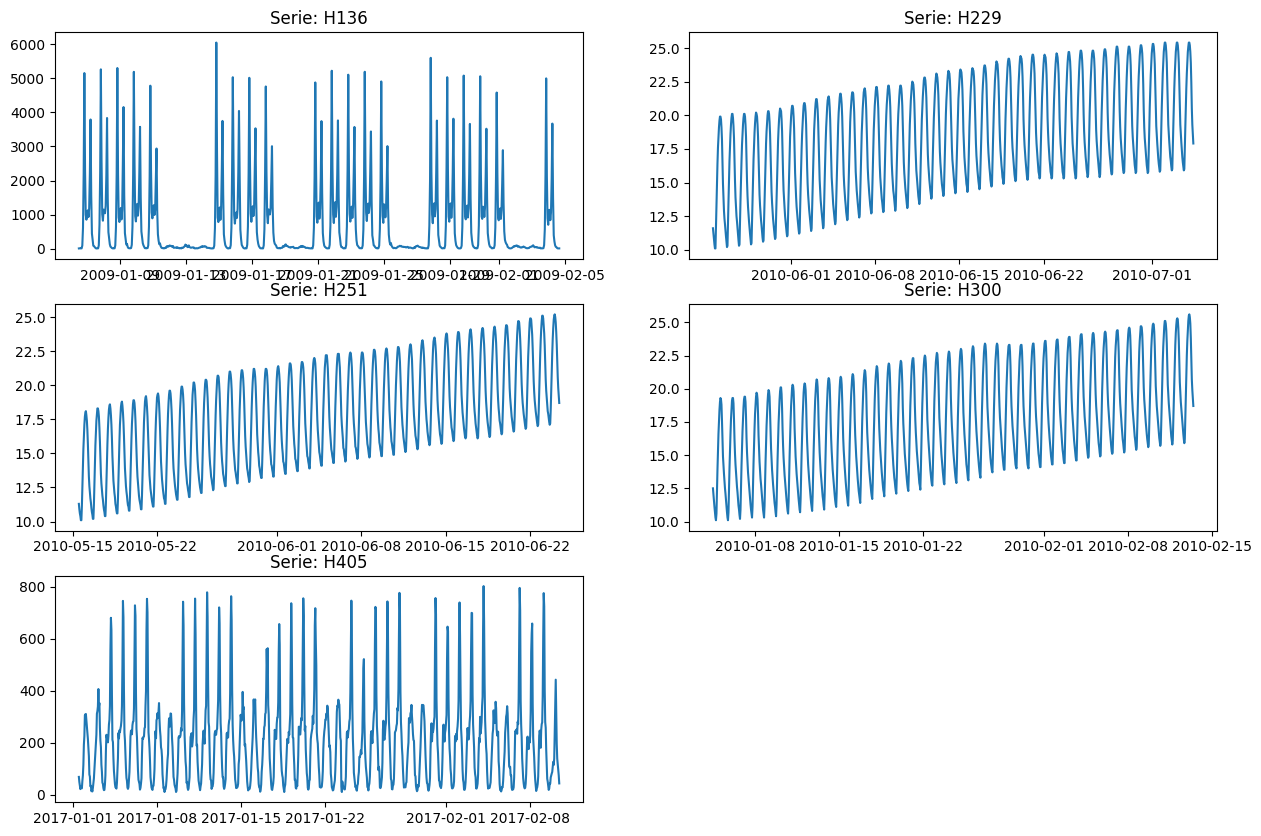

In [7]:
# Poniendo las series de tiempo en una lista
series = [h136, h229, h251, h300, h405]

# Usando la función para graficar las series de tiempo
Utils.plot_series(series, series_a_usar)

## 2. Modelado
____
### 2.1. Serie H136

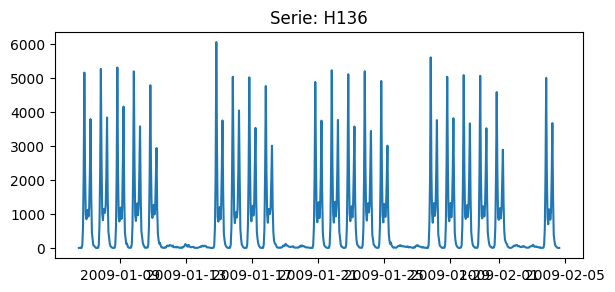

In [8]:
Utils.plot_series([h136], ['H136'])

#### 1. Preprocesamiento de los datos
- Al tener una serie que es bastante Estacional (que se repite mucho los patrones cada cierto tiempo), no veo necesario hacer un procesamiento de los datos, además de que parecen ser que son bastante simétricos.

In [9]:
# Dandole formato a la serie de tiempo
X, y = Utils.split_univariate_sequence(sequence=h136, 
                                       column='H136', 
                                       n_steps=5, 
                                       tensor=False,
                                       )

	- Forma de X: (695, 5)
	- Forma de y: (695,)


- Se seleccionó *n_steps = 5*, porque tenemos una serie de tiempo con bajadas y subidas constantes así que seleccionamos un número mediano para poder saber si es una bajada prolongada o solo es una bajada y subida y poder aprender esa estacionalidad de la serie.

In [10]:
# Separando los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = Utils.split_train_test(X=X, 
                                                          y=y, 
                                                          train_size=0.9)

- X:
	- X_train: (625, 5)
	- X_test: (70, 5)
- y:
	- y_train: (625,)
	- y_test: (70,)


#### 2. MLP - Multy Layer Perceptron
##### 2.1 MLP
- 2 Capas ocultas con 20 neuronas

El último estado de la métrica mae es: 187.5103


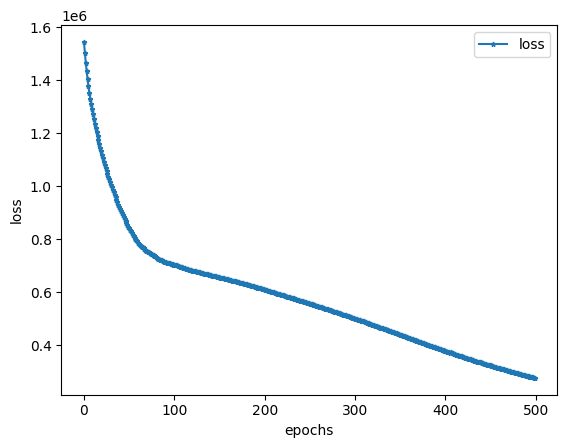

In [11]:
# Creando el modelo MLP con 5 capas ocultas de 50 neuronas
model_mlp1, h_mlp1 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=2, num_neurons=20,
                                         optimizer='Adam', lr=0.0001, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)


3/3 [==============================] - 0s 2ms/step
  Modelo    R2    MAE  MAPE
0  MLP 1  0.85  112.5  0.53


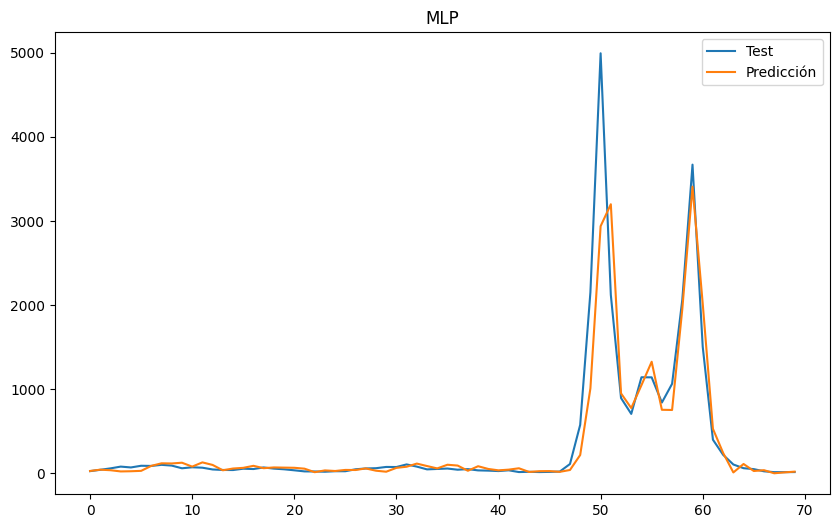

In [12]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp1 = Utils.plot_pred_test(nombre_modelo='MLP 1',
                                   title='MLP',
                                   pred=model_mlp1.predict(X_test),
                                   test=y_test
                                   )

##### 2.2 MLP
- 4 Capas ocultas con 30 neuronas

El último estado de la métrica mae es: 66.944


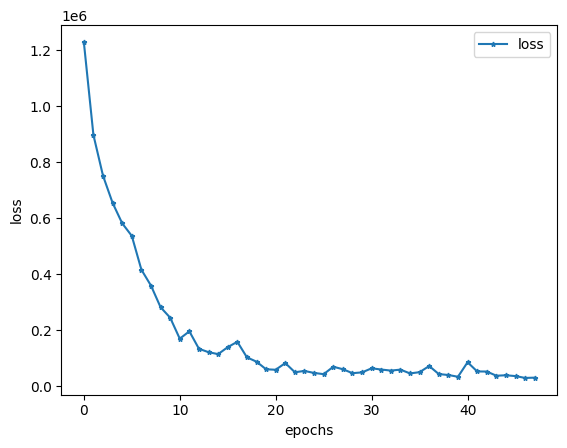

In [13]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp2, h_mlp2 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=4, num_neurons=30,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0  MLP 2  0.99  48.48  0.51


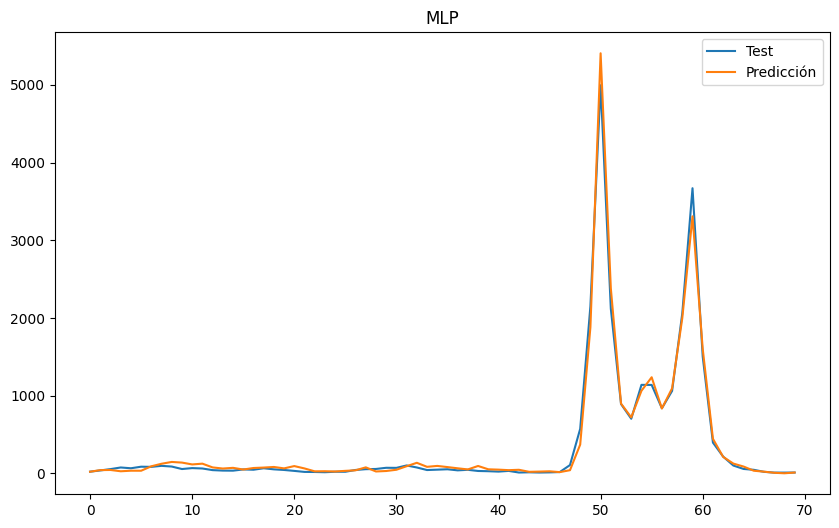

In [14]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp2 = Utils.plot_pred_test(nombre_modelo='MLP 2',
                                   title='MLP',
                                   pred=model_mlp2.predict(X_test),
                                   test=y_test
                                   )

##### 2.3 MLP
- 5 Capas ocultas con 50 neuronas

El último estado de la métrica mae es: 81.8441


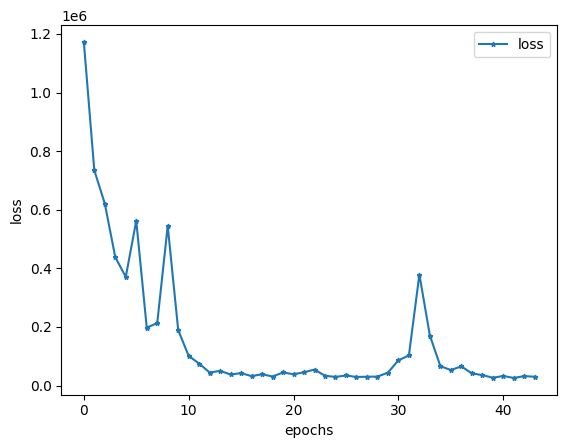

In [15]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp3, h_mlp3 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=5, num_neurons=50,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 2ms/step
  Modelo    R2    MAE  MAPE
0  MLP 3  0.99  57.26  0.62


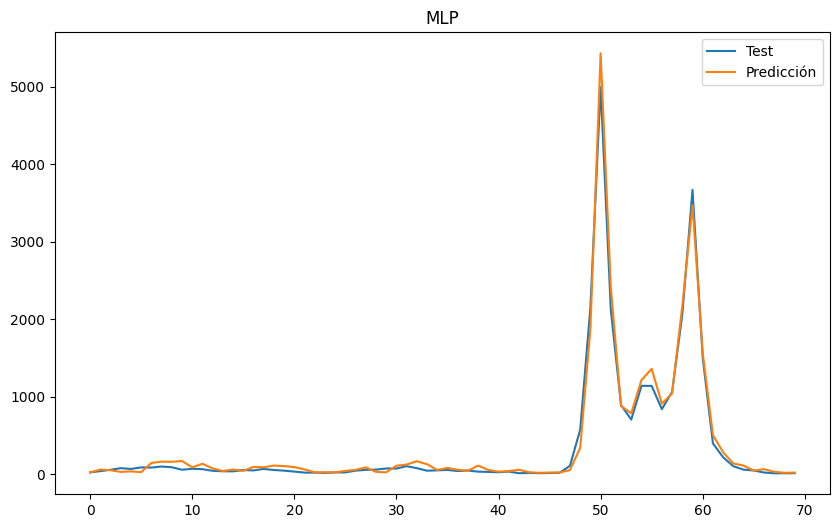

In [16]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp3 = Utils.plot_pred_test(nombre_modelo='MLP 3',
                                   title='MLP',
                                   pred=model_mlp3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones MLP**

In [17]:
errores_MLP = Utils.concat_errores([errores_mlp1, errores_mlp2, errores_mlp3])
errores_MLP

Modelo    R2     MAE  MAPE
0  MLP 2  0.99   48.48  0.51
1  MLP 3  0.99   57.26  0.62
2  MLP 1  0.85  112.50  0.53

3/3 [==============================] - 0s 2ms/step
  Modelo    R2    MAE  MAPE
0  MLP 2  0.99  48.48  0.51


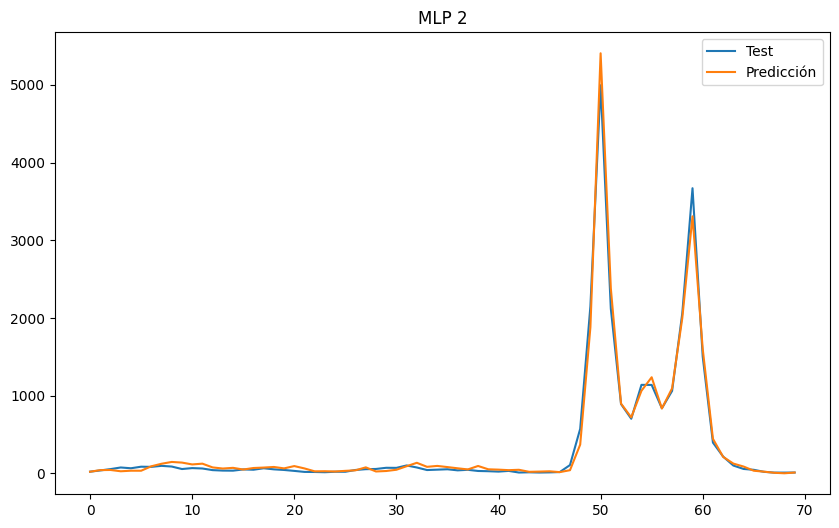

In [18]:
errores_mejor_MLP = Utils.plot_pred_test(nombre_modelo=errores_MLP['Modelo'][0],
                                         title=errores_MLP['Modelo'][0],
                                         pred=model_mlp2.predict(X_test),
                                         test=y_test)

#### 3. CNN - Convolutional Neural Network
##### 3.1. CNN 1
- Como se mencionó anteriormente, la serie tiene mucha estacionalidad muy marcada, por lo que una red CNN pequeña tendría que hacer el trabajo sin problema. Se seleccionó para empezar 2 capas convolucionales con 16 filtros de 2 y padding same, 5 capas ocultas con relu y 50 neuronas cada una.

El último estado de la métrica mae es: 66.8519


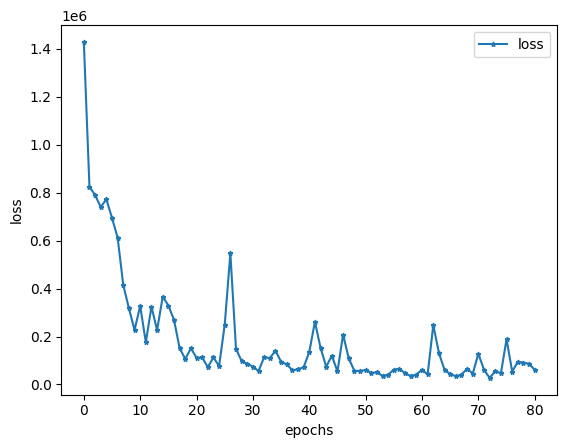

In [19]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn, h_cnn = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=2, num_filters=16, kernel_size=2, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0  CNN 1  0.99  37.47   0.3


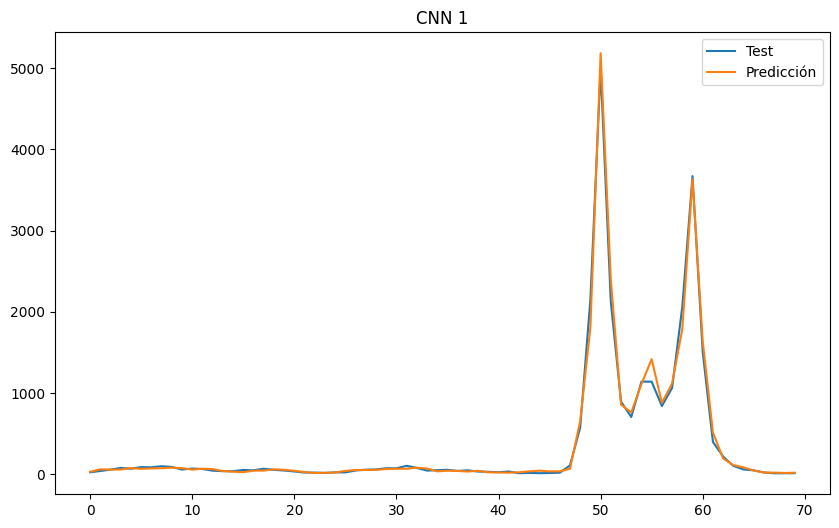

In [20]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn = Utils.plot_pred_test(nombre_modelo='CNN 1',
                                   title='CNN 1',
                                   pred=model_cnn.predict(X_test),
                                   test=y_test
                                   )

##### 3.2. CNN 2
- Agregando 2 capas convolucionales, quitando filtros y haciendo más grande el tamaño de los filtros. Buscamos que los filtros hagan un mejor trabajo.
- ASí mismo disminuimos el número de densasa para ver si funciona.

El último estado de la métrica mae es: 139.2473


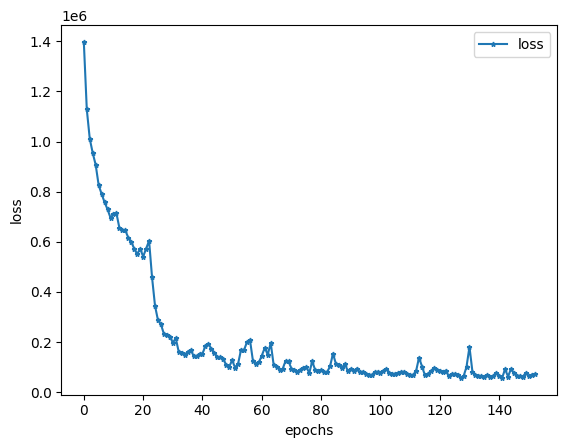

In [21]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn2, h_cnn2 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=4, num_filters=4, kernel_size=3, padding='same',
                                       activation='relu', num_layers_dense=2, num_neurons=20,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 2ms/step
  Modelo    R2   MAE  MAPE
0   CNN2  0.98  73.0  0.67


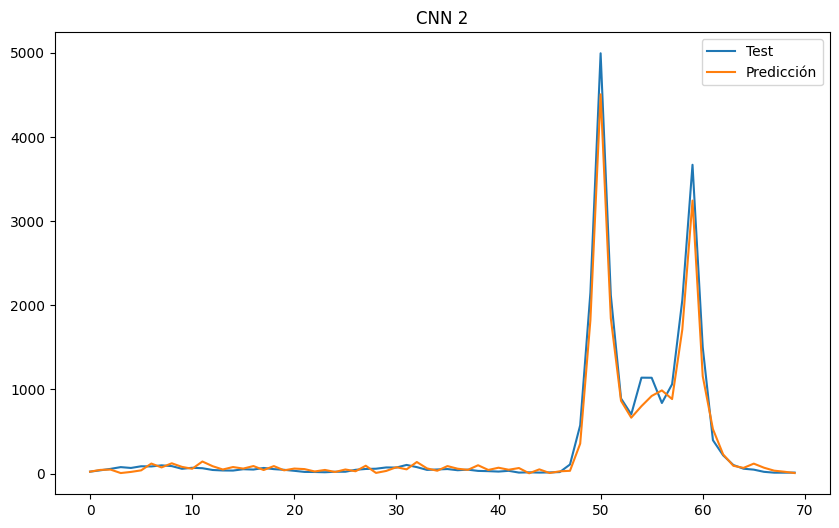

In [22]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn2 = Utils.plot_pred_test(nombre_modelo='CNN2',
                                   title='CNN 2',
                                   pred=model_cnn2.predict(X_test),
                                   test=y_test
                                   )

##### 3.3. CNN 3
- Parece ser que si funciona, aumentaremos un poco más la parte convolucioneal y también aumentaremos la parte de predicción.
- 10 capas convolucionales con 8 filtros y tamaño de 5.
- 5 capas ocultas y 50 neuronas
- Bajando el LR para bajar en la cola un poco más e intentar llegar un poco más abajo en la función de perdida.

El último estado de la métrica mae es: 90.1726


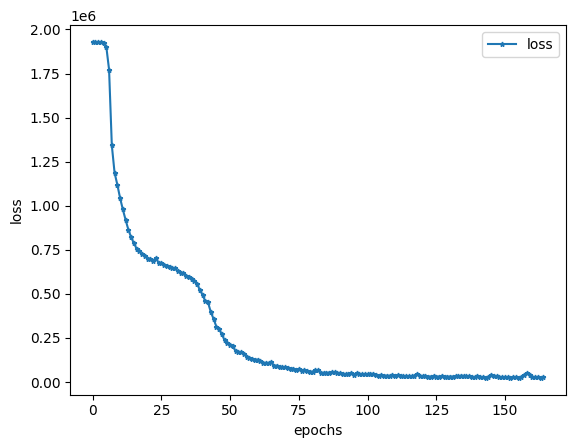

In [23]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn3, h_cnn3 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=10, num_filters=8, kernel_size=5, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 3  0.98  73.0  0.67


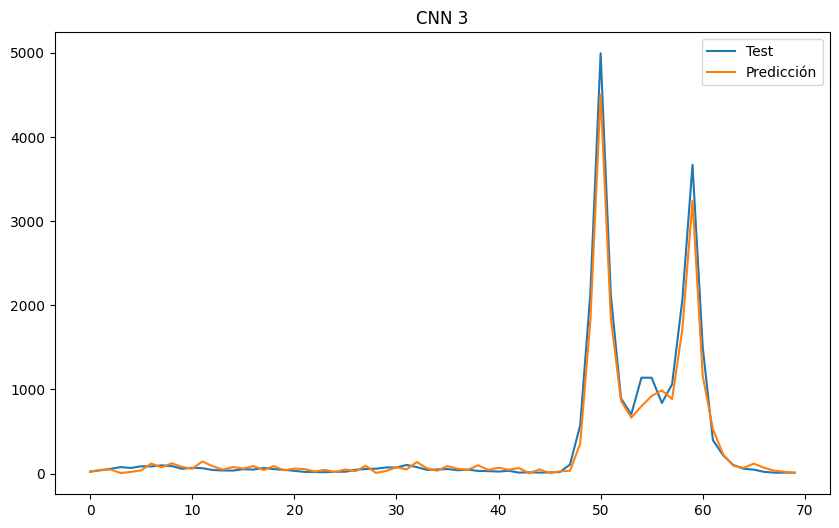

In [24]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn3 = Utils.plot_pred_test(nombre_modelo='CNN 3',
                                   title='CNN 3',
                                   pred=model_cnn2.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones CNN**

In [25]:
errores_CNN = Utils.concat_errores([errores_cnn, errores_cnn2, errores_cnn3])
errores_CNN

Modelo    R2    MAE  MAPE
0  CNN 1  0.99  37.47  0.30
1   CNN2  0.98  73.00  0.67
2  CNN 3  0.98  73.00  0.67

3/3 [==============================] - 0s 4ms/step
  Modelo    R2    MAE  MAPE
0  CNN 1  0.99  37.47   0.3


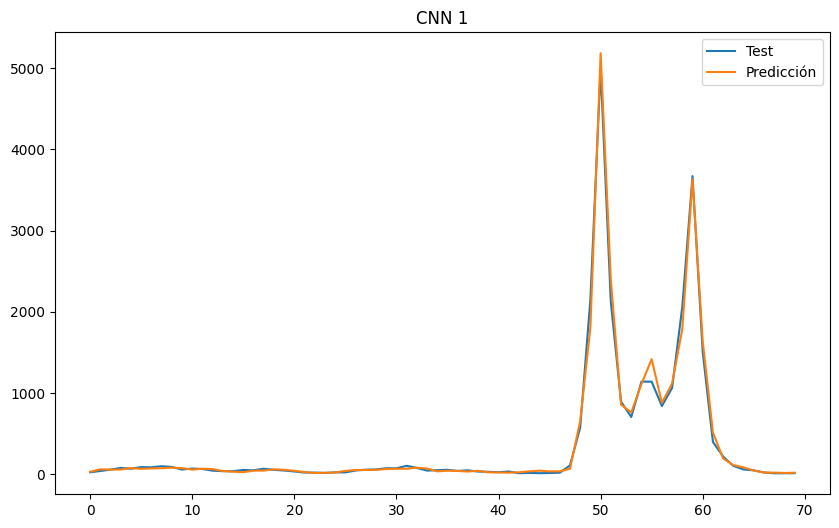

In [26]:
errores_mejor_CNN = Utils.plot_pred_test(nombre_modelo=errores_CNN['Modelo'][0],
                                         title=errores_CNN['Modelo'][0],
                                         pred=model_cnn.predict(X_test),
                                         test=y_test)

- Podemos ver que el aumento de la parte convolucional, sin embargo al aumentarla todavía más no logramos mejorar el rendimiento, por lo que seleccioné el 2 ya que es menos complejo.

#### 4. LSTM
- Para poder usar LSTM tenemos que convertir nuestros datos a tensor, por lo que rehacemos los split y Train y test.

In [27]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor
X_tens, y_tens = Utils.split_univariate_sequence(sequence=h136,
                                                 column='H136',
                                                 n_steps=5,
                                                 tensor=True,
                                                 n_features=1)

	- Forma de X: (695, 5, 1)
	- Forma de y: (695,)


In [28]:
# Dividiendo los datos en train y test
X_train_tens, X_test_tens, y_train_tens, y_test_tens = Utils.split_train_test(X=X_tens,
                                                                    y=y_tens,
                                                                    train_size=0.9
                                                                    )

- X:
	- X_train: (625, 5, 1)
	- X_test: (70, 5, 1)
- y:
	- y_train: (625,)
	- y_test: (70,)


##### 4.1 LSTM

El último estado de la métrica mae es: 106.8518


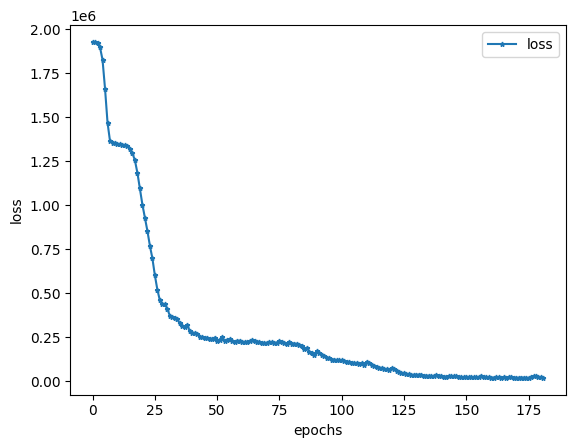

In [29]:
# Creando el modelo LSTM con 2 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm, h_lstm = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=2, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 1s 4ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 1  0.98  52.33  0.33


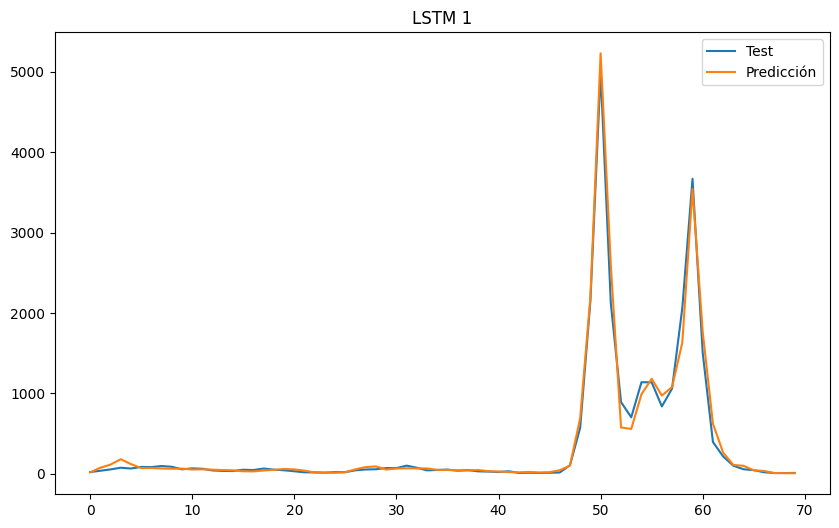

In [30]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm = Utils.plot_pred_test(nombre_modelo='LSTM 1',
                                   title='LSTM 1',
                                   pred=model_lstm.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.2 LSTM
- Aumentando capas de LSTM para ver si mejora
- 4 capas densas en vez de 2

El último estado de la métrica mae es: 96.59


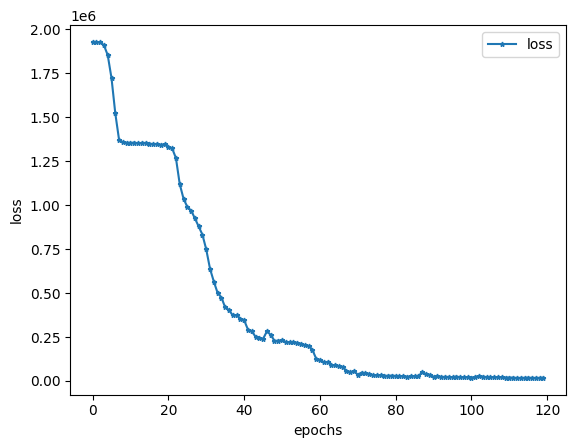

In [31]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm2, h_lstm2 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=4, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 2s 6ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 2  0.99  57.59  0.77


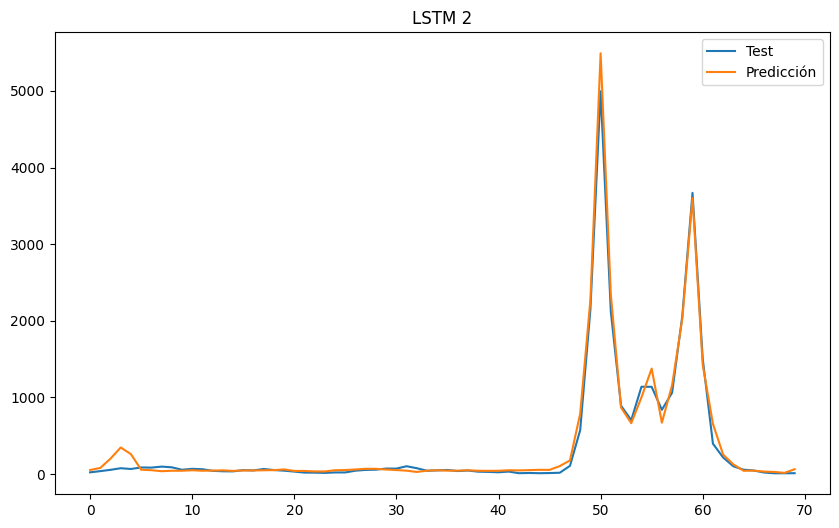

In [32]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm2 = Utils.plot_pred_test(nombre_modelo='LSTM 2',
                                   title='LSTM 2',
                                   pred=model_lstm2.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.3 LSTM

El último estado de la métrica mae es: 151.3411


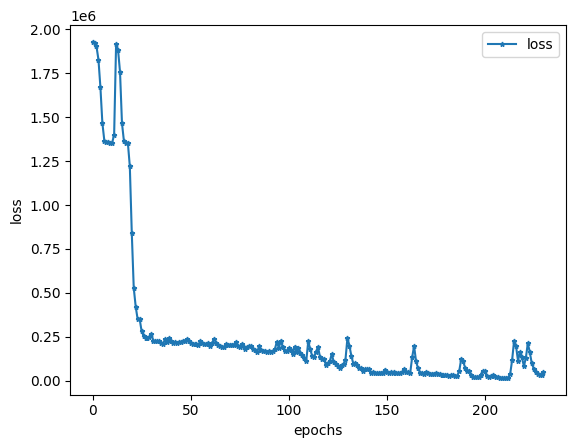

In [33]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm3, h_lstm3 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50, bidireccional=True,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 4s 7ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 3  0.94  79.52  0.35


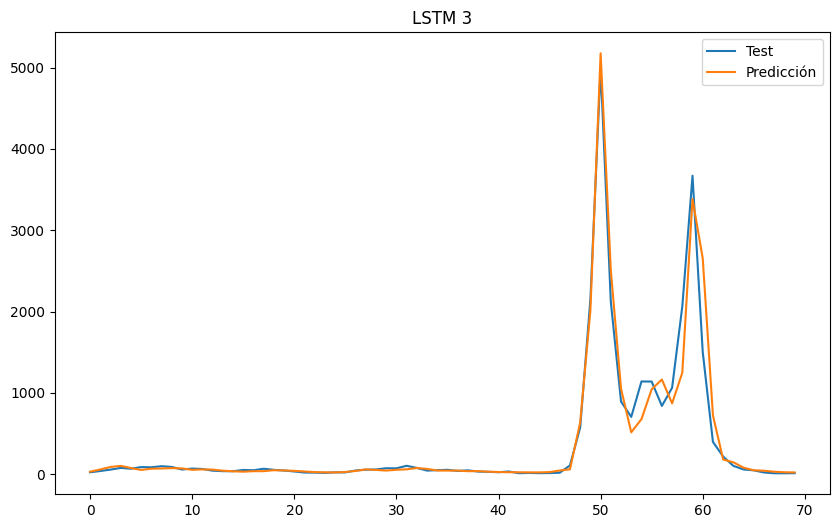

In [34]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm3 = Utils.plot_pred_test(nombre_modelo='LSTM 3',
                                   title='LSTM 3',
                                   pred=model_lstm3.predict(X_test_tens),
                                   test=y_test
                                   )

**Conclusiones**

In [35]:
errores_LSTM = Utils.concat_errores([errores_lstm, errores_lstm2, errores_lstm3])
errores_LSTM

Modelo    R2    MAE  MAPE
0  LSTM 2  0.99  57.59  0.77
1  LSTM 1  0.98  52.33  0.33
2  LSTM 3  0.94  79.52  0.35

3/3 [==============================] - 0s 5ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 2  0.98  52.33  0.33


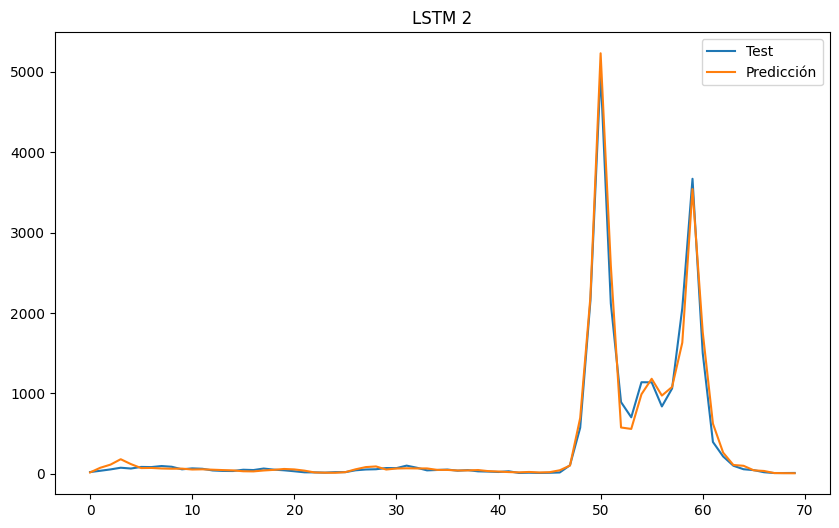

In [36]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mejor_lstm = Utils.plot_pred_test(nombre_modelo=errores_LSTM['Modelo'][0],
                                  title=errores_LSTM['Modelo'][0],
                                  pred=model_lstm.predict(X_test_tens),
                                  test=y_test)

- Tenemos un error casi nulo, sorprendemente mientras más aumentabamos las capas o la cantidad de unidades por cada (como en el caso 1 y 2 no bajo el error, parece ser que es un muy buen modelo)

#### 5. CNN - LSTM
##### 5.1. CNN - LSTM

In [37]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor con 6 pasos
X_tens2, y_tens2 = Utils.split_univariate_sequence(sequence=h136,
                                                 column='H136',
                                                 n_steps=6,
                                                 tensor=True,
                                                 n_features=1)

# Dividiendo los datos en train y test
X_train_tens2, X_test_tens2, y_train_tens2, y_test_tens2 = Utils.split_train_test(X=X_tens2,
                                                                                  y=y_tens2,
                                                                                  train_size=0.9
                                                                                    )

# Cambiando el shape del X_train_tens y X_test_tens
n_seq = 2
n_steps = 3
n_features = 1

# Cambiando el shape del X_train_tens y X_test_tens
X_train_tens2 = X_train_tens2.reshape((X_train_tens2.shape[0], n_seq, n_steps, n_features))
X_test_tens2 = X_test_tens2.reshape((X_test_tens2.shape[0], n_seq, n_steps, n_features))

	- Forma de X: (694, 6, 1)
	- Forma de y: (694,)
- X:
	- X_train: (624, 6, 1)
	- X_test: (70, 6, 1)
- y:
	- y_train: (624,)
	- y_test: (70,)


El último estado de la métrica mae es: 842.1655


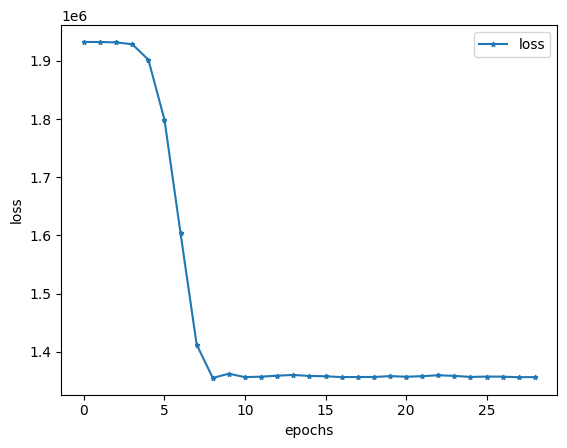

In [43]:
model_cnn_lstm1, h1_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=4, num_filters=16, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 5ms/step
         Modelo   R2     MAE   MAPE
0  CNN - LSTM 1 -0.2  758.81  18.13


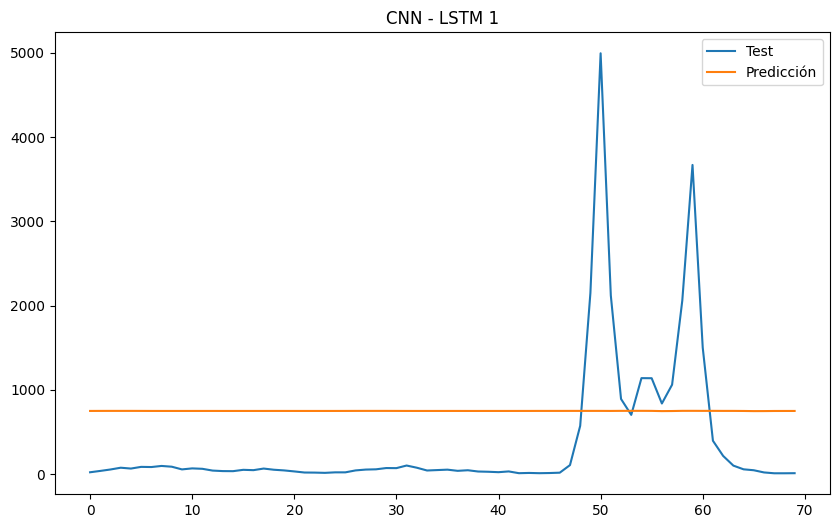

In [44]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 1',
                                          title='CNN - LSTM 1',
                                          pred=model_cnn_lstm1.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.2 CNN - LSTM 2

El último estado de la métrica mae es: 845.5065


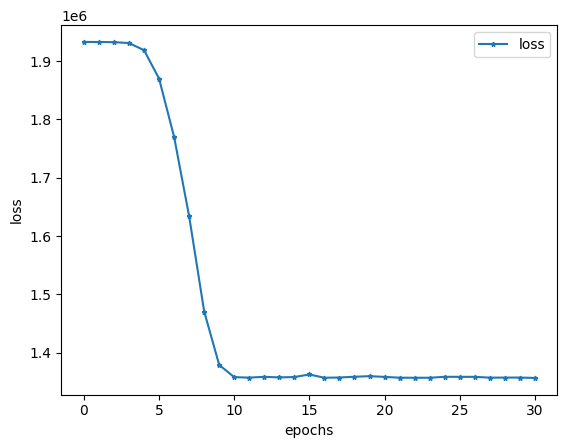

In [45]:
model_cnn_lstm2, h2_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=2, num_filters=32, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 5s 6ms/step
         Modelo    R2     MAE   MAPE
0  CNN - LSTM 2 -0.23  777.95  18.83


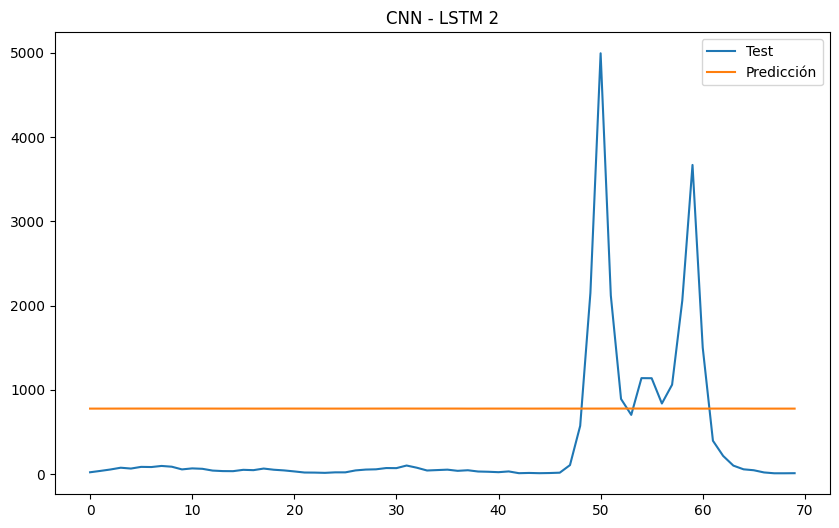

In [46]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm2 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 2',
                                          title='CNN - LSTM 2',
                                          pred=model_cnn_lstm2.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.3 CNN - LSTM 3

El último estado de la métrica mae es: 110.733


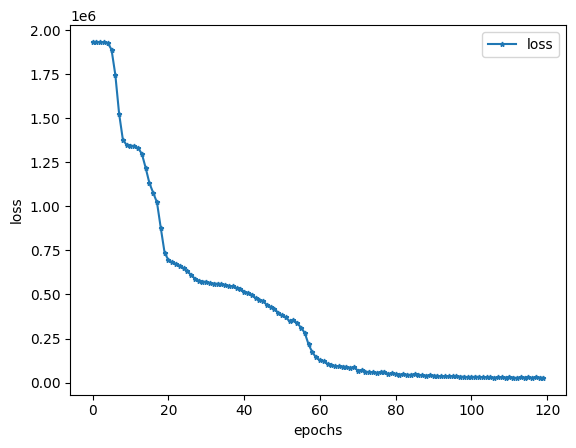

In [47]:
model_cnn_lstm3, h3_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=8, num_filters=4, kernel_size=4, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 4s 6ms/step
         Modelo    R2    MAE  MAPE
0  CNN - LSTM 3  0.98  56.01  0.48


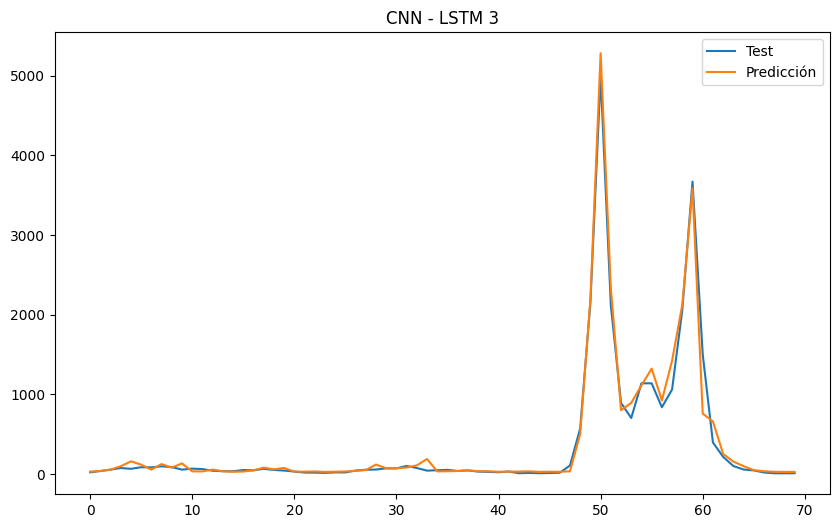

In [48]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm3 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 3',
                                          title='CNN - LSTM 3',
                                          pred=model_cnn_lstm3.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

**Conclusiones**

In [49]:
errores_cnn_lstm = Utils.concat_errores([errores_cnn_lstm1, errores_cnn_lstm2, errores_cnn_lstm3])
errores_cnn_lstm

Modelo    R2     MAE   MAPE
0  CNN - LSTM 3  0.98   56.01   0.48
1  CNN - LSTM 1 -0.20  758.81  18.13
2  CNN - LSTM 2 -0.23  777.95  18.83

3/3 [==============================] - 0s 6ms/step
         Modelo   R2     MAE   MAPE
0  CNN - LSTM 3 -0.2  758.81  18.13


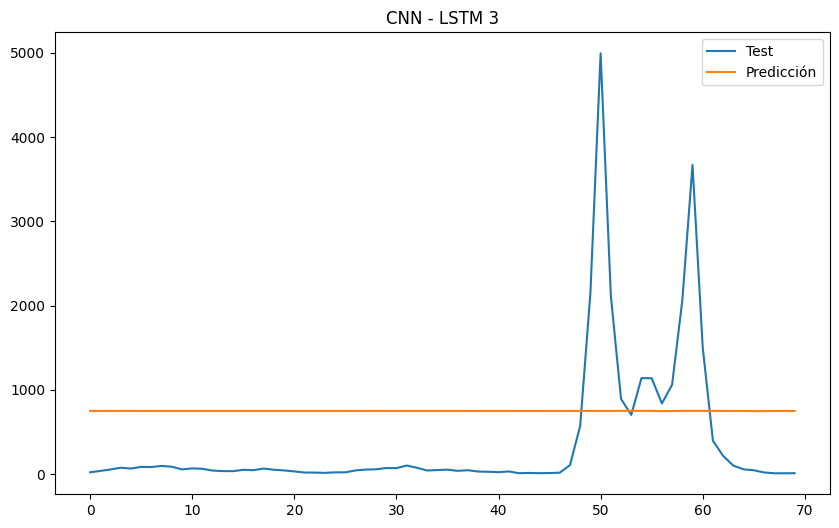

In [50]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mejor_CNN_LSTM = Utils.plot_pred_test(nombre_modelo=errores_cnn_lstm['Modelo'][0],
                                  title=errores_cnn_lstm['Modelo'][0],
                                  pred=model_cnn_lstm1.predict(X_test_tens2),
                                  test=y_test)

**Sacando el mejor modelo**

In [51]:
mejores_modelos = Utils.concat_errores([errores_mejor_MLP, errores_mejor_CNN, errores_mejor_lstm, errores_mejor_CNN_LSTM]).sort_values(by='MAE')
mejores_modelos

Modelo    R2     MAE   MAPE
1         CNN 1  0.99   37.47   0.30
0         MLP 2  0.99   48.48   0.51
2        LSTM 2  0.98   52.33   0.33
3  CNN - LSTM 3 -0.20  758.81  18.13

- El mejor modelo es el LSTM, por lo que es el que haremos la predicción

2/2 [==============================] - 0s 5ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 2  0.03  16.86  0.38


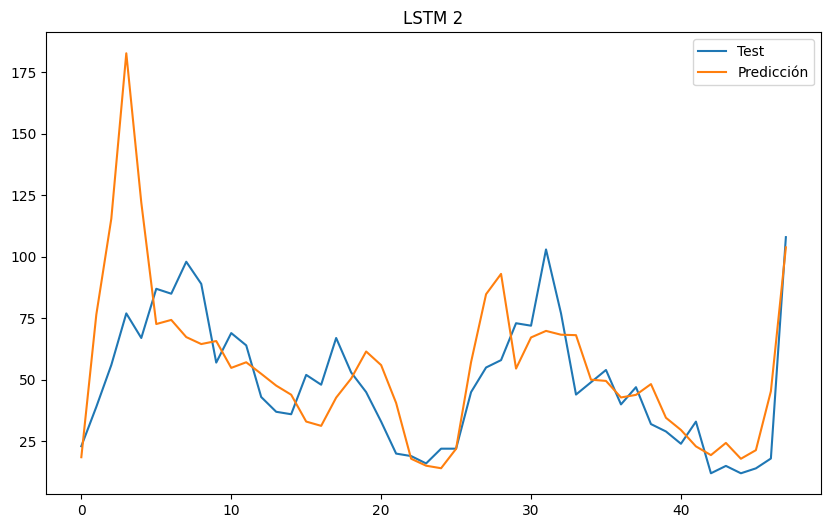

In [52]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mejor_lstm = Utils.plot_pred_test(nombre_modelo=errores_LSTM['Modelo'][0],
                                  title=errores_LSTM['Modelo'][0],
                                  pred=model_lstm.predict(X_test_tens[:48]),
                                  test=y_test[:48])

- No se hizo ajuste de hiperparámetros ya que tenemos un r2 de 0.99, lo cual buscar mejorarlo es overfitearlo y desperdiciar poder de computo.

____
### 2.2. Serie H229

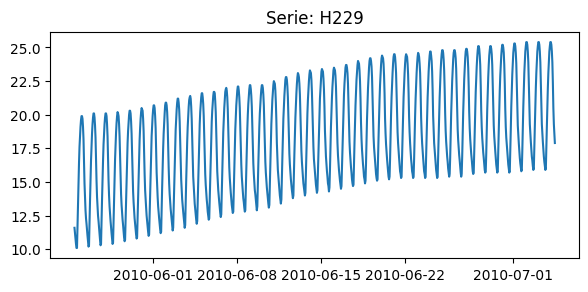

In [53]:
Utils.plot_series([h229], ['H229'])

#### 1. Preprocesamiento de los datos
- Al tener una serie que es bastante Estacional (que se repite mucho los patrones cada cierto tiempo), no veo necesario hacer un procesamiento de los datos, además de que parecen ser que son bastante simétricos.

In [54]:
# Dandole formato a la serie de tiempo
X, y = Utils.split_univariate_sequence(sequence=h229, 
                                       column='H229', 
                                       n_steps=5, 
                                       tensor=False,
                                       )

	- Forma de X: (955, 5)
	- Forma de y: (955,)


- Se seleccionó *n_steps = 5*, porque tenemos una serie de tiempo con bajadas y subidas constantes así que seleccionamos un número mediano para poder saber si es una bajada prolongada o solo es una bajada y subida y poder aprender esa estacionalidad de la serie.

In [55]:
# Separando los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = Utils.split_train_test(X=X, 
                                                          y=y, 
                                                          train_size=0.9)

- X:
	- X_train: (859, 5)
	- X_test: (96, 5)
- y:
	- y_train: (859,)
	- y_test: (96,)


#### 2. MLP - Multy Layer Perceptron
##### 2.1 MLP
- 2 Capas ocultas con 20 neuronas

El último estado de la métrica mae es: 0.349


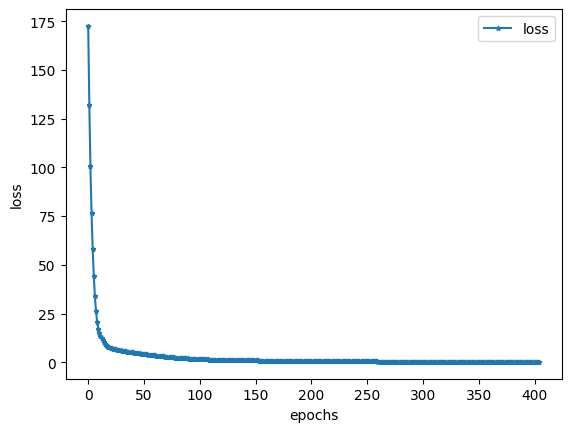

In [56]:
# Creando el modelo MLP con 5 capas ocultas de 50 neuronas
model_mlp1, h_mlp1 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=2, num_neurons=20,
                                         optimizer='Adam', lr=0.0001, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)


3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  MLP 1  0.98  0.36  0.02


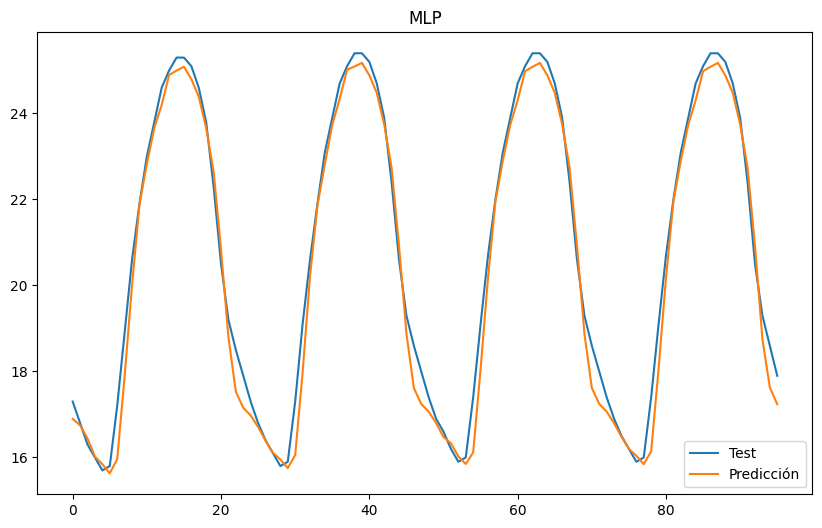

In [57]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp1 = Utils.plot_pred_test(nombre_modelo='MLP 1',
                                   title='MLP',
                                   pred=model_mlp1.predict(X_test),
                                   test=y_test
                                   )

##### 2.2 MLP
- 4 Capas ocultas con 30 neuronas

El último estado de la métrica mae es: 0.2922


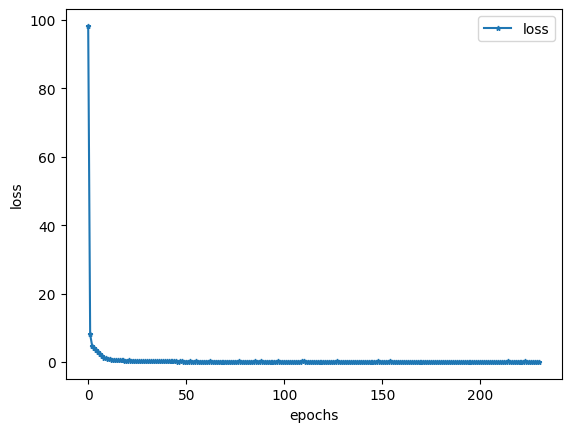

In [58]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp2, h_mlp2 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=4, num_neurons=30,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 2ms/step
  Modelo    R2  MAE  MAPE
0  MLP 2  0.99  0.3  0.01


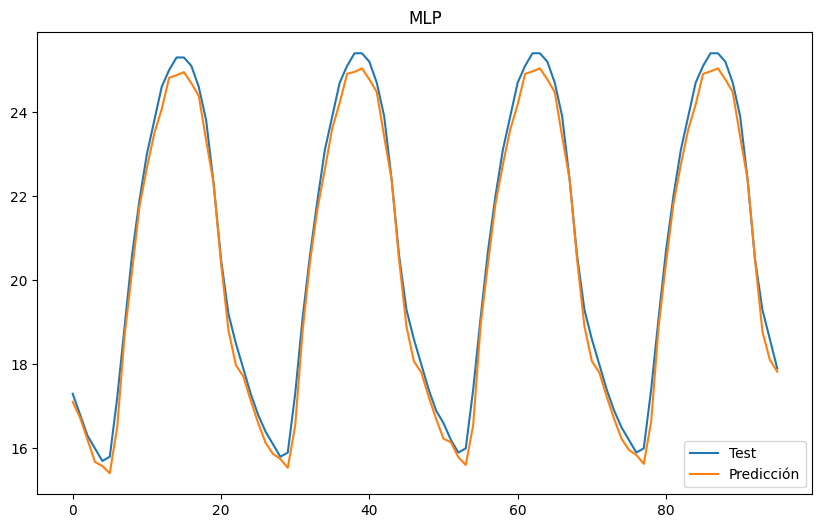

In [59]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp2 = Utils.plot_pred_test(nombre_modelo='MLP 2',
                                   title='MLP',
                                   pred=model_mlp2.predict(X_test),
                                   test=y_test
                                   )

##### 2.3 MLP
- 5 Capas ocultas con 50 neuronas

El último estado de la métrica mae es: 0.2898


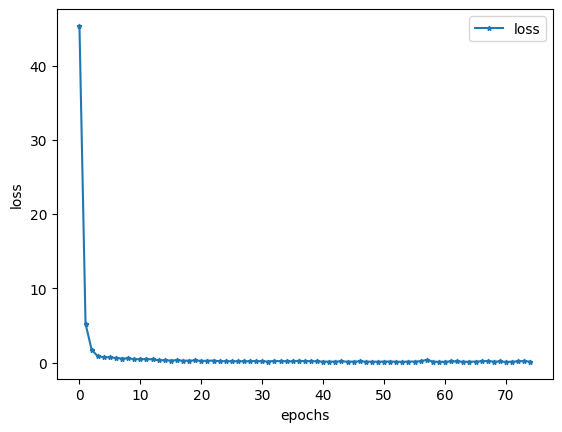

In [60]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp3, h_mlp3 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=5, num_neurons=50,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 4ms/step
  Modelo    R2   MAE  MAPE
0  MLP 3  0.99  0.32  0.02


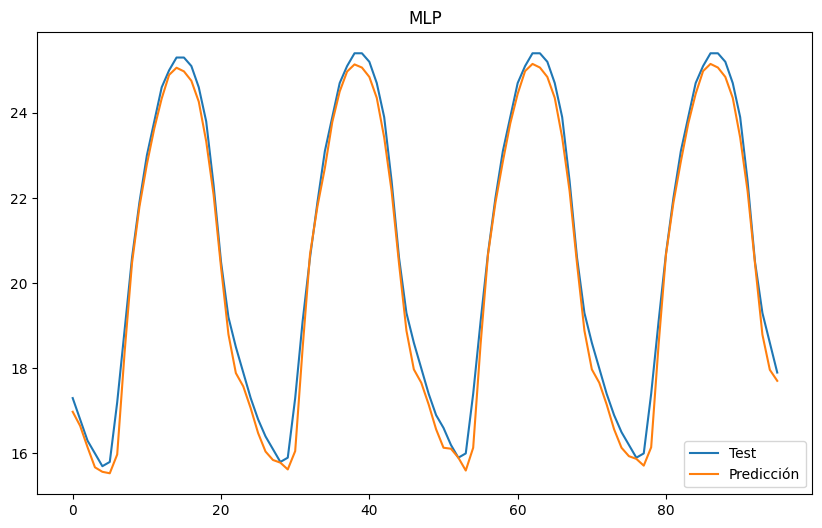

In [61]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp3 = Utils.plot_pred_test(nombre_modelo='MLP 3',
                                   title='MLP',
                                   pred=model_mlp3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones MLP**

In [62]:
errores_MLP = Utils.concat_errores([errores_mlp1, errores_mlp2, errores_mlp3])
errores_MLP

Modelo    R2   MAE  MAPE
0  MLP 2  0.99  0.30  0.01
1  MLP 3  0.99  0.32  0.02
2  MLP 1  0.98  0.36  0.02

3/3 [==============================] - 0s 3ms/step
  Modelo    R2  MAE  MAPE
0  MLP 2  0.99  0.3  0.01


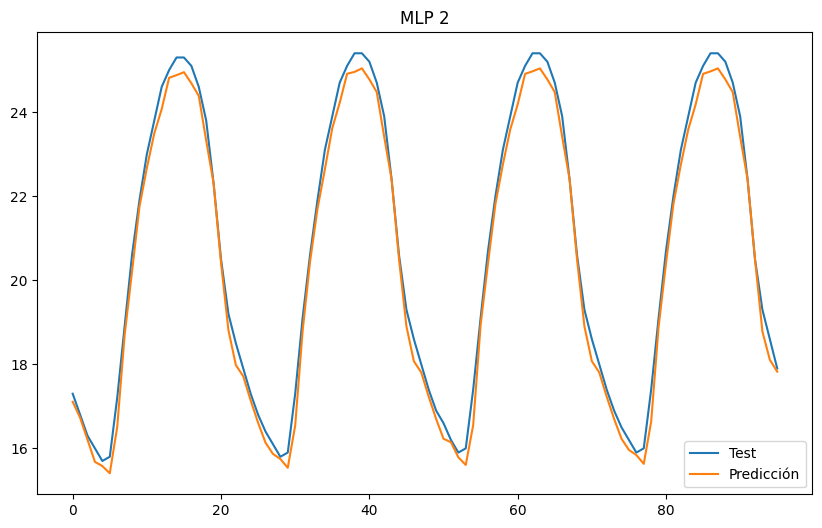

In [63]:
errores_mejor_MLP = Utils.plot_pred_test(nombre_modelo=errores_MLP['Modelo'][0],
                                         title=errores_MLP['Modelo'][0],
                                         pred=model_mlp2.predict(X_test),
                                         test=y_test)

#### 3. CNN - Convolutional Neural Network
##### 3.1. CNN 1
- Como se mencionó anteriormente, la serie tiene mucha estacionalidad muy marcada, por lo que una red CNN pequeña tendría que hacer el trabajo sin problema. Se seleccionó para empezar 2 capas convolucionales con 16 filtros de 2 y padding same, 5 capas ocultas con relu y 50 neuronas cada una.

El último estado de la métrica mae es: 0.231


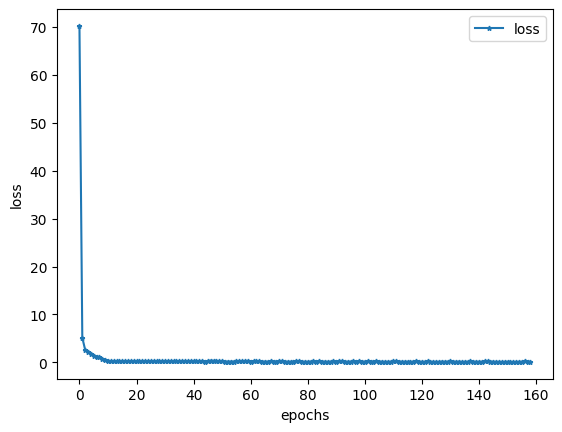

In [64]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn, h_cnn = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=2, num_filters=16, kernel_size=2, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 1  0.99  0.25  0.01


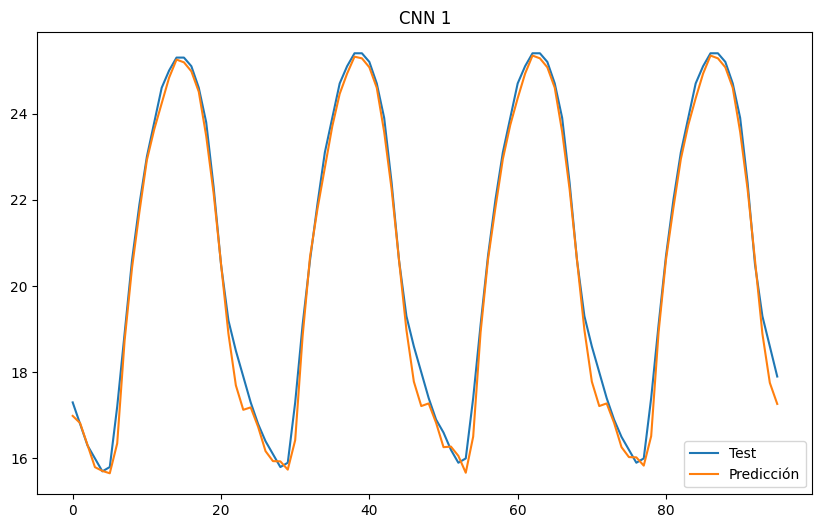

In [65]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn = Utils.plot_pred_test(nombre_modelo='CNN 1',
                                   title='CNN 1',
                                   pred=model_cnn.predict(X_test),
                                   test=y_test
                                   )

##### 3.2. CNN 2
- Agregando 2 capas convolucionales, quitando filtros y haciendo más grande el tamaño de los filtros. Buscamos que los filtros hagan un mejor trabajo.
- ASí mismo disminuimos el número de densasa para ver si funciona.

El último estado de la métrica mae es: 0.4194


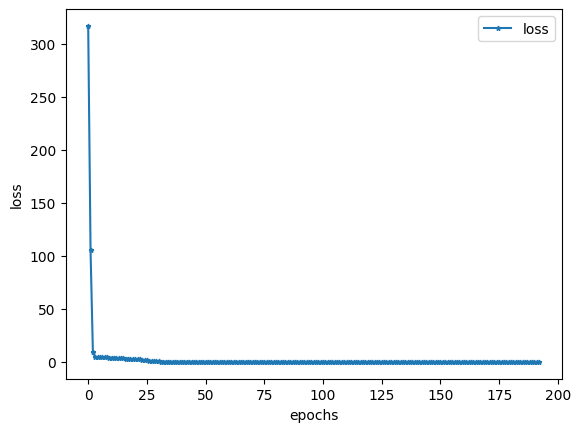

In [66]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn2, h_cnn2 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=4, num_filters=4, kernel_size=3, padding='same',
                                       activation='relu', num_layers_dense=2, num_neurons=20,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0   CNN2  0.98  0.45  0.02


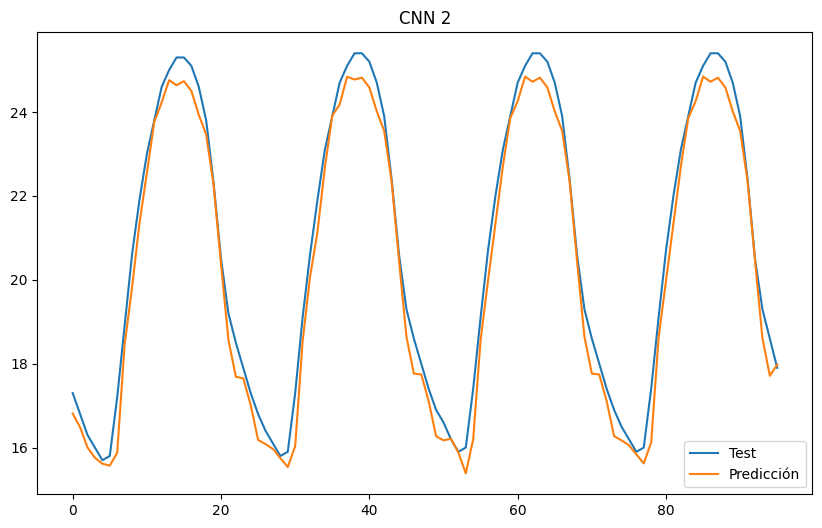

In [67]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn2 = Utils.plot_pred_test(nombre_modelo='CNN2',
                                   title='CNN 2',
                                   pred=model_cnn2.predict(X_test),
                                   test=y_test
                                   )

##### 3.3. CNN 3
- Parece ser que si funciona, aumentaremos un poco más la parte convolucioneal y también aumentaremos la parte de predicción.
- 10 capas convolucionales con 8 filtros y tamaño de 5.
- 5 capas ocultas y 50 neuronas
- Bajando el LR para bajar en la cola un poco más e intentar llegar un poco más abajo en la función de perdida.

El último estado de la métrica mae es: 0.4534


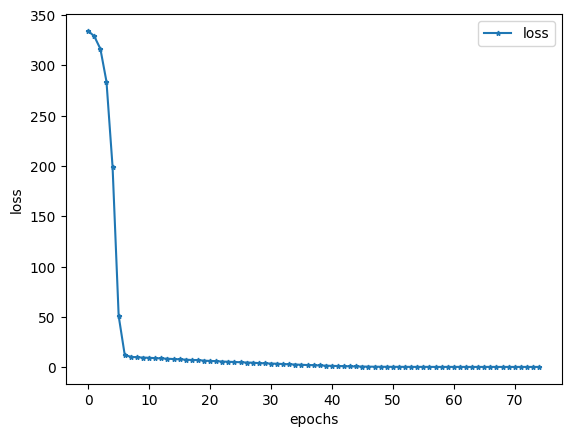

In [68]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn3, h_cnn3 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=10, num_filters=8, kernel_size=5, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 3  0.98  0.45  0.02


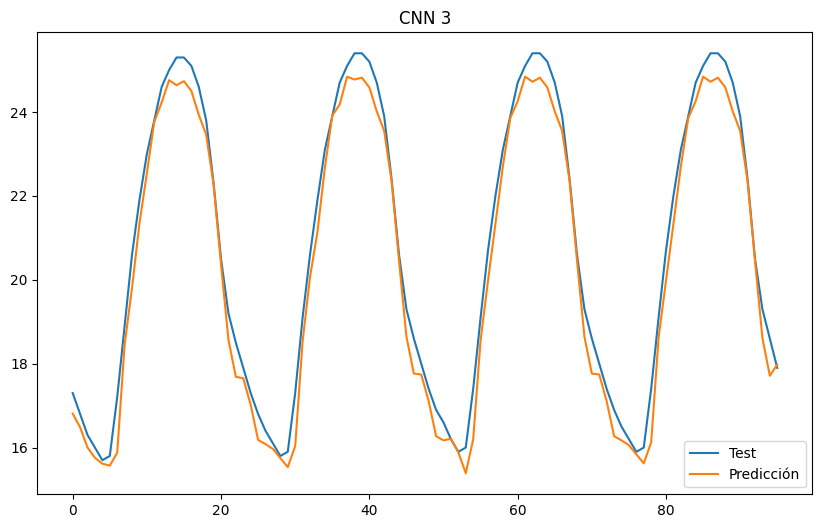

In [69]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn3 = Utils.plot_pred_test(nombre_modelo='CNN 3',
                                   title='CNN 3',
                                   pred=model_cnn2.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones CNN**

In [70]:
errores_CNN = Utils.concat_errores([errores_cnn, errores_cnn2, errores_cnn3])
errores_CNN

Modelo    R2   MAE  MAPE
0  CNN 1  0.99  0.25  0.01
1   CNN2  0.98  0.45  0.02
2  CNN 3  0.98  0.45  0.02

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 1  0.99  0.25  0.01


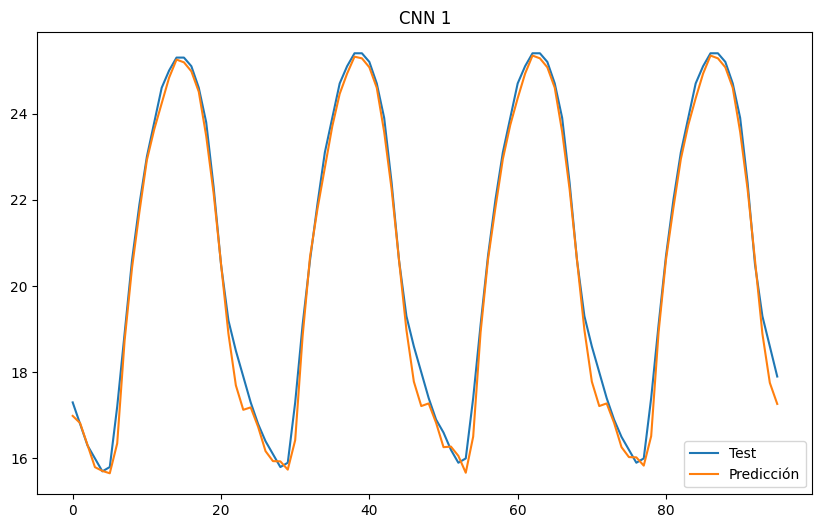

In [71]:
errores_mejor_CNN = Utils.plot_pred_test(nombre_modelo=errores_CNN['Modelo'][0],
                                         title=errores_CNN['Modelo'][0],
                                         pred=model_cnn.predict(X_test),
                                         test=y_test)

- Podemos ver que el aumento de la parte convolucional, sin embargo al aumentarla todavía más no logramos mejorar el rendimiento, por lo que seleccioné el 2 ya que es menos complejo.

#### 4. LSTM
- Para poder usar LSTM tenemos que convertir nuestros datos a tensor, por lo que rehacemos los split y Train y test.

In [72]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor
X_tens, y_tens = Utils.split_univariate_sequence(sequence=h229,
                                                 column='H229',
                                                 n_steps=5,
                                                 tensor=True,
                                                 n_features=1)

	- Forma de X: (955, 5, 1)
	- Forma de y: (955,)


In [73]:
# Dividiendo los datos en train y test
X_train_tens, X_test_tens, y_train_tens, y_test_tens = Utils.split_train_test(X=X_tens,
                                                                    y=y_tens,
                                                                    train_size=0.9
                                                                    )

- X:
	- X_train: (859, 5, 1)
	- X_test: (96, 5, 1)
- y:
	- y_train: (859,)
	- y_test: (96,)


##### 4.1 LSTM

El último estado de la métrica mae es: 0.1765


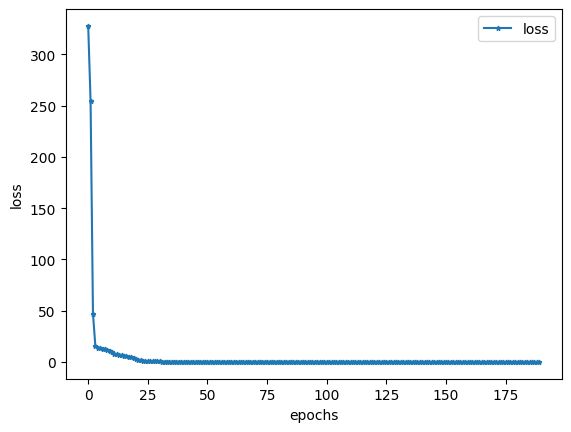

In [74]:
# Creando el modelo LSTM con 2 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm, h_lstm = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=2, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 1s 5ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.19  0.01


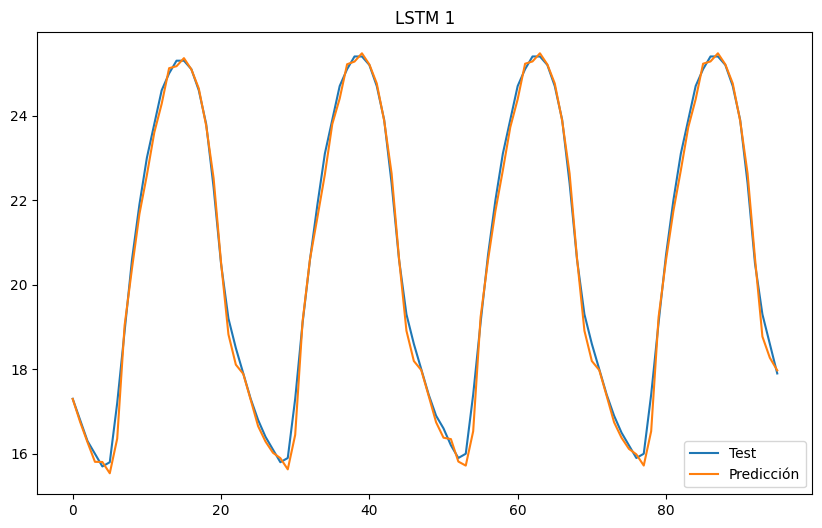

In [75]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm = Utils.plot_pred_test(nombre_modelo='LSTM 1',
                                   title='LSTM 1',
                                   pred=model_lstm.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.2 LSTM
- Aumentando capas de LSTM para ver si mejora
- 4 capas densas en vez de 2

El último estado de la métrica mae es: 0.195


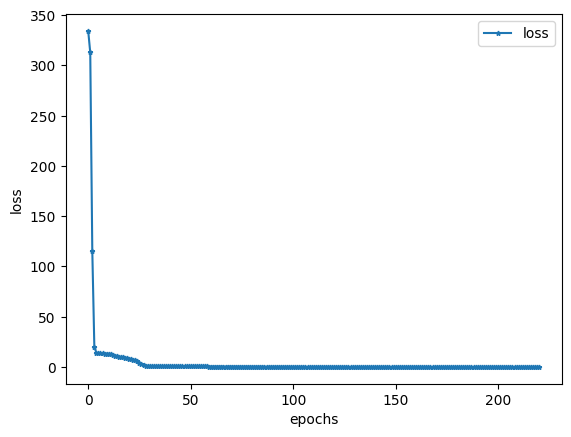

In [78]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm2, h_lstm2 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=4, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 2s 7ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 2  0.99  0.22  0.01


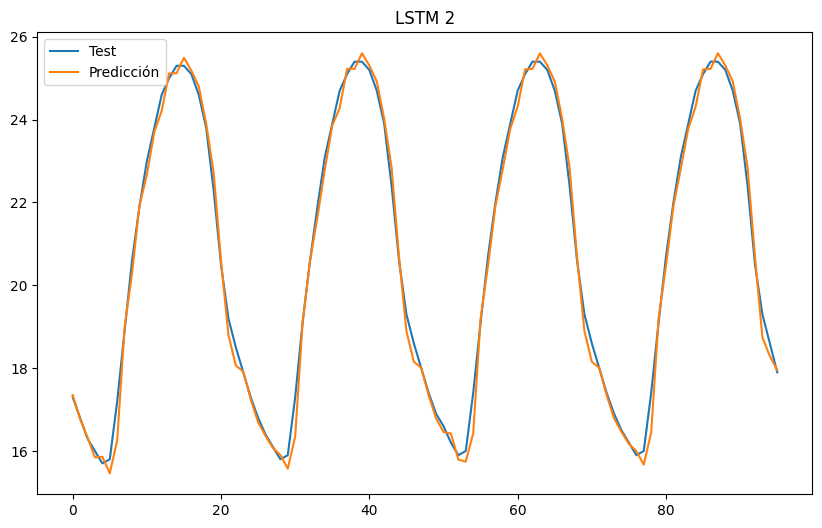

In [79]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm2 = Utils.plot_pred_test(nombre_modelo='LSTM 2',
                                   title='LSTM 2',
                                   pred=model_lstm2.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.3 LSTM

El último estado de la métrica mae es: 0.5155


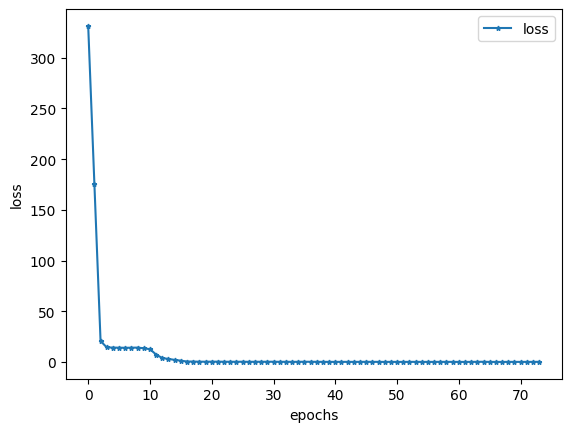

In [80]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm3, h_lstm3 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50, bidireccional=True,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 16s 14ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 3  0.96  0.57  0.03


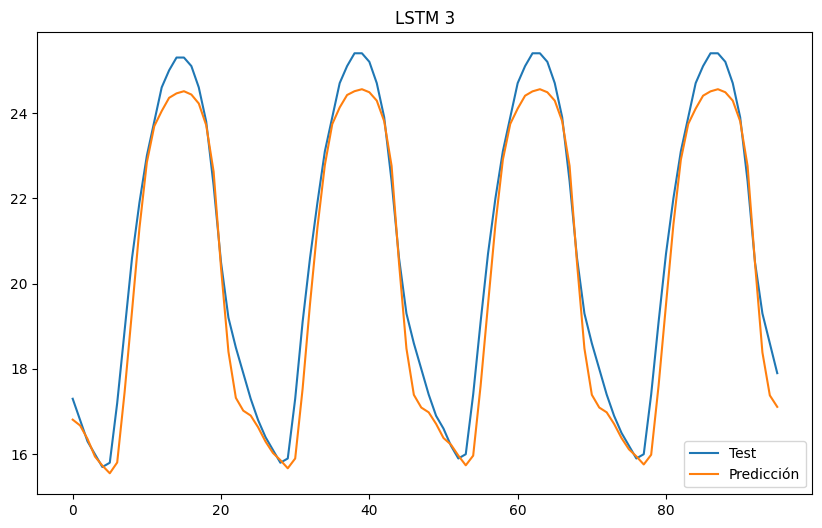

In [81]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm3 = Utils.plot_pred_test(nombre_modelo='LSTM 3',
                                   title='LSTM 3',
                                   pred=model_lstm3.predict(X_test_tens),
                                   test=y_test
                                   )

**Conclusiones**

In [82]:
errores_LSTM = Utils.concat_errores([errores_lstm, errores_lstm2, errores_lstm3])
errores_LSTM

Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.19  0.01
1  LSTM 2  0.99  0.22  0.01
2  LSTM 3  0.96  0.57  0.03

3/3 [==============================] - 0s 6ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.19  0.01


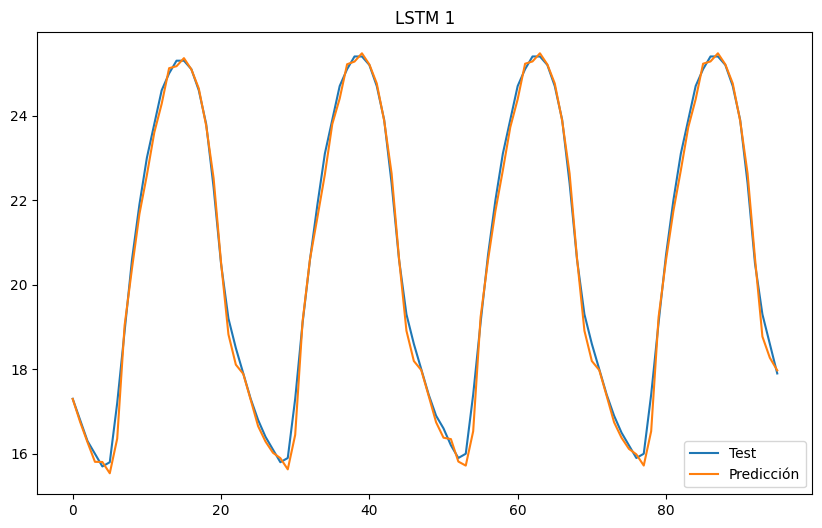

In [83]:
# Obteniendo los errores y ploteando predicciones vs test
mejor_lstm = Utils.plot_pred_test(nombre_modelo=errores_LSTM['Modelo'][0],
                                  title=errores_LSTM['Modelo'][0],
                                  pred=model_lstm.predict(X_test_tens),
                                  test=y_test)

- Tenemos un error casi nulo, sorprendemente mientras más aumentabamos las capas o la cantidad de unidades por cada (como en el caso 1 y 2 no bajo el error, parece ser que es un muy buen modelo)

#### 5. CNN - LSTM
##### 5.1. CNN - LSTM

In [84]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor con 6 pasos
X_tens2, y_tens2 = Utils.split_univariate_sequence(sequence=h229,
                                                 column='H229',
                                                 n_steps=6,
                                                 tensor=True,
                                                 n_features=1)

# Dividiendo los datos en train y test
X_train_tens2, X_test_tens2, y_train_tens2, y_test_tens2 = Utils.split_train_test(X=X_tens2,
                                                                                  y=y_tens2,
                                                                                  train_size=0.9
                                                                                    )

# Cambiando el shape del X_train_tens y X_test_tens
n_seq = 2
n_steps = 3
n_features = 1

# Cambiando el shape del X_train_tens y X_test_tens
X_train_tens2 = X_train_tens2.reshape((X_train_tens2.shape[0], n_seq, n_steps, n_features))
X_test_tens2 = X_test_tens2.reshape((X_test_tens2.shape[0], n_seq, n_steps, n_features))

	- Forma de X: (954, 6, 1)
	- Forma de y: (954,)
- X:
	- X_train: (858, 6, 1)
	- X_test: (96, 6, 1)
- y:
	- y_train: (858,)
	- y_test: (96,)


El último estado de la métrica mae es: 0.4904


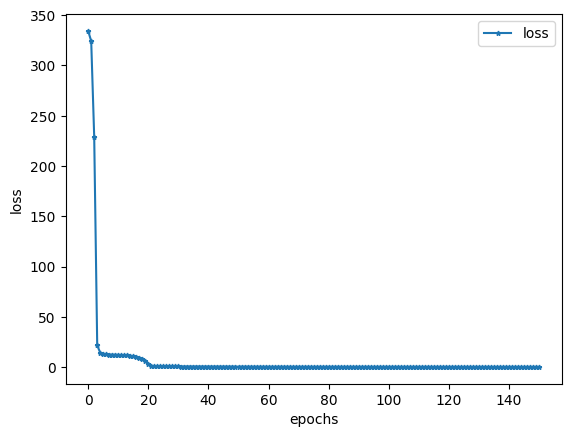

In [85]:
model_cnn_lstm1, h1_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=4, num_filters=16, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 8ms/step
         Modelo    R2   MAE  MAPE
0  CNN - LSTM 1  0.97  0.52  0.02


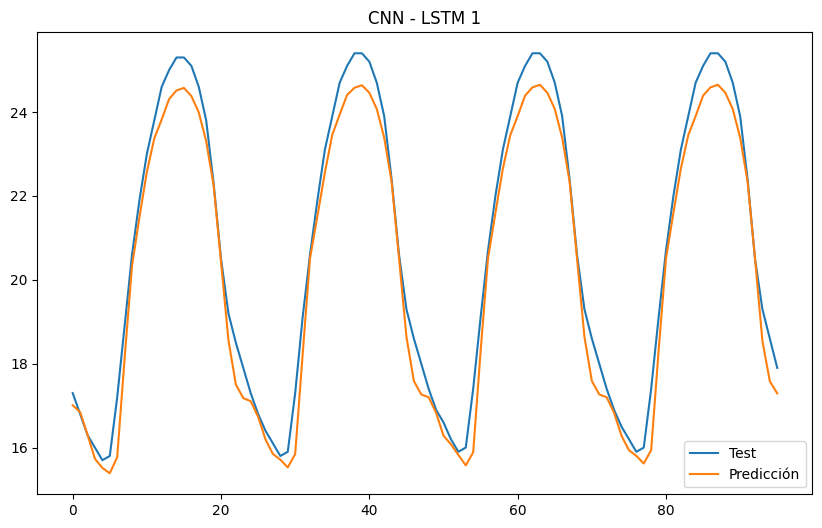

In [86]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 1',
                                          title='CNN - LSTM 1',
                                          pred=model_cnn_lstm1.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.2 CNN - LSTM 2

El último estado de la métrica mae es: 0.2745


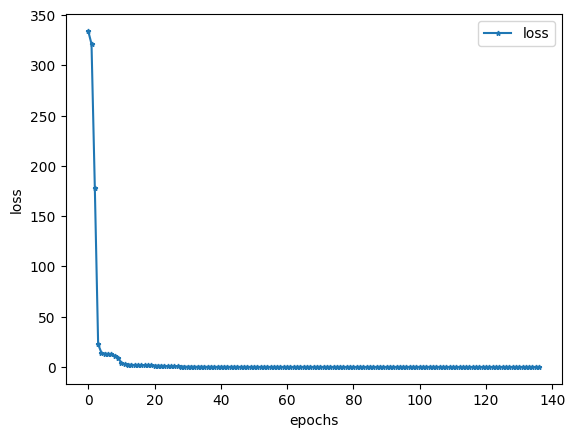

In [87]:
model_cnn_lstm2, h2_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=2, num_filters=32, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 4s 6ms/step
         Modelo    R2  MAE  MAPE
0  CNN - LSTM 2  0.99  0.3  0.01


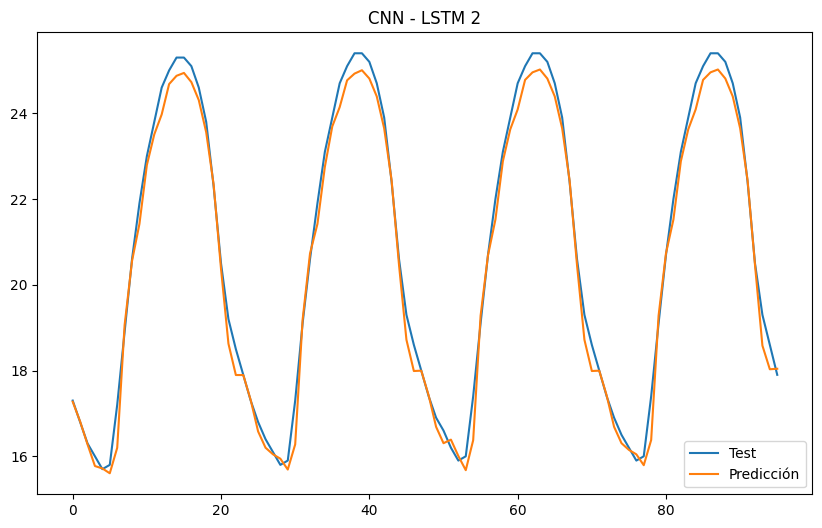

In [88]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 2',
                                          title='CNN - LSTM 2',
                                          pred=model_cnn_lstm2.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.3 CNN - LSTM 3

El último estado de la métrica mae es: 3.5275


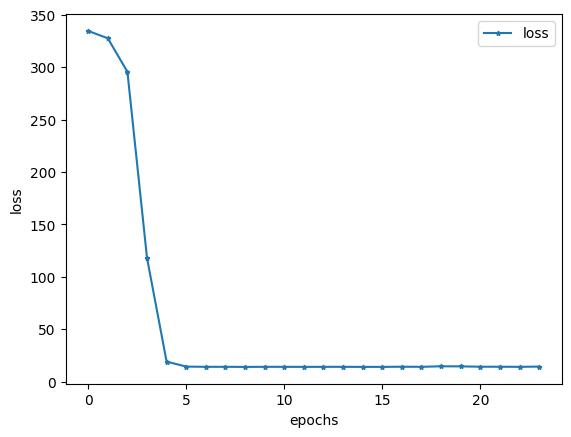

In [89]:
model_cnn_lstm3, h3_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=8, num_filters=4, kernel_size=4, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 7ms/step
         Modelo   R2   MAE  MAPE
0  CNN - LSTM 3 -0.5  3.48  0.16


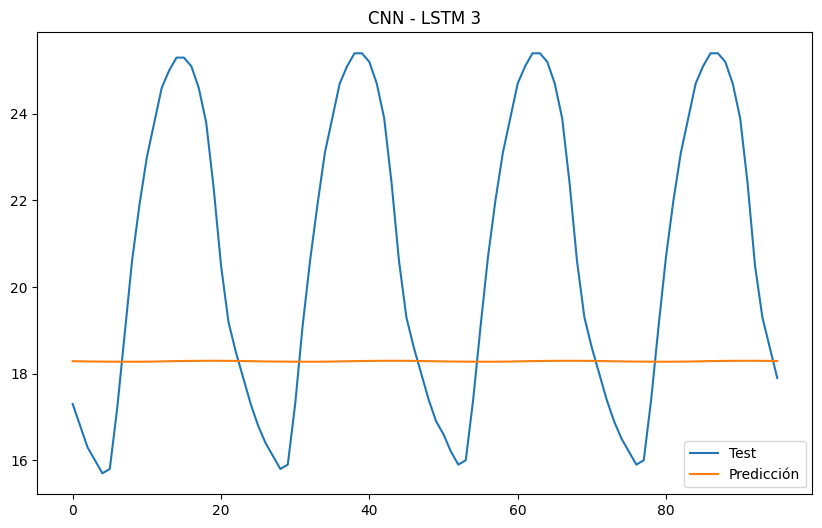

In [90]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 3',
                                          title='CNN - LSTM 3',
                                          pred=model_cnn_lstm3.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

**Conclusiones**

In [91]:
errores_cnn_lstm = Utils.concat_errores([errores_cnn_lstm1, errores_cnn_lstm2, errores_cnn_lstm3])
errores_cnn_lstm

Modelo    R2     MAE   MAPE
0  CNN - LSTM 3  0.98   56.01   0.48
1  CNN - LSTM 2 -0.23  777.95  18.83
2  CNN - LSTM 3 -0.50    3.48   0.16

3/3 [==============================] - 0s 7ms/step
         Modelo    R2   MAE  MAPE
0  CNN - LSTM 3  0.97  0.52  0.02


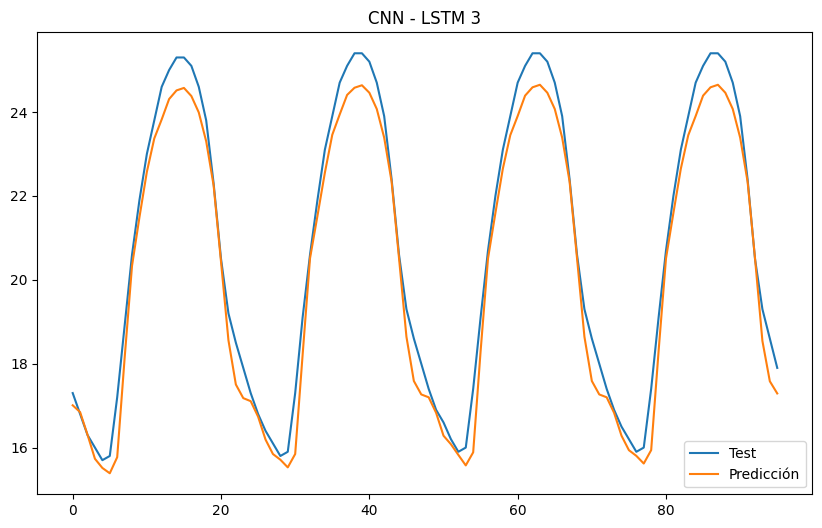

In [92]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mejor_CNN_LSTM = Utils.plot_pred_test(nombre_modelo=errores_cnn_lstm['Modelo'][0],
                                  title=errores_cnn_lstm['Modelo'][0],
                                  pred=model_cnn_lstm1.predict(X_test_tens2),
                                  test=y_test)

**Sacando el mejor modelo**

In [93]:
mejores_modelos = Utils.concat_errores([errores_mejor_MLP, errores_mejor_CNN, errores_mejor_lstm, errores_mejor_CNN_LSTM]).sort_values(by='MAE')
mejores_modelos

Modelo    R2    MAE  MAPE
1         CNN 1  0.99   0.25  0.01
0         MLP 2  0.99   0.30  0.01
2  CNN - LSTM 3  0.97   0.52  0.02
3        LSTM 2  0.03  16.86  0.38

- El mejor modelo es el CNN, por lo que es el que haremos la predicción

2/2 [==============================] - 0s 0s/step
  Modelo    R2   MAE  MAPE
0  CNN 1  0.99  0.24  0.01


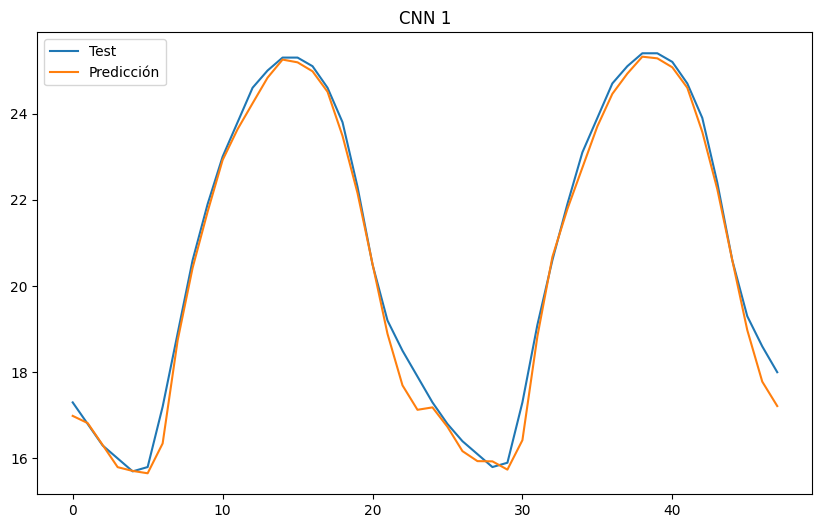

In [94]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn = Utils.plot_pred_test(nombre_modelo='CNN 1',
                                   title='CNN 1',
                                   pred=model_cnn.predict(X_test[:48]),
                                   test=y_test[:48]
                                   )

- No se hizo ajuste de hiperparámetros ya que tenemos un r2 de 0.99, lo cual buscar mejorarlo es overfitearlo y desperdiciar poder de computo.

____
### 2.3. Serie H251

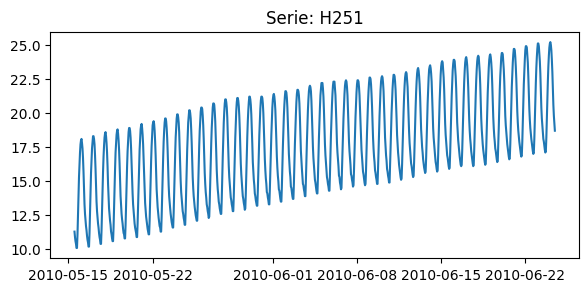

In [95]:
Utils.plot_series([h251], ['H251'])

#### 1. Preprocesamiento de los datos
- Al tener una serie que es bastante Estacional (que se repite mucho los patrones cada cierto tiempo), no veo necesario hacer un procesamiento de los datos, además de que parecen ser que son bastante simétricos.

In [96]:
# Dandole formato a la serie de tiempo
X, y = Utils.split_univariate_sequence(sequence=h251, 
                                       column='H251', 
                                       n_steps=5, 
                                       tensor=False,
                                       )

	- Forma de X: (955, 5)
	- Forma de y: (955,)


- Se seleccionó *n_steps = 5*, porque tenemos una serie de tiempo con bajadas y subidas constantes así que seleccionamos un número mediano para poder saber si es una bajada prolongada o solo es una bajada y subida y poder aprender esa estacionalidad de la serie.

In [97]:
# Separando los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = Utils.split_train_test(X=X, 
                                                          y=y, 
                                                          train_size=0.9)

- X:
	- X_train: (859, 5)
	- X_test: (96, 5)
- y:
	- y_train: (859,)
	- y_test: (96,)


#### 2. MLP - Multy Layer Perceptron
##### 2.1 MLP
- 2 Capas ocultas con 20 neuronas

El último estado de la métrica mae es: 0.4314


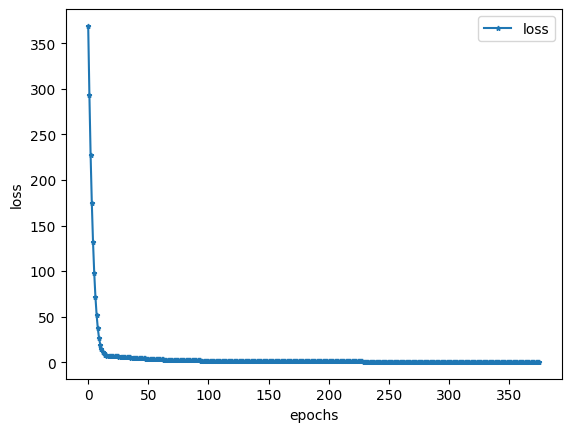

In [98]:
# Creando el modelo MLP con 5 capas ocultas de 50 neuronas
model_mlp1, h_mlp1 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=2, num_neurons=20,
                                         optimizer='Adam', lr=0.0001, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)


3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  MLP 1  0.94  0.54  0.03


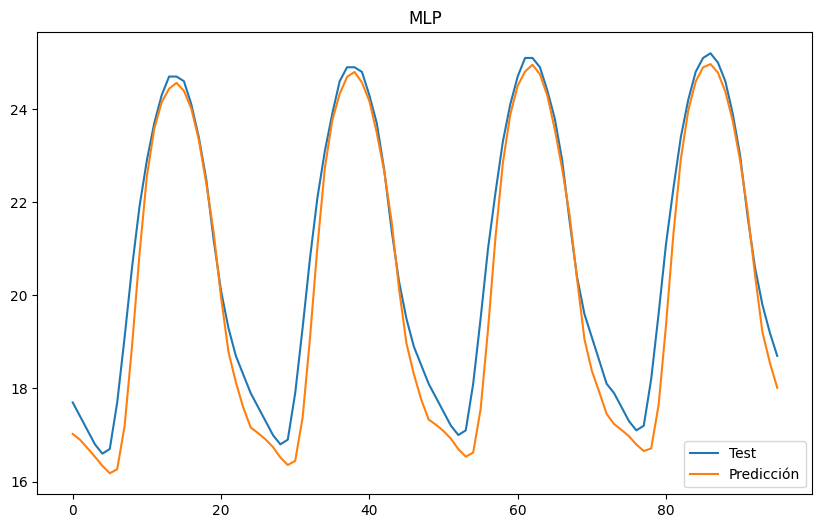

In [99]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp1 = Utils.plot_pred_test(nombre_modelo='MLP 1',
                                   title='MLP',
                                   pred=model_mlp1.predict(X_test),
                                   test=y_test
                                   )

##### 2.2 MLP
- 4 Capas ocultas con 30 neuronas

El último estado de la métrica mae es: 0.2915


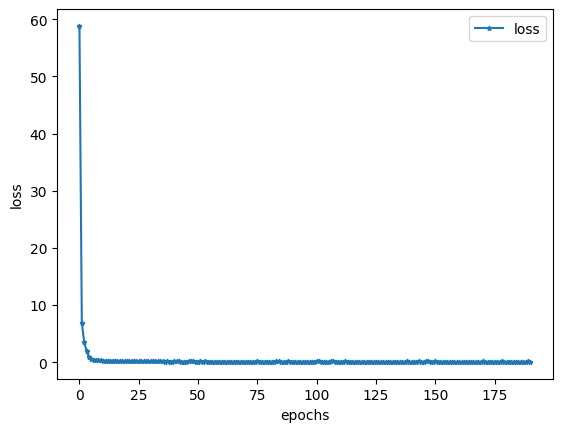

In [100]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp2, h_mlp2 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=4, num_neurons=30,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  MLP 2  0.99  0.27  0.01


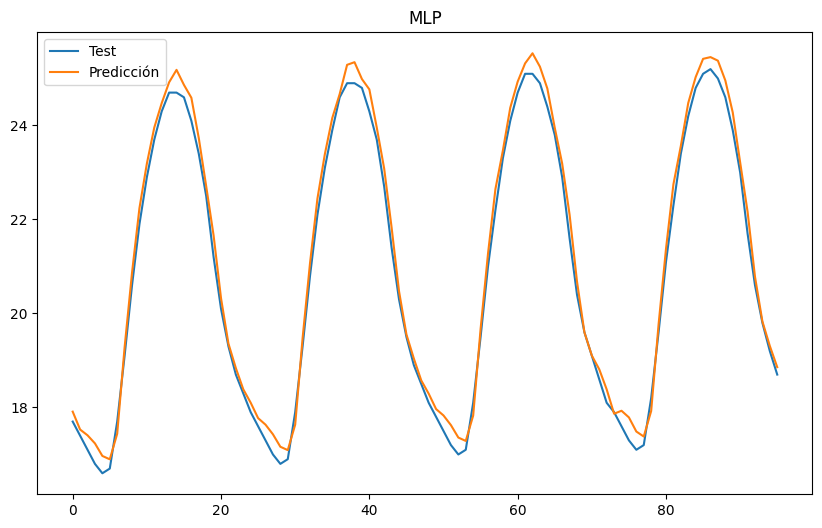

In [101]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp2 = Utils.plot_pred_test(nombre_modelo='MLP 2',
                                   title='MLP',
                                   pred=model_mlp2.predict(X_test),
                                   test=y_test
                                   )

##### 2.3 MLP
- 5 Capas ocultas con 50 neuronas

El último estado de la métrica mae es: 0.433


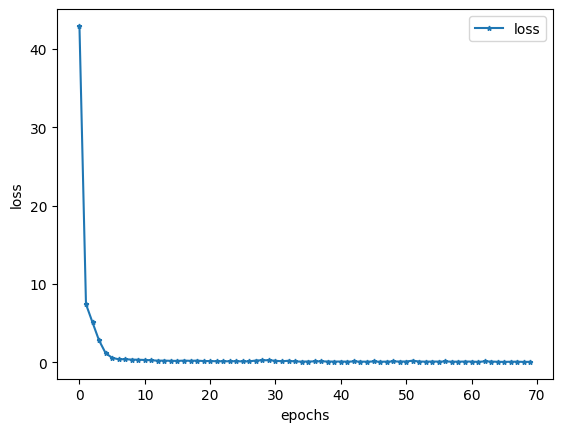

In [102]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp3, h_mlp3 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=5, num_neurons=50,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 5ms/step
  Modelo    R2   MAE  MAPE
0  MLP 3  0.97  0.48  0.02


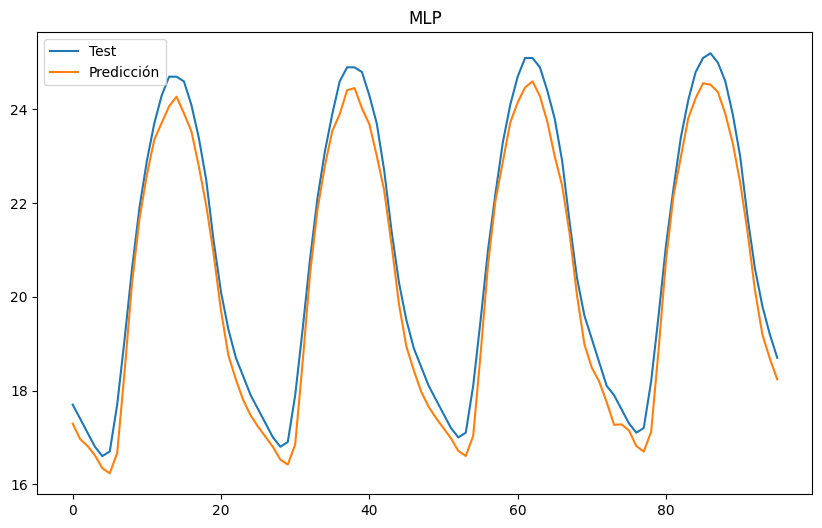

In [103]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp3 = Utils.plot_pred_test(nombre_modelo='MLP 3',
                                   title='MLP',
                                   pred=model_mlp3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones MLP**

In [104]:
errores_MLP = Utils.concat_errores([errores_mlp1, errores_mlp2, errores_mlp3])
errores_MLP

Modelo    R2   MAE  MAPE
0  MLP 2  0.99  0.27  0.01
1  MLP 3  0.97  0.48  0.02
2  MLP 1  0.94  0.54  0.03

3/3 [==============================] - 0s 4ms/step
  Modelo    R2   MAE  MAPE
0  MLP 2  0.97  0.48  0.02


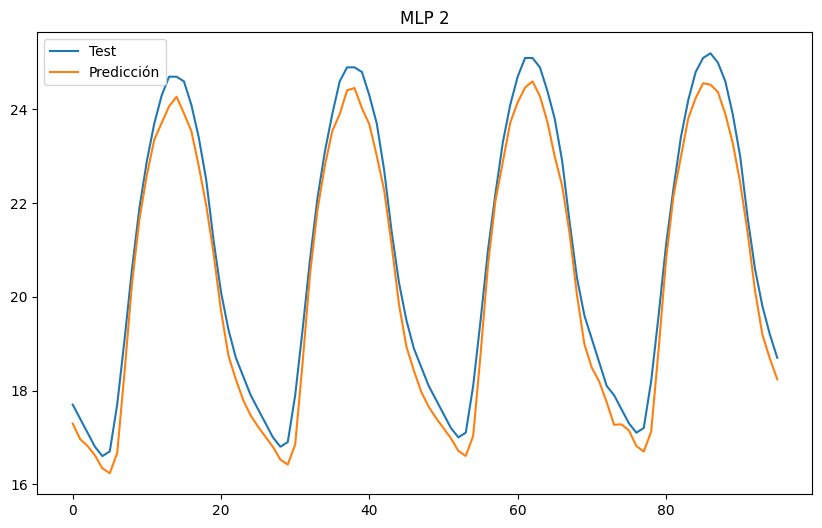

In [105]:
errores_mejor_MLP = Utils.plot_pred_test(nombre_modelo=errores_MLP['Modelo'][0],
                                         title=errores_MLP['Modelo'][0],
                                         pred=model_mlp3.predict(X_test),
                                         test=y_test)

#### 3. CNN - Convolutional Neural Network
##### 3.1. CNN 1
- Como se mencionó anteriormente, la serie tiene mucha estacionalidad muy marcada, por lo que una red CNN pequeña tendría que hacer el trabajo sin problema. Se seleccionó para empezar 2 capas convolucionales con 16 filtros de 2 y padding same, 5 capas ocultas con relu y 50 neuronas cada una.

El último estado de la métrica mae es: 1.0954


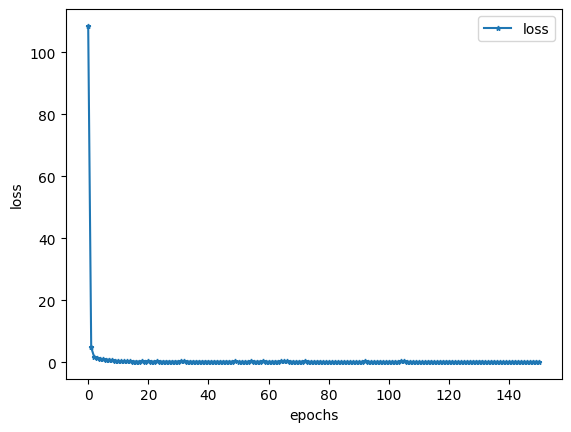

In [106]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn, h_cnn = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=2, num_filters=16, kernel_size=2, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 1  0.83  1.18  0.06


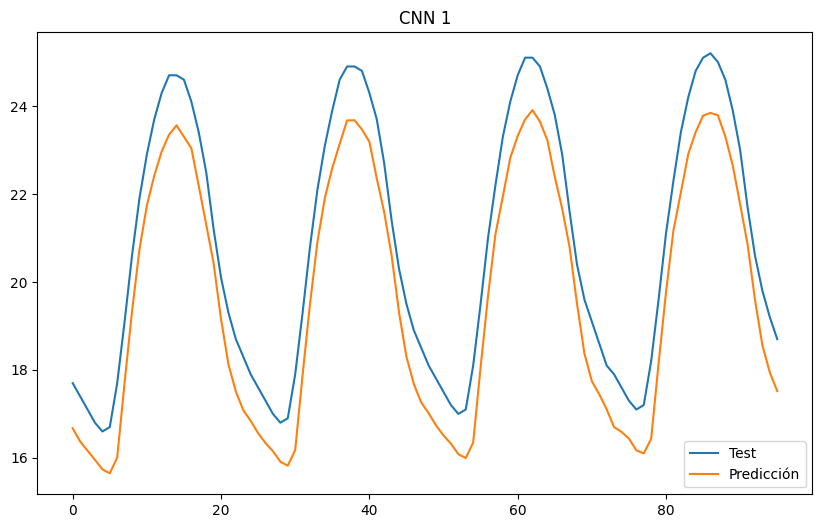

In [107]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn = Utils.plot_pred_test(nombre_modelo='CNN 1',
                                   title='CNN 1',
                                   pred=model_cnn.predict(X_test),
                                   test=y_test
                                   )

##### 3.2. CNN 2
- Agregando 2 capas convolucionales, quitando filtros y haciendo más grande el tamaño de los filtros. Buscamos que los filtros hagan un mejor trabajo.
- ASí mismo disminuimos el número de densasa para ver si funciona.

El último estado de la métrica mae es: 0.5582


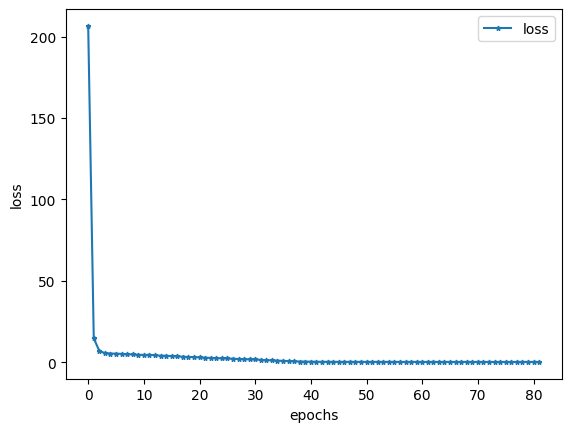

In [108]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn2, h_cnn2 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=4, num_filters=4, kernel_size=3, padding='same',
                                       activation='relu', num_layers_dense=2, num_neurons=20,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0   CNN2  0.93  0.68  0.03


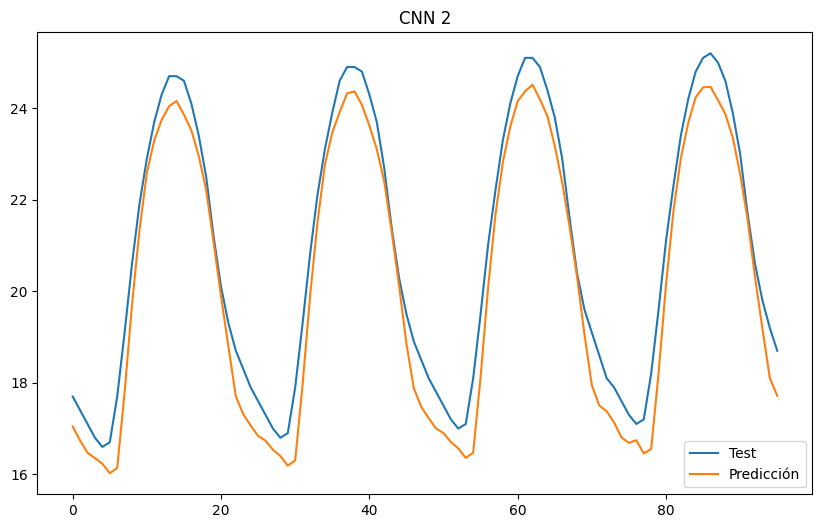

In [109]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn2 = Utils.plot_pred_test(nombre_modelo='CNN2',
                                   title='CNN 2',
                                   pred=model_cnn2.predict(X_test),
                                   test=y_test
                                   )

##### 3.3. CNN 3
- Parece ser que si funciona, aumentaremos un poco más la parte convolucioneal y también aumentaremos la parte de predicción.
- 10 capas convolucionales con 8 filtros y tamaño de 5.
- 5 capas ocultas y 50 neuronas
- Bajando el LR para bajar en la cola un poco más e intentar llegar un poco más abajo en la función de perdida.

El último estado de la métrica mae es: 0.3876


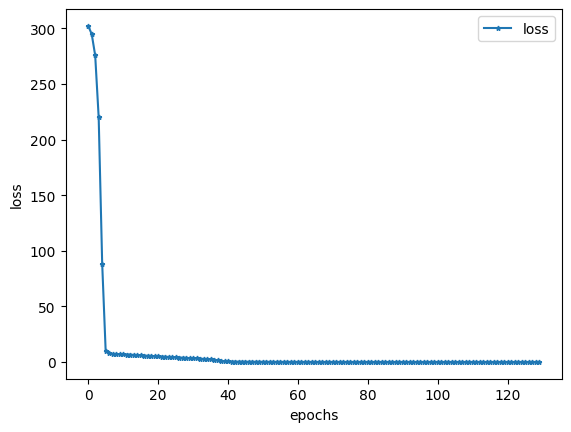

In [110]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn3, h_cnn3 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=10, num_filters=8, kernel_size=5, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 4ms/step
  Modelo    R2   MAE  MAPE
0  CNN 3  0.96  0.47  0.02


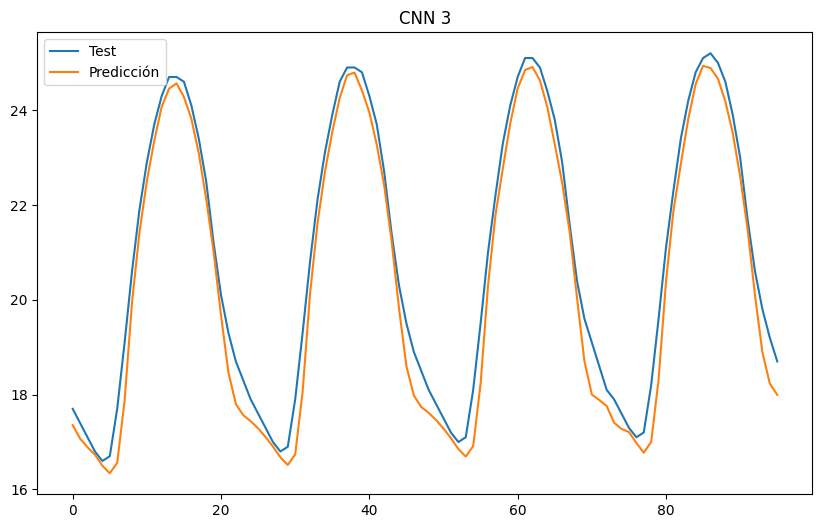

In [111]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn3 = Utils.plot_pred_test(nombre_modelo='CNN 3',
                                   title='CNN 3',
                                   pred=model_cnn3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones CNN**

In [112]:
errores_CNN = Utils.concat_errores([errores_cnn, errores_cnn2, errores_cnn3])
errores_CNN

Modelo    R2   MAE  MAPE
0  CNN 3  0.96  0.47  0.02
1   CNN2  0.93  0.68  0.03
2  CNN 1  0.83  1.18  0.06

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 3  0.83  1.18  0.06


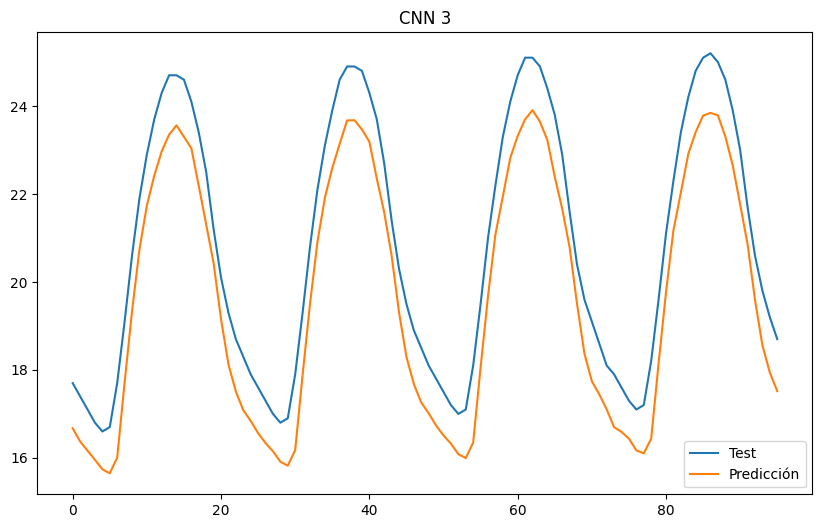

In [113]:
errores_mejor_CNN = Utils.plot_pred_test(nombre_modelo=errores_CNN['Modelo'][0],
                                         title=errores_CNN['Modelo'][0],
                                         pred=model_cnn.predict(X_test),
                                         test=y_test)

- Podemos ver que el aumento de la parte convolucional, sin embargo al aumentarla todavía más no logramos mejorar el rendimiento, por lo que seleccioné el 2 ya que es menos complejo.

#### 4. LSTM
- Para poder usar LSTM tenemos que convertir nuestros datos a tensor, por lo que rehacemos los split y Train y test.

In [114]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor
X_tens, y_tens = Utils.split_univariate_sequence(sequence=h251,
                                                 column='H251',
                                                 n_steps=5,
                                                 tensor=True,
                                                 n_features=1)

	- Forma de X: (955, 5, 1)
	- Forma de y: (955,)


In [115]:
# Dividiendo los datos en train y test
X_train_tens, X_test_tens, y_train_tens, y_test_tens = Utils.split_train_test(X=X_tens,
                                                                    y=y_tens,
                                                                    train_size=0.9
                                                                    )

- X:
	- X_train: (859, 5, 1)
	- X_test: (96, 5, 1)
- y:
	- y_train: (859,)
	- y_test: (96,)


##### 4.1 LSTM

El último estado de la métrica mae es: 0.1411


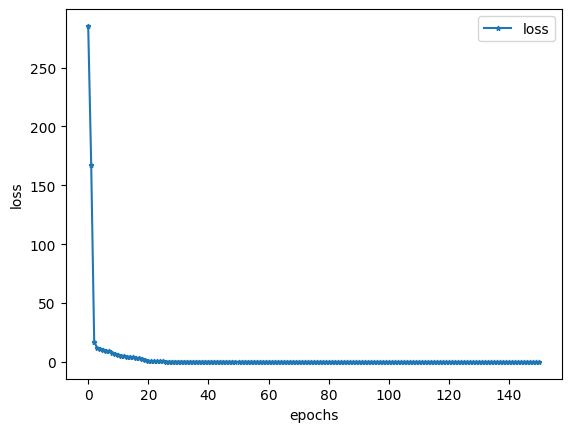

In [116]:
# Creando el modelo LSTM con 2 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm, h_lstm = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=2, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 1s 5ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.17  0.01


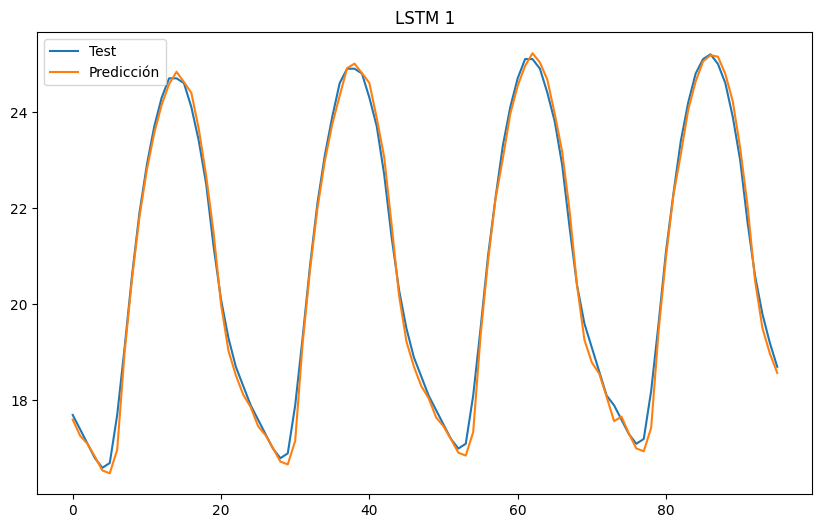

In [117]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm = Utils.plot_pred_test(nombre_modelo='LSTM 1',
                                   title='LSTM 1',
                                   pred=model_lstm.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.2 LSTM
- Aumentando capas de LSTM para ver si mejora
- 4 capas densas en vez de 2

El último estado de la métrica mae es: 0.3365


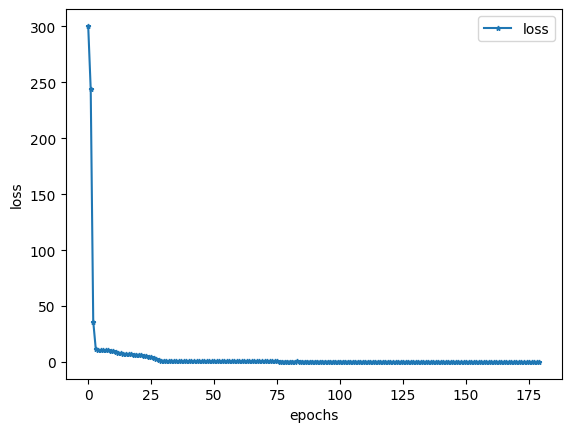

In [118]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm2, h_lstm2 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=4, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 3s 7ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 2  0.98  0.37  0.02


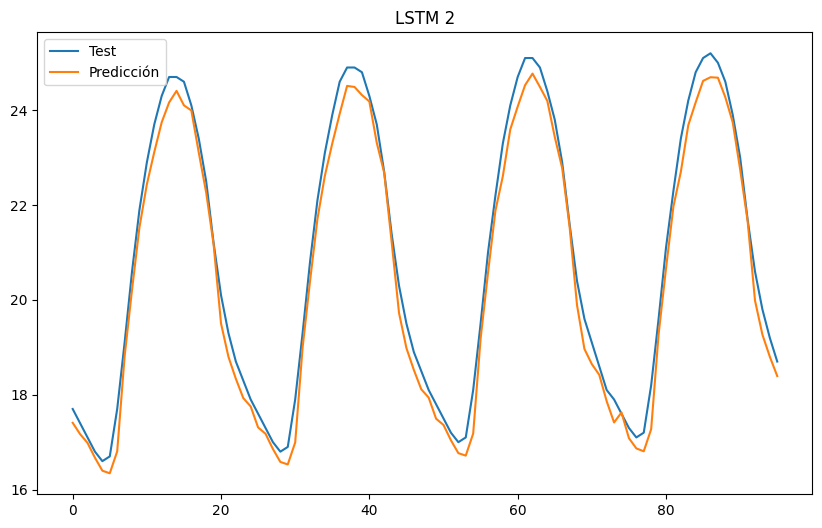

In [119]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm2 = Utils.plot_pred_test(nombre_modelo='LSTM 2',
                                   title='LSTM 2',
                                   pred=model_lstm2.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.3 LSTM

El último estado de la métrica mae es: 0.2691


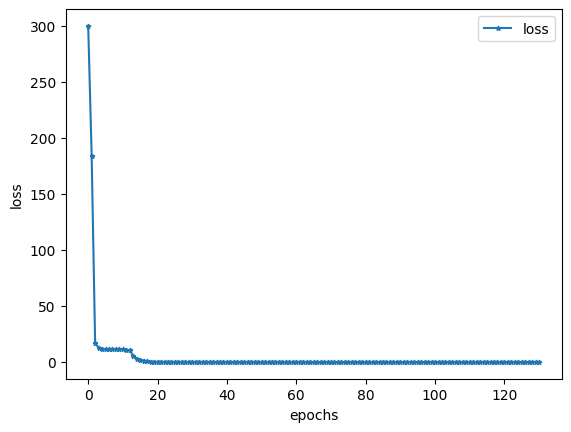

In [120]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm3, h_lstm3 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50, bidireccional=True,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 5s 17ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 3  0.97  0.42  0.02


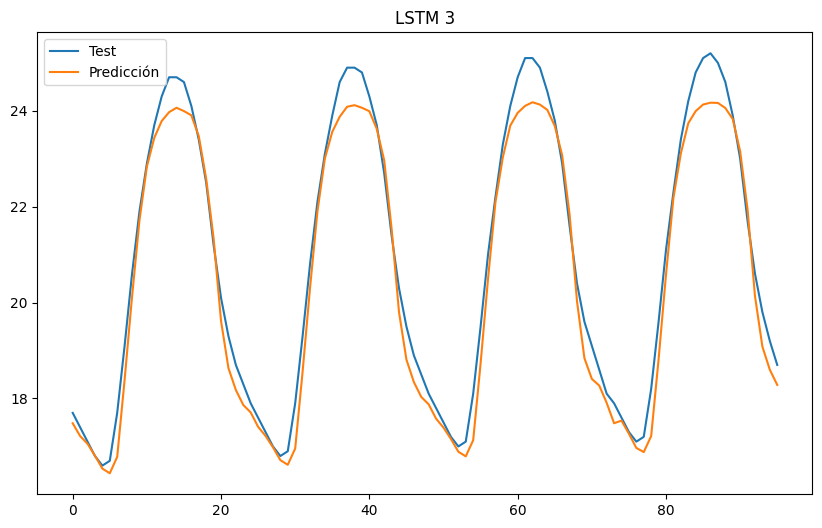

In [121]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm3 = Utils.plot_pred_test(nombre_modelo='LSTM 3',
                                   title='LSTM 3',
                                   pred=model_lstm3.predict(X_test_tens),
                                   test=y_test
                                   )

**Conclusiones**

In [122]:
errores_LSTM = Utils.concat_errores([errores_lstm, errores_lstm2, errores_lstm3])
errores_LSTM

Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.17  0.01
1  LSTM 2  0.98  0.37  0.02
2  LSTM 3  0.97  0.42  0.02

3/3 [==============================] - 0s 8ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 1  0.98  0.37  0.02


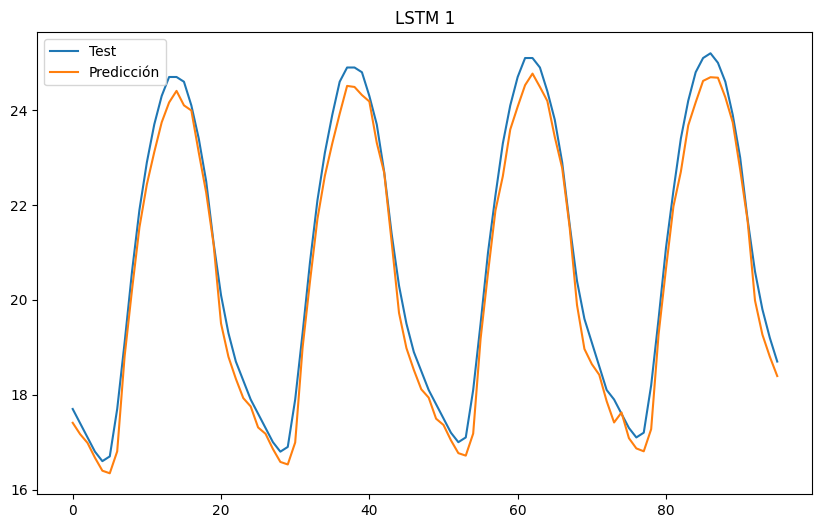

In [123]:
# Obteniendo los errores y ploteando predicciones vs test
mejor_lstm = Utils.plot_pred_test(nombre_modelo=errores_LSTM['Modelo'][0],
                                  title=errores_LSTM['Modelo'][0],
                                  pred=model_lstm2.predict(X_test_tens),
                                  test=y_test)

- Tenemos un error casi nulo, sorprendemente mientras más aumentabamos las capas o la cantidad de unidades por cada (como en el caso 1 y 2 no bajo el error, parece ser que es un muy buen modelo)

#### 5. CNN - LSTM
##### 5.1. CNN - LSTM

In [124]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor con 6 pasos
X_tens2, y_tens2 = Utils.split_univariate_sequence(sequence=h229,
                                                 column='H229',
                                                 n_steps=6,
                                                 tensor=True,
                                                 n_features=1)

# Dividiendo los datos en train y test
X_train_tens2, X_test_tens2, y_train_tens2, y_test_tens2 = Utils.split_train_test(X=X_tens2,
                                                                                  y=y_tens2,
                                                                                  train_size=0.9
                                                                                    )

# Cambiando el shape del X_train_tens y X_test_tens
n_seq = 2
n_steps = 3
n_features = 1

# Cambiando el shape del X_train_tens y X_test_tens
X_train_tens2 = X_train_tens2.reshape((X_train_tens2.shape[0], n_seq, n_steps, n_features))
X_test_tens2 = X_test_tens2.reshape((X_test_tens2.shape[0], n_seq, n_steps, n_features))

	- Forma de X: (954, 6, 1)
	- Forma de y: (954,)
- X:
	- X_train: (858, 6, 1)
	- X_test: (96, 6, 1)
- y:
	- y_train: (858,)
	- y_test: (96,)


El último estado de la métrica mae es: 0.4095


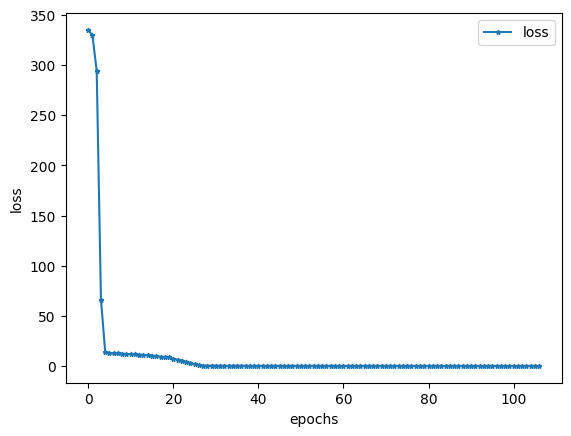

In [125]:
model_cnn_lstm1, h1_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=4, num_filters=16, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 7ms/step
         Modelo    R2   MAE  MAPE
0  CNN - LSTM 1  0.98  0.43  0.02


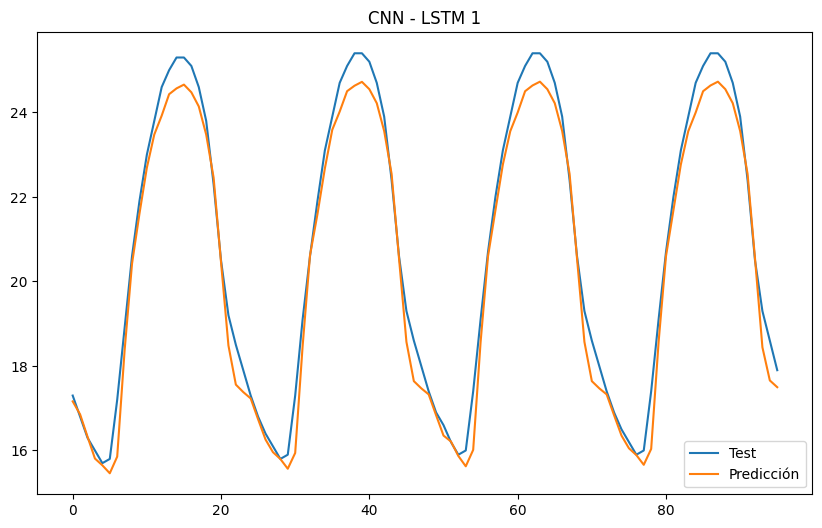

In [126]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 1',
                                          title='CNN - LSTM 1',
                                          pred=model_cnn_lstm1.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.2 CNN - LSTM 2

El último estado de la métrica mae es: 0.2593


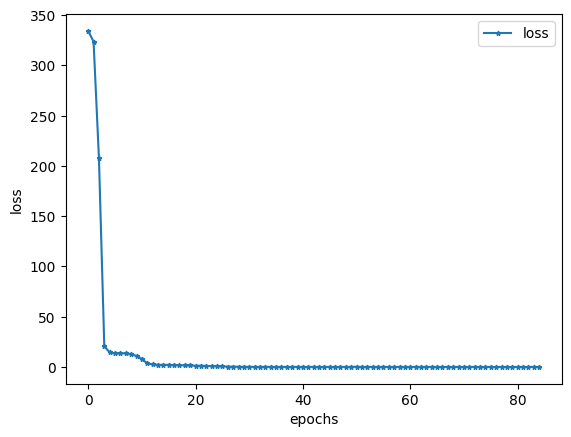

In [127]:
model_cnn_lstm2, h2_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=2, num_filters=32, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 6s 9ms/step
         Modelo    R2   MAE  MAPE
0  CNN - LSTM 2  0.99  0.28  0.01


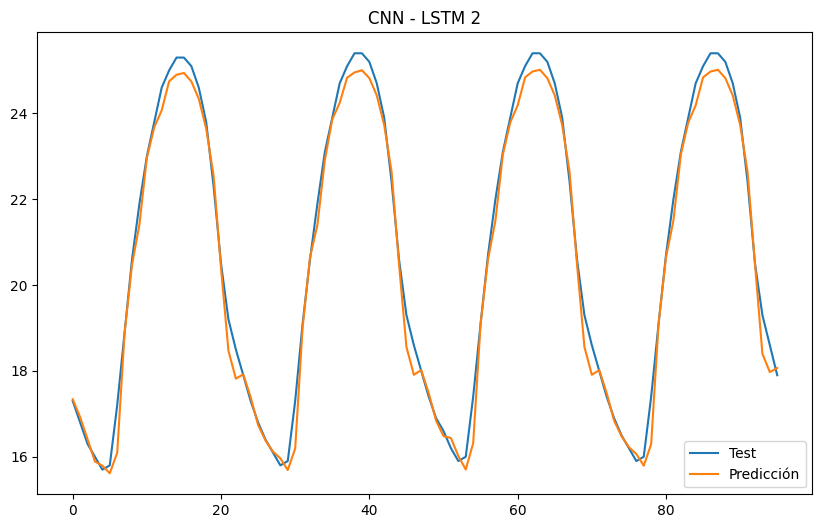

In [128]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 2',
                                          title='CNN - LSTM 2',
                                          pred=model_cnn_lstm2.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.3 CNN - LSTM 3

El último estado de la métrica mae es: 17.147


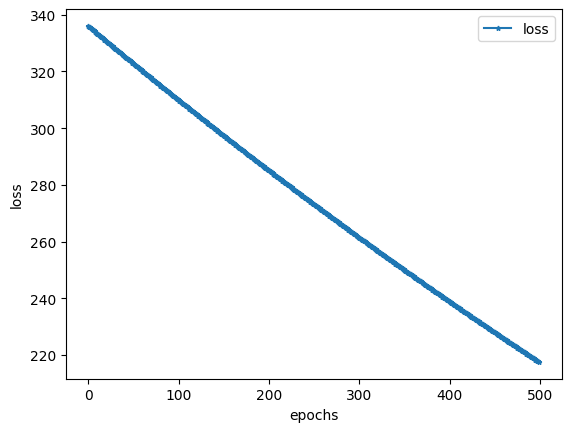

In [129]:
model_cnn_lstm3, h3_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=8, num_filters=4, kernel_size=4, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 10ms/step
         Modelo     R2    MAE  MAPE
0  CNN - LSTM 3 -24.48  17.04  0.82


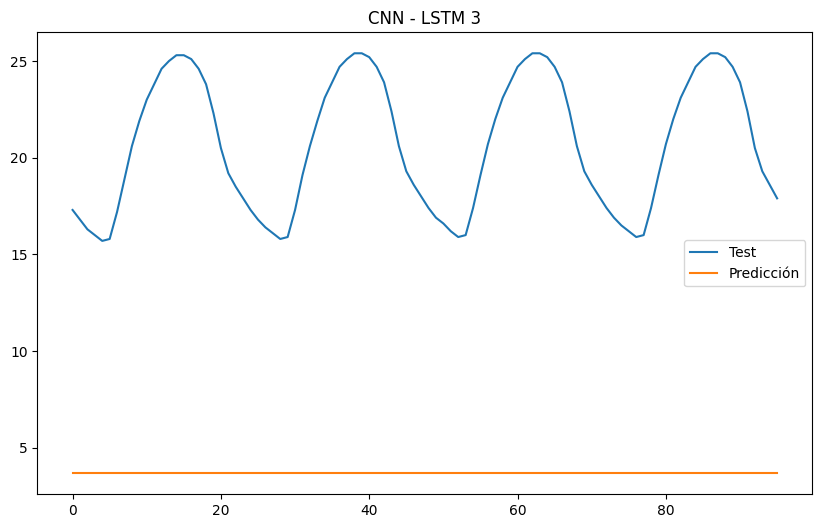

In [130]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 3',
                                          title='CNN - LSTM 3',
                                          pred=model_cnn_lstm3.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

**Conclusiones**

In [131]:
errores_cnn_lstm = Utils.concat_errores([errores_cnn_lstm1, errores_cnn_lstm2, errores_cnn_lstm3])
errores_cnn_lstm

Modelo     R2     MAE   MAPE
0  CNN - LSTM 3   0.98   56.01   0.48
1  CNN - LSTM 2  -0.23  777.95  18.83
2  CNN - LSTM 3 -24.48   17.04   0.82

3/3 [==============================] - 0s 9ms/step
         Modelo   R2   MAE  MAPE
0  CNN - LSTM 3  0.9  0.77  0.04


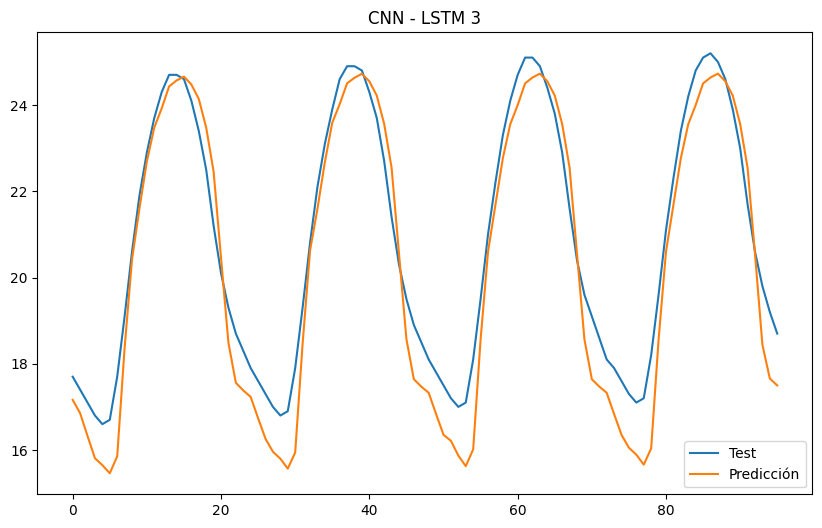

In [132]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mejor_CNN_LSTM = Utils.plot_pred_test(nombre_modelo=errores_cnn_lstm['Modelo'][0],
                                  title=errores_cnn_lstm['Modelo'][0],
                                  pred=model_cnn_lstm1.predict(X_test_tens2),
                                  test=y_test)

**Sacando el mejor modelo**

In [133]:
mejores_modelos = Utils.concat_errores([errores_mejor_MLP, errores_mejor_CNN, errores_mejor_lstm, errores_mejor_CNN_LSTM]).sort_values(by='MAE')
mejores_modelos

Modelo    R2    MAE  MAPE
0         MLP 2  0.97   0.48  0.02
1  CNN - LSTM 3  0.90   0.77  0.04
2         CNN 3  0.83   1.18  0.06
3        LSTM 2  0.03  16.86  0.38

- El mejor modelo es el MLP, por lo que es el que haremos la predicción

2/2 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  MLP 2  0.99  0.27  0.01


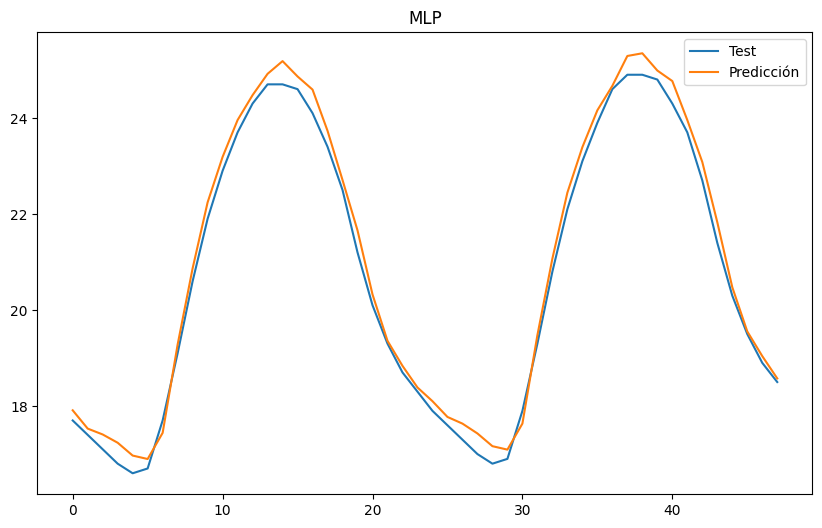

In [134]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp2 = Utils.plot_pred_test(nombre_modelo='MLP 2',
                                   title='MLP',
                                   pred=model_mlp2.predict(X_test[:48]),
                                   test=y_test[:48]
                                   )

- No se hizo ajuste de hiperparámetros ya que tenemos un r2 de 0.99, lo cual buscar mejorarlo es overfitearlo y desperdiciar poder de computo.

____
### 2.4. Serie H300

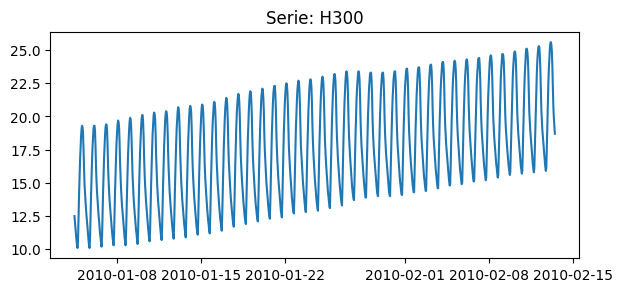

In [135]:
Utils.plot_series([h300], ['H300'])

#### 1. Preprocesamiento de los datos
- Al tener una serie que es bastante Estacional (que se repite mucho los patrones cada cierto tiempo), no veo necesario hacer un procesamiento de los datos, además de que parecen ser que son bastante simétricos.

In [136]:
# Dandole formato a la serie de tiempo
X, y = Utils.split_univariate_sequence(sequence=h300, 
                                       column='H300', 
                                       n_steps=5, 
                                       tensor=False,
                                       )

	- Forma de X: (955, 5)
	- Forma de y: (955,)


- Se seleccionó *n_steps = 5*, porque tenemos una serie de tiempo con bajadas y subidas constantes así que seleccionamos un número mediano para poder saber si es una bajada prolongada o solo es una bajada y subida y poder aprender esa estacionalidad de la serie.

In [137]:
# Separando los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = Utils.split_train_test(X=X, 
                                                          y=y, 
                                                          train_size=0.9)

- X:
	- X_train: (859, 5)
	- X_test: (96, 5)
- y:
	- y_train: (859,)
	- y_test: (96,)


#### 2. MLP - Multy Layer Perceptron
##### 2.1 MLP
- 2 Capas ocultas con 20 neuronas

El último estado de la métrica mae es: 0.376


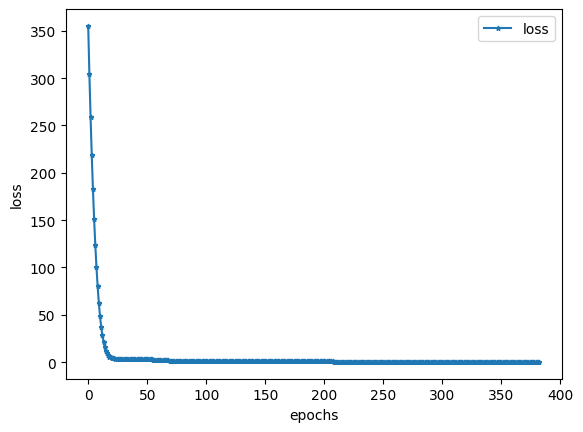

In [138]:
# Creando el modelo MLP con 5 capas ocultas de 50 neuronas
model_mlp1, h_mlp1 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=2, num_neurons=20,
                                         optimizer='Adam', lr=0.0001, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)


3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  MLP 1  0.97  0.42  0.02


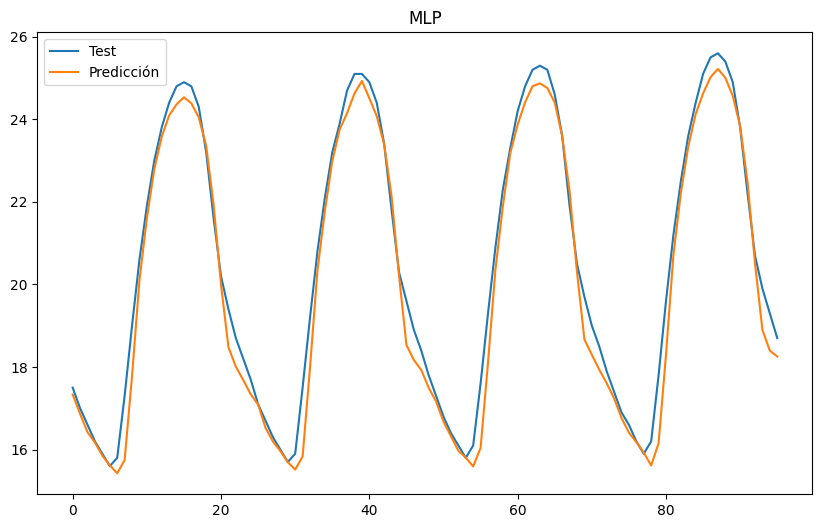

In [139]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp1 = Utils.plot_pred_test(nombre_modelo='MLP 1',
                                   title='MLP',
                                   pred=model_mlp1.predict(X_test),
                                   test=y_test
                                   )

##### 2.2 MLP
- 4 Capas ocultas con 30 neuronas

El último estado de la métrica mae es: 0.4672


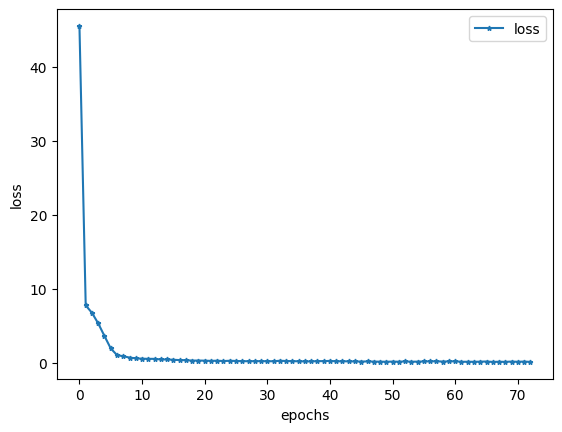

In [140]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp2, h_mlp2 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=4, num_neurons=30,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  MLP 2  0.96  0.54  0.03


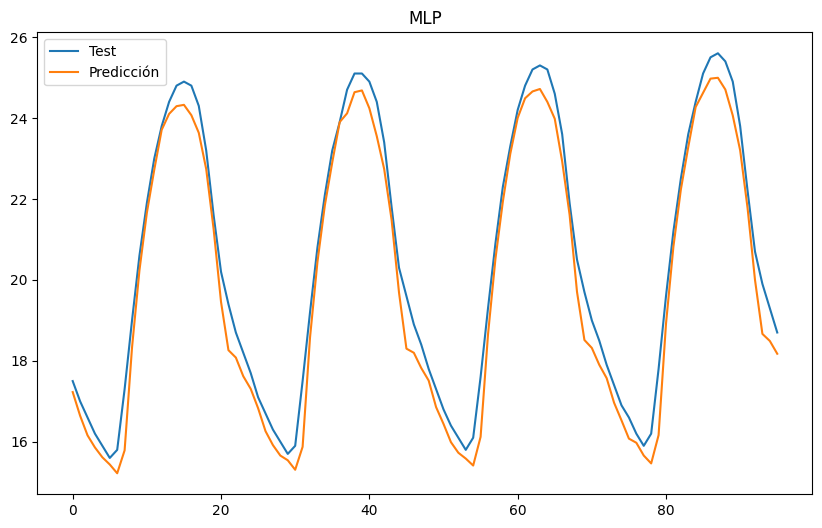

In [141]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp2 = Utils.plot_pred_test(nombre_modelo='MLP 2',
                                   title='MLP',
                                   pred=model_mlp2.predict(X_test),
                                   test=y_test
                                   )

##### 2.3 MLP
- 5 Capas ocultas con 50 neuronas

El último estado de la métrica mae es: 0.7137


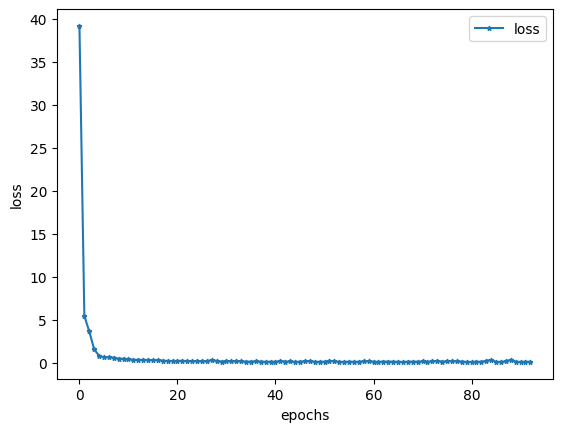

In [142]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp3, h_mlp3 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=5, num_neurons=50,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2  MAE  MAPE
0  MLP 3  0.94  0.8  0.04


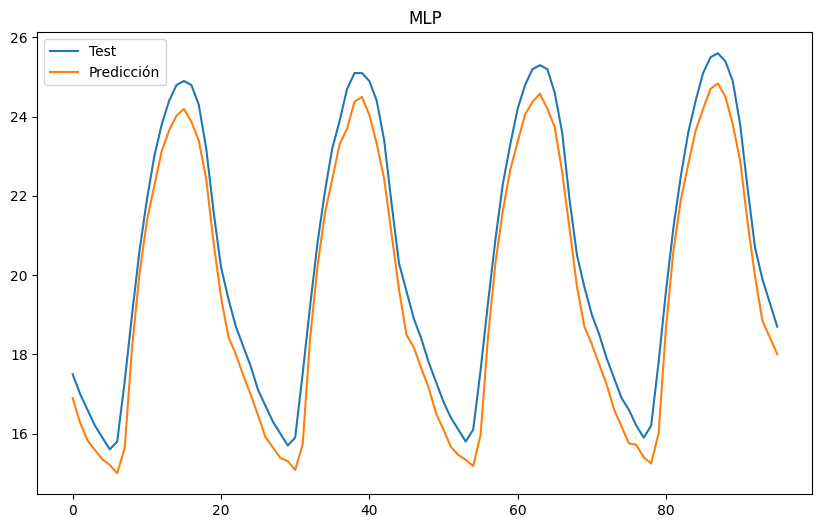

In [143]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp3 = Utils.plot_pred_test(nombre_modelo='MLP 3',
                                   title='MLP',
                                   pred=model_mlp3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones MLP**

In [144]:
errores_MLP = Utils.concat_errores([errores_mlp1, errores_mlp2, errores_mlp3])
errores_MLP

Modelo    R2   MAE  MAPE
0  MLP 1  0.97  0.42  0.02
1  MLP 2  0.96  0.54  0.03
2  MLP 3  0.94  0.80  0.04

3/3 [==============================] - 0s 2ms/step
  Modelo    R2   MAE  MAPE
0  MLP 1  0.97  0.42  0.02


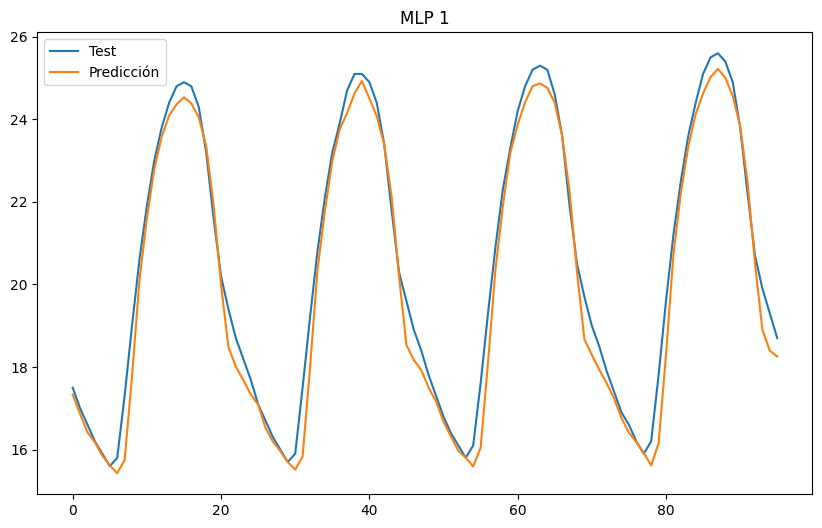

In [145]:
errores_mejor_MLP = Utils.plot_pred_test(nombre_modelo=errores_MLP['Modelo'][0],
                                         title=errores_MLP['Modelo'][0],
                                         pred=model_mlp1.predict(X_test),
                                         test=y_test)

#### 3. CNN - Convolutional Neural Network
##### 3.1. CNN 1
- Como se mencionó anteriormente, la serie tiene mucha estacionalidad muy marcada, por lo que una red CNN pequeña tendría que hacer el trabajo sin problema. Se seleccionó para empezar 2 capas convolucionales con 16 filtros de 2 y padding same, 5 capas ocultas con relu y 50 neuronas cada una.

El último estado de la métrica mae es: 0.3909


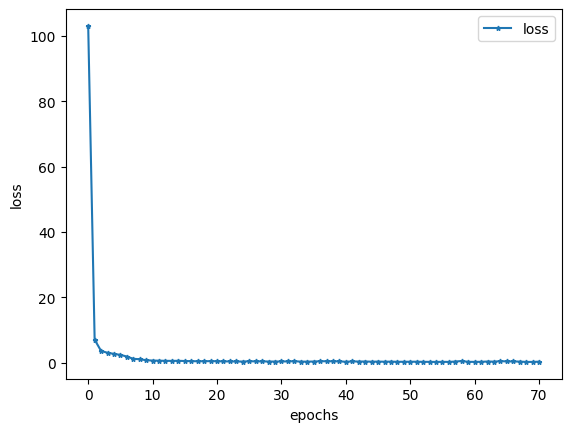

In [146]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn, h_cnn = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=2, num_filters=16, kernel_size=2, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 1  0.96  0.46  0.02


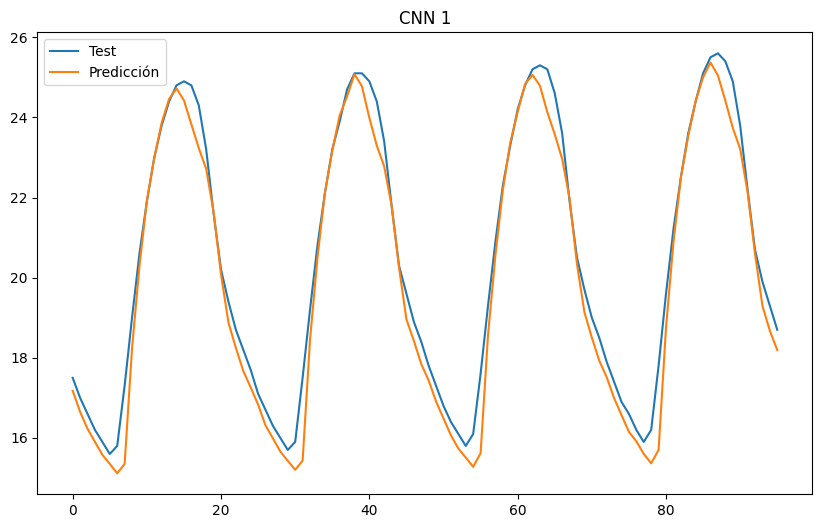

In [147]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn = Utils.plot_pred_test(nombre_modelo='CNN 1',
                                   title='CNN 1',
                                   pred=model_cnn.predict(X_test),
                                   test=y_test
                                   )

##### 3.2. CNN 2
- Agregando 2 capas convolucionales, quitando filtros y haciendo más grande el tamaño de los filtros. Buscamos que los filtros hagan un mejor trabajo.
- ASí mismo disminuimos el número de densasa para ver si funciona.

El último estado de la métrica mae es: 0.8073


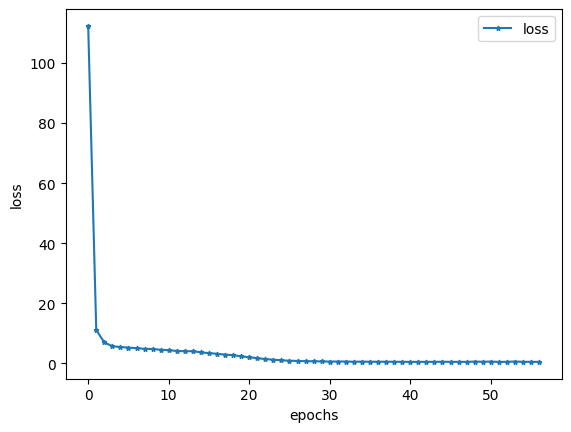

In [148]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn2, h_cnn2 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=4, num_filters=4, kernel_size=3, padding='same',
                                       activation='relu', num_layers_dense=2, num_neurons=20,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 2ms/step
  Modelo    R2   MAE  MAPE
0   CNN2  0.88  0.97  0.05


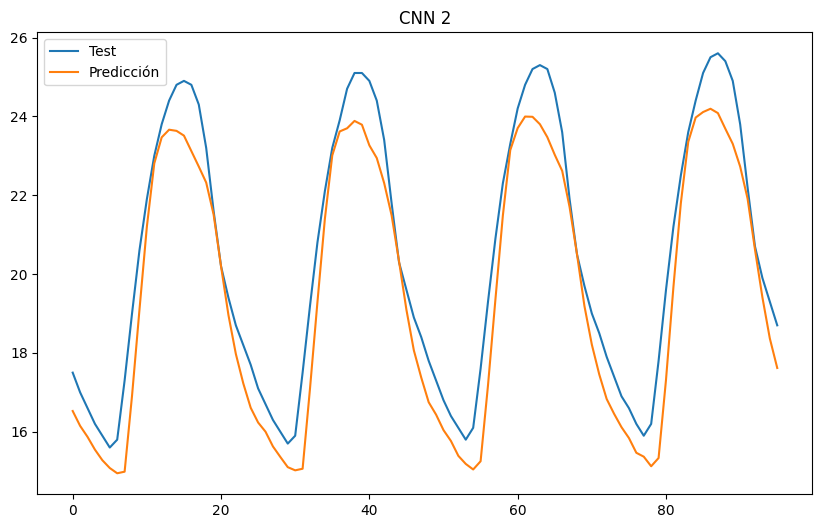

In [149]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn2 = Utils.plot_pred_test(nombre_modelo='CNN2',
                                   title='CNN 2',
                                   pred=model_cnn2.predict(X_test),
                                   test=y_test
                                   )

##### 3.3. CNN 3
- Parece ser que si funciona, aumentaremos un poco más la parte convolucioneal y también aumentaremos la parte de predicción.
- 10 capas convolucionales con 8 filtros y tamaño de 5.
- 5 capas ocultas y 50 neuronas
- Bajando el LR para bajar en la cola un poco más e intentar llegar un poco más abajo en la función de perdida.

El último estado de la métrica mae es: 0.7993


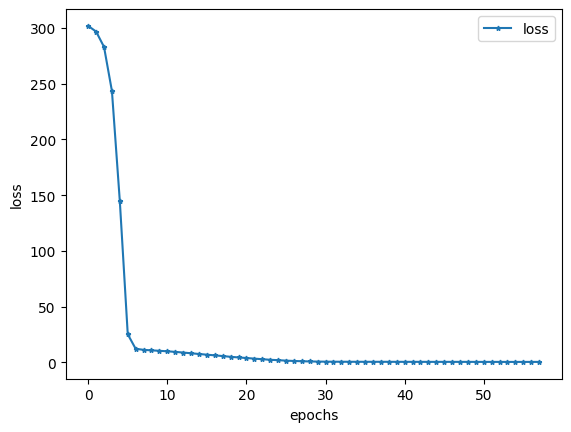

In [150]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn3, h_cnn3 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=10, num_filters=8, kernel_size=5, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo   R2   MAE  MAPE
0  CNN 3  0.9  0.93  0.05


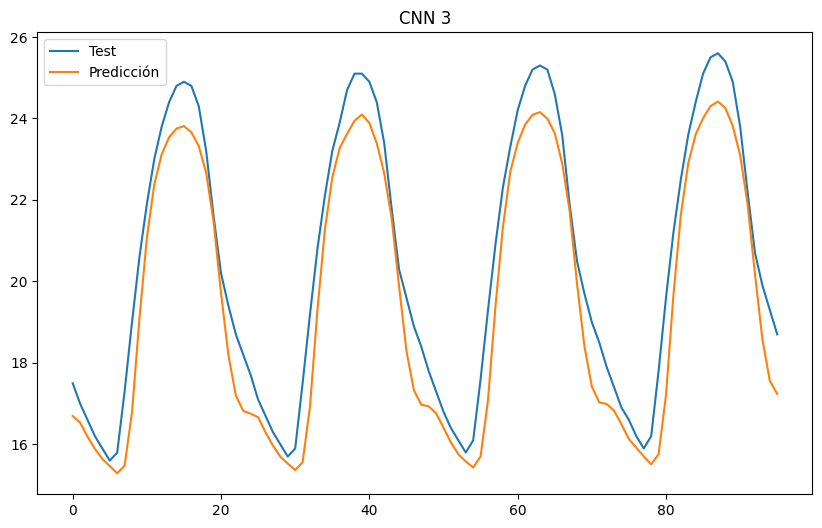

In [151]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn3 = Utils.plot_pred_test(nombre_modelo='CNN 3',
                                   title='CNN 3',
                                   pred=model_cnn3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones CNN**

In [152]:
errores_CNN = Utils.concat_errores([errores_cnn, errores_cnn2, errores_cnn3])
errores_CNN

Modelo    R2   MAE  MAPE
0  CNN 1  0.96  0.46  0.02
1  CNN 3  0.90  0.93  0.05
2   CNN2  0.88  0.97  0.05

3/3 [==============================] - 0s 3ms/step
  Modelo    R2   MAE  MAPE
0  CNN 1  0.96  0.46  0.02


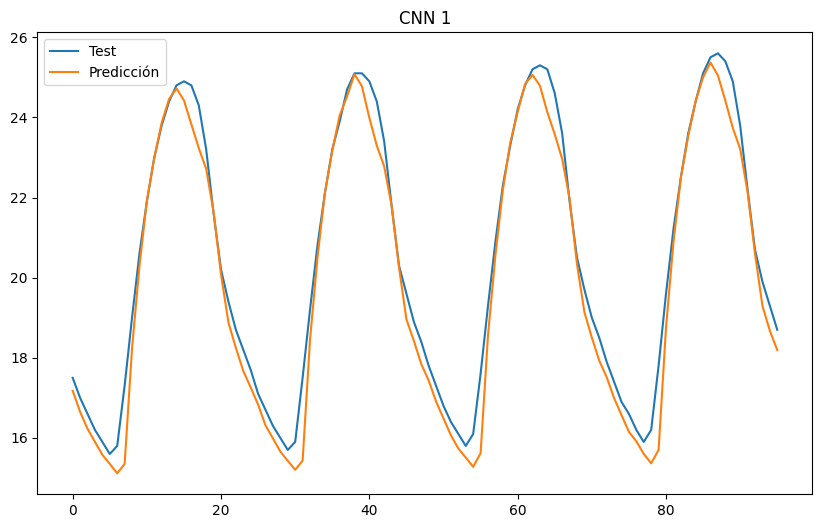

In [153]:
errores_mejor_CNN = Utils.plot_pred_test(nombre_modelo=errores_CNN['Modelo'][0],
                                         title=errores_CNN['Modelo'][0],
                                         pred=model_cnn.predict(X_test),
                                         test=y_test)

- Podemos ver que el aumento de la parte convolucional, sin embargo al aumentarla todavía más no logramos mejorar el rendimiento, por lo que seleccioné el 2 ya que es menos complejo.

#### 4. LSTM
- Para poder usar LSTM tenemos que convertir nuestros datos a tensor, por lo que rehacemos los split y Train y test.

In [154]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor
X_tens, y_tens = Utils.split_univariate_sequence(sequence=h300,
                                                 column='H300',
                                                 n_steps=5,
                                                 tensor=True,
                                                 n_features=1)

	- Forma de X: (955, 5, 1)
	- Forma de y: (955,)


In [155]:
# Dividiendo los datos en train y test
X_train_tens, X_test_tens, y_train_tens, y_test_tens = Utils.split_train_test(X=X_tens,
                                                                    y=y_tens,
                                                                    train_size=0.9
                                                                    )

- X:
	- X_train: (859, 5, 1)
	- X_test: (96, 5, 1)
- y:
	- y_train: (859,)
	- y_test: (96,)


##### 4.1 LSTM

El último estado de la métrica mae es: 0.1969


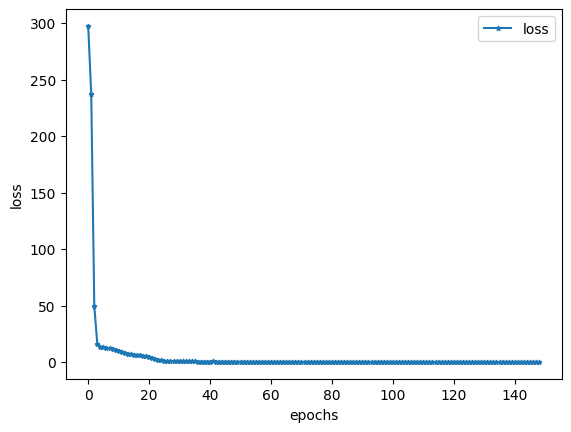

In [156]:
# Creando el modelo LSTM con 2 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm, h_lstm = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=2, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 1s 6ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.21  0.01


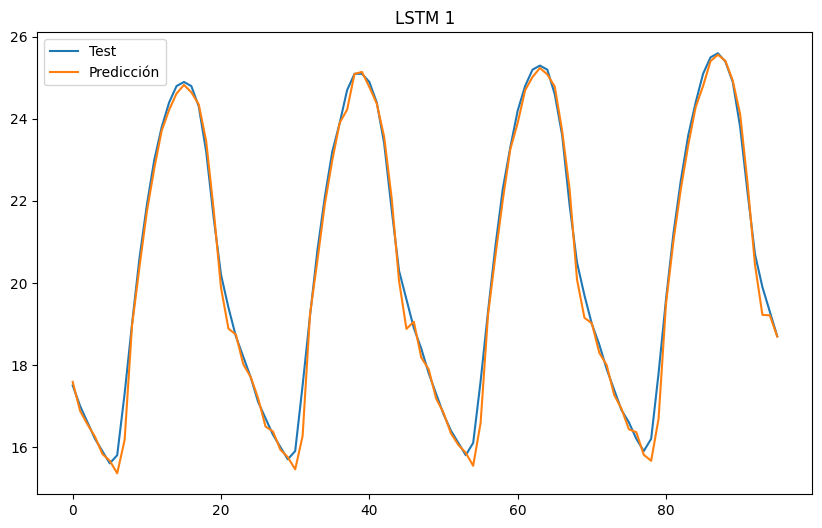

In [157]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm = Utils.plot_pred_test(nombre_modelo='LSTM 1',
                                   title='LSTM 1',
                                   pred=model_lstm.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.2 LSTM
- Aumentando capas de LSTM para ver si mejora
- 4 capas densas en vez de 2

El último estado de la métrica mae es: 0.284


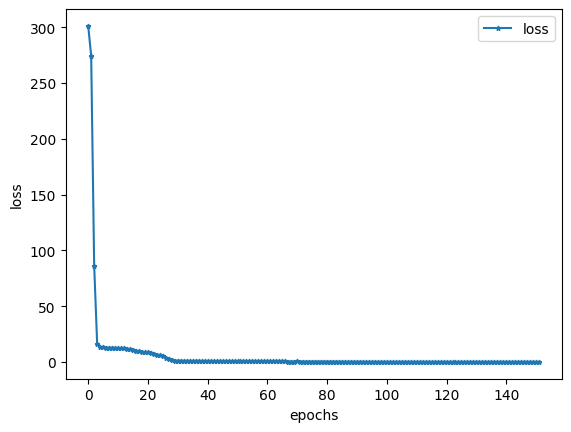

In [158]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm2, h_lstm2 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=4, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 2s 8ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 2  0.99  0.31  0.02


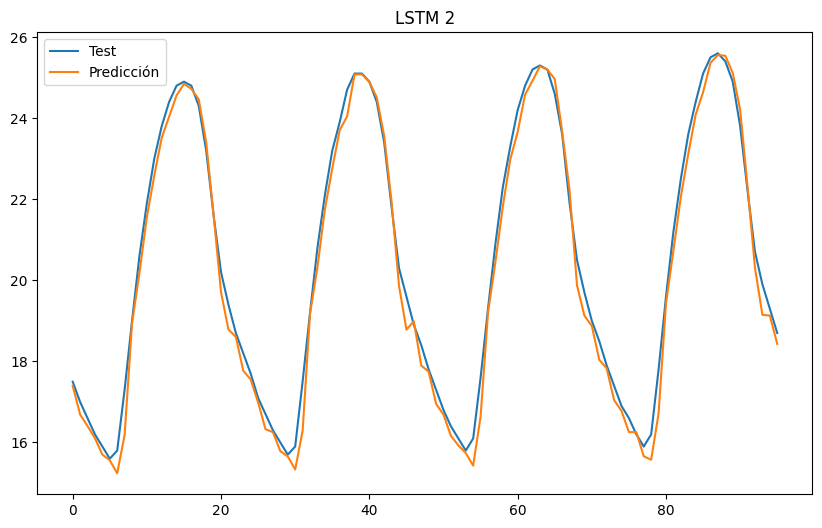

In [159]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm2 = Utils.plot_pred_test(nombre_modelo='LSTM 2',
                                   title='LSTM 2',
                                   pred=model_lstm2.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.3 LSTM

El último estado de la métrica mae es: 0.2759


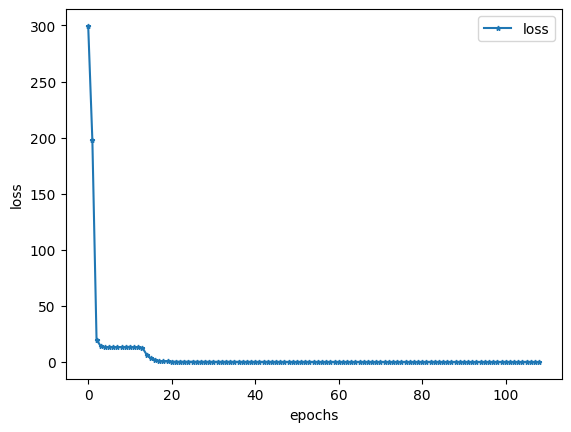

In [160]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm3, h_lstm3 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50, bidireccional=True,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 5s 22ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 3  0.98  0.34  0.02


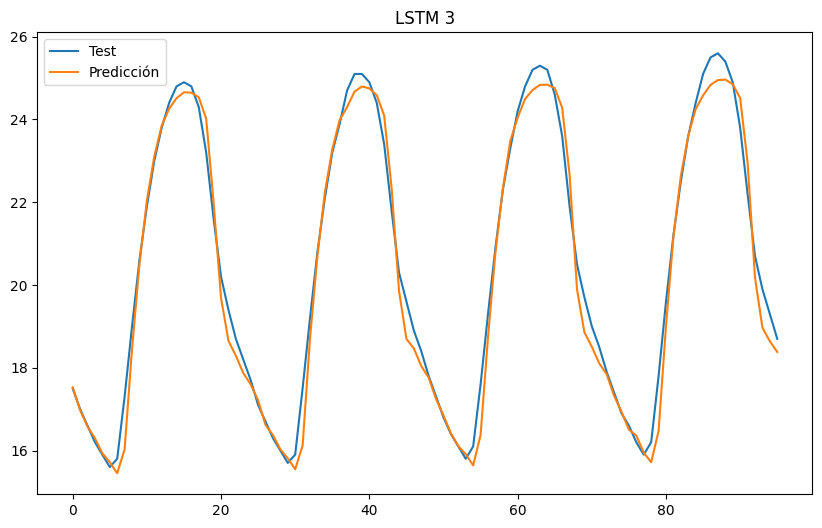

In [161]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm3 = Utils.plot_pred_test(nombre_modelo='LSTM 3',
                                   title='LSTM 3',
                                   pred=model_lstm3.predict(X_test_tens),
                                   test=y_test
                                   )

**Conclusiones**

In [162]:
errores_LSTM = Utils.concat_errores([errores_lstm, errores_lstm2, errores_lstm3])
errores_LSTM

Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.21  0.01
1  LSTM 2  0.99  0.31  0.02
2  LSTM 3  0.98  0.34  0.02

3/3 [==============================] - 0s 9ms/step
   Modelo    R2   MAE  MAPE
0  LSTM 1  0.99  0.31  0.02


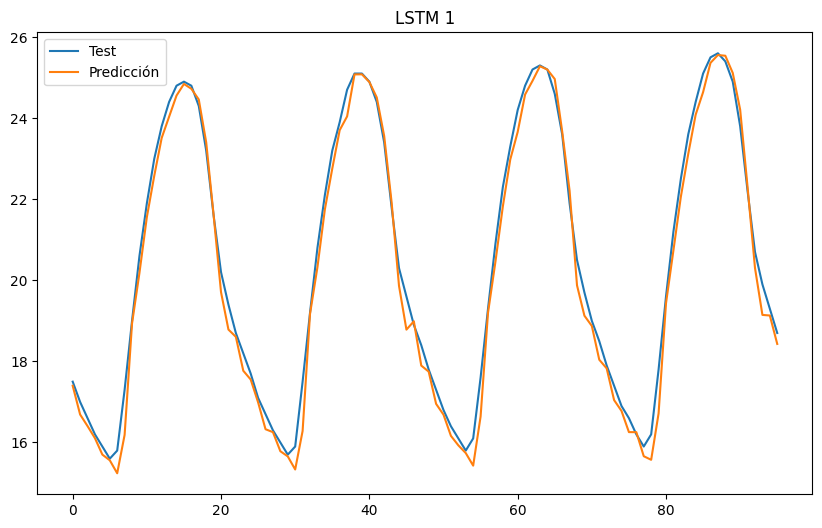

In [163]:
# Obteniendo los errores y ploteando predicciones vs test
mejor_lstm = Utils.plot_pred_test(nombre_modelo=errores_LSTM['Modelo'][0],
                                  title=errores_LSTM['Modelo'][0],
                                  pred=model_lstm2.predict(X_test_tens),
                                  test=y_test)

- Tenemos un error casi nulo, sorprendemente mientras más aumentabamos las capas o la cantidad de unidades por cada (como en el caso 1 y 2 no bajo el error, parece ser que es un muy buen modelo)

#### 5. CNN - LSTM
##### 5.1. CNN - LSTM

In [164]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor con 6 pasos
X_tens2, y_tens2 = Utils.split_univariate_sequence(sequence=h229,
                                                 column='H229',
                                                 n_steps=6,
                                                 tensor=True,
                                                 n_features=1)

# Dividiendo los datos en train y test
X_train_tens2, X_test_tens2, y_train_tens2, y_test_tens2 = Utils.split_train_test(X=X_tens2,
                                                                                  y=y_tens2,
                                                                                  train_size=0.9
                                                                                    )

# Cambiando el shape del X_train_tens y X_test_tens
n_seq = 2
n_steps = 3
n_features = 1

# Cambiando el shape del X_train_tens y X_test_tens
X_train_tens2 = X_train_tens2.reshape((X_train_tens2.shape[0], n_seq, n_steps, n_features))
X_test_tens2 = X_test_tens2.reshape((X_test_tens2.shape[0], n_seq, n_steps, n_features))

	- Forma de X: (954, 6, 1)
	- Forma de y: (954,)
- X:
	- X_train: (858, 6, 1)
	- X_test: (96, 6, 1)
- y:
	- y_train: (858,)
	- y_test: (96,)


El último estado de la métrica mae es: 0.3274


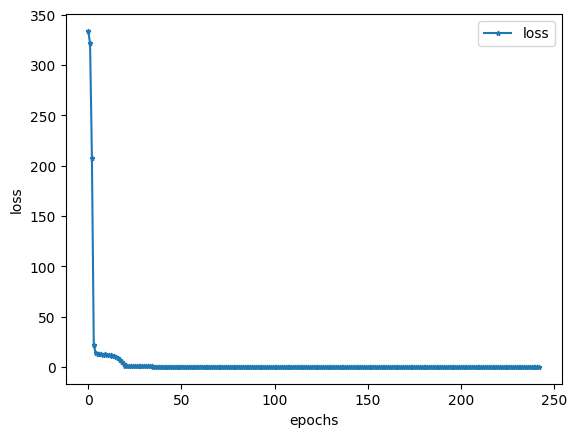

In [165]:
model_cnn_lstm1, h1_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=4, num_filters=16, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 7ms/step
         Modelo    R2   MAE  MAPE
0  CNN - LSTM 1  0.99  0.33  0.02


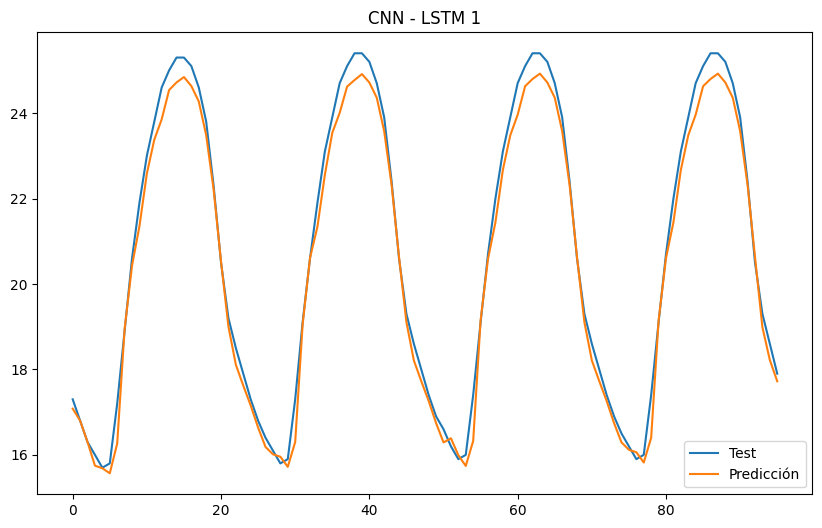

In [166]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 1',
                                          title='CNN - LSTM 1',
                                          pred=model_cnn_lstm1.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.2 CNN - LSTM 2

El último estado de la métrica mae es: 0.2552


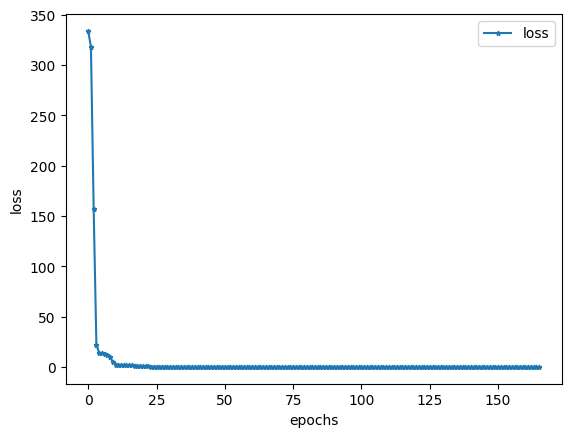

In [167]:
model_cnn_lstm2, h2_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=2, num_filters=32, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 7ms/step
         Modelo    R2   MAE  MAPE
0  CNN - LSTM 2  0.99  0.27  0.01


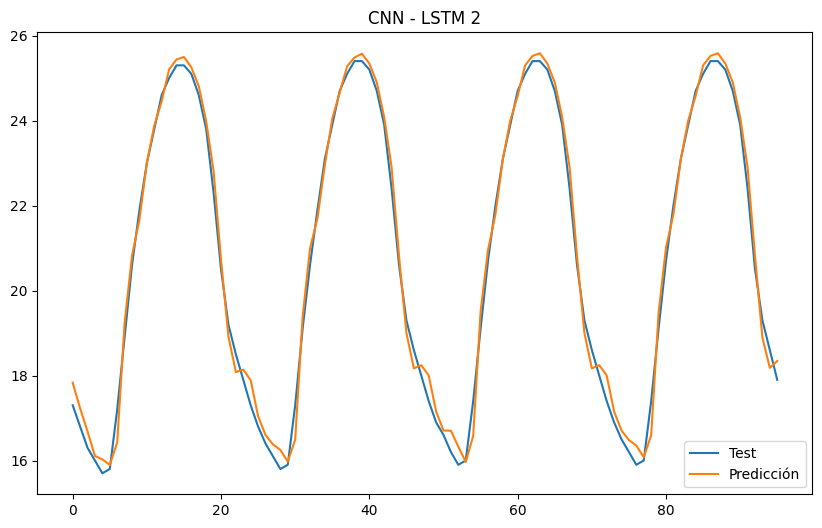

In [168]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 2',
                                          title='CNN - LSTM 2',
                                          pred=model_cnn_lstm2.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.3 CNN - LSTM 3

El último estado de la métrica mae es: 17.1468


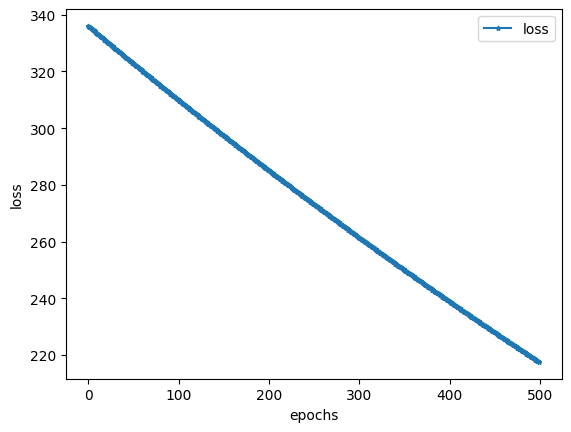

In [169]:
model_cnn_lstm3, h3_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=8, num_filters=4, kernel_size=4, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 8ms/step
         Modelo     R2    MAE  MAPE
0  CNN - LSTM 3 -24.48  17.04  0.82


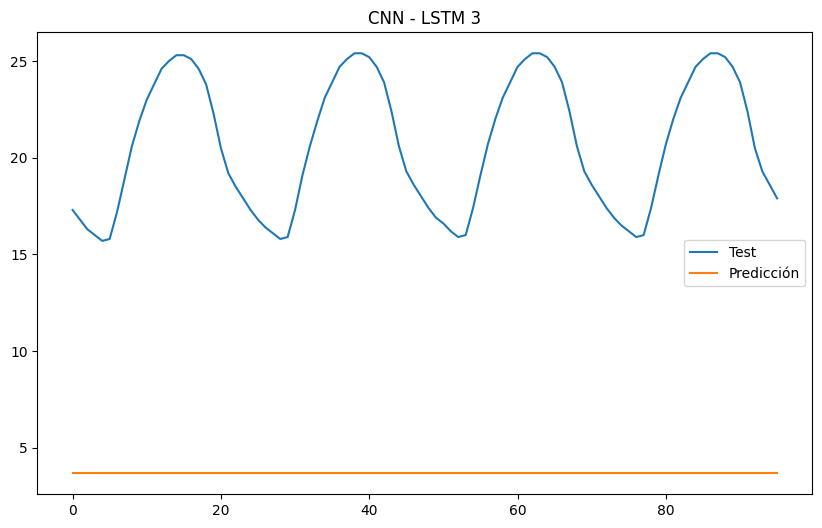

In [170]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 3',
                                          title='CNN - LSTM 3',
                                          pred=model_cnn_lstm3.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

**Conclusiones**

In [171]:
errores_cnn_lstm = Utils.concat_errores([errores_cnn_lstm1, errores_cnn_lstm2, errores_cnn_lstm3])
errores_cnn_lstm

Modelo     R2     MAE   MAPE
0  CNN - LSTM 3   0.98   56.01   0.48
1  CNN - LSTM 2  -0.23  777.95  18.83
2  CNN - LSTM 3 -24.48   17.04   0.82

3/3 [==============================] - 0s 7ms/step
         Modelo    R2   MAE  MAPE
0  CNN - LSTM 3  0.97  0.46  0.02


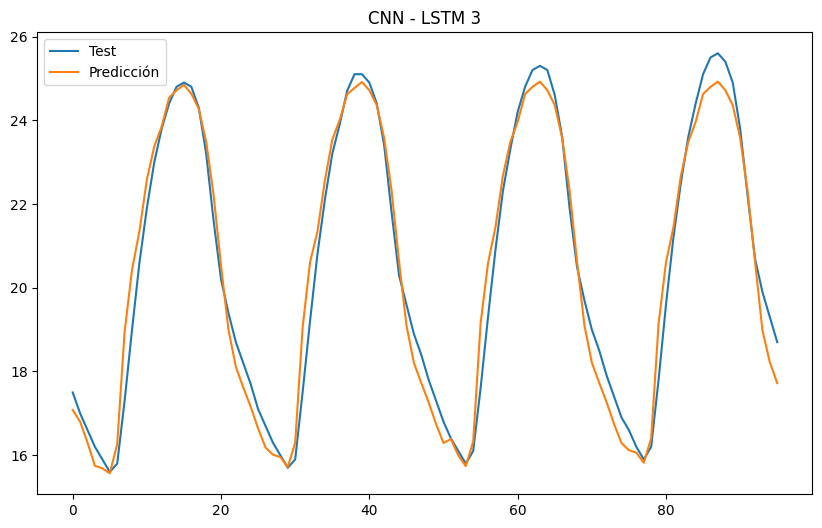

In [172]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mejor_CNN_LSTM = Utils.plot_pred_test(nombre_modelo=errores_cnn_lstm['Modelo'][0],
                                  title=errores_cnn_lstm['Modelo'][0],
                                  pred=model_cnn_lstm1.predict(X_test_tens2),
                                  test=y_test)

**Sacando el mejor modelo**

In [173]:
mejores_modelos = Utils.concat_errores([errores_mejor_MLP, errores_mejor_CNN, errores_mejor_lstm, errores_mejor_CNN_LSTM]).sort_values(by='MAE')
mejores_modelos

Modelo    R2    MAE  MAPE
0         MLP 1  0.97   0.42  0.02
1  CNN - LSTM 3  0.97   0.46  0.02
2         CNN 1  0.96   0.46  0.02
3        LSTM 2  0.03  16.86  0.38

- El mejor modelo es el MLP, por lo que es el que haremos la predicción

2/2 [==============================] - 0s 4ms/step
  Modelo    R2  MAE  MAPE
0  MLP 1  0.97  0.4  0.02


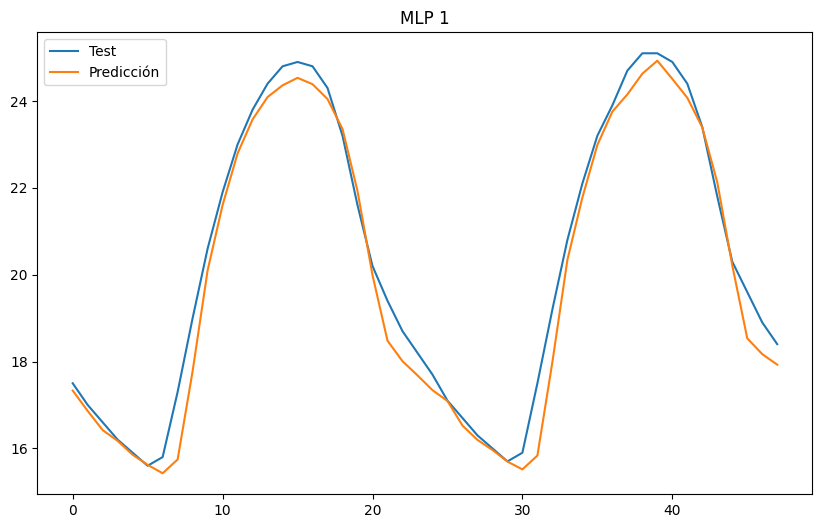

In [174]:
errores_mejor_MLP = Utils.plot_pred_test(nombre_modelo=errores_MLP['Modelo'][0],
                                         title=errores_MLP['Modelo'][0],
                                         pred=model_mlp1.predict(X_test[:48]),
                                         test=y_test[:48])

- No se hizo ajuste de hiperparámetros ya que tenemos un r2 de 0.99, lo cual buscar mejorarlo es overfitearlo y desperdiciar poder de computo.

____
### 2.5. Serie H405

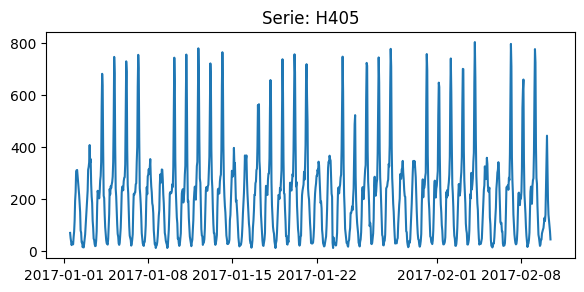

In [175]:
Utils.plot_series([h405], ['H405'])

#### 1. Preprocesamiento de los datos
- Al tener una serie que es bastante Estacional (que se repite mucho los patrones cada cierto tiempo), no veo necesario hacer un procesamiento de los datos, además de que parecen ser que son bastante simétricos.

In [176]:
# Dandole formato a la serie de tiempo
X, y = Utils.split_univariate_sequence(sequence=h405, 
                                       column='H405', 
                                       n_steps=5, 
                                       tensor=False,
                                       )

	- Forma de X: (955, 5)
	- Forma de y: (955,)


- Se seleccionó *n_steps = 5*, porque tenemos una serie de tiempo con bajadas y subidas constantes así que seleccionamos un número mediano para poder saber si es una bajada prolongada o solo es una bajada y subida y poder aprender esa estacionalidad de la serie.

In [177]:
# Separando los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = Utils.split_train_test(X=X, 
                                                          y=y, 
                                                          train_size=0.9)

- X:
	- X_train: (859, 5)
	- X_test: (96, 5)
- y:
	- y_train: (859,)
	- y_test: (96,)


#### 2. MLP - Multy Layer Perceptron
##### 2.1 MLP
- 2 Capas ocultas con 20 neuronas

El último estado de la métrica mae es: 38.3725


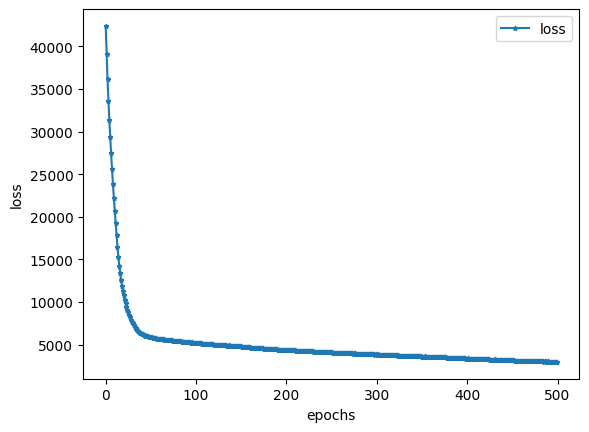

In [178]:
# Creando el modelo MLP con 5 capas ocultas de 50 neuronas
model_mlp1, h_mlp1 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=2, num_neurons=20,
                                         optimizer='Adam', lr=0.0001, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)


3/3 [==============================] - 0s 2ms/step
  Modelo   R2   MAE  MAPE
0  MLP 1  0.9  39.3  0.22


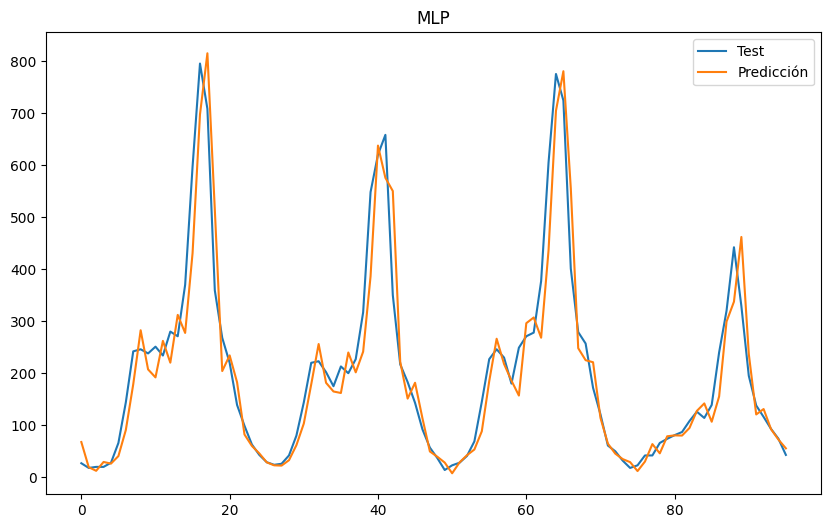

In [179]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp1 = Utils.plot_pred_test(nombre_modelo='MLP 1',
                                   title='MLP',
                                   pred=model_mlp1.predict(X_test),
                                   test=y_test
                                   )

##### 2.2 MLP
- 4 Capas ocultas con 30 neuronas

El último estado de la métrica mae es: 37.3185


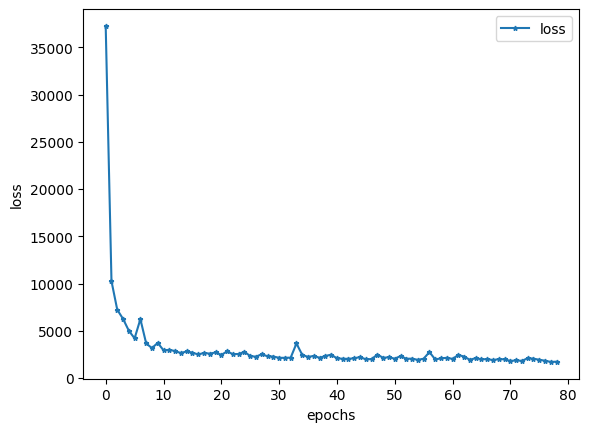

In [180]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp2, h_mlp2 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=4, num_neurons=30,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0  MLP 2  0.94  31.29   0.2


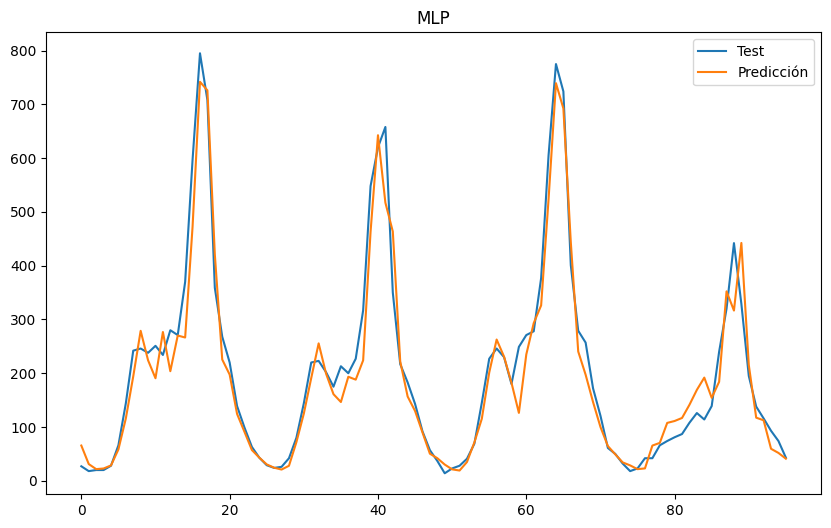

In [181]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp2 = Utils.plot_pred_test(nombre_modelo='MLP 2',
                                   title='MLP',
                                   pred=model_mlp2.predict(X_test),
                                   test=y_test
                                   )

##### 2.3 MLP
- 5 Capas ocultas con 50 neuronas

El último estado de la métrica mae es: 33.5496


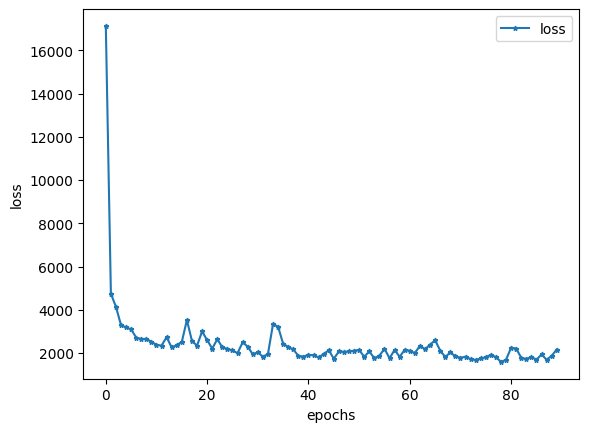

In [182]:
# Creando el modelo MLP con 4 capas ocultas de 30 neuronas
model_mlp3, h_mlp3 = Utils.gen_MLP_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                         activation='relu', num_layers=5, num_neurons=50,
                                         optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                         patience=20, epochs=500,  verbose=0,
                                         plot_history=True)

3/3 [==============================] - 0s 4ms/step
  Modelo    R2    MAE  MAPE
0  MLP 3  0.93  29.81   0.2


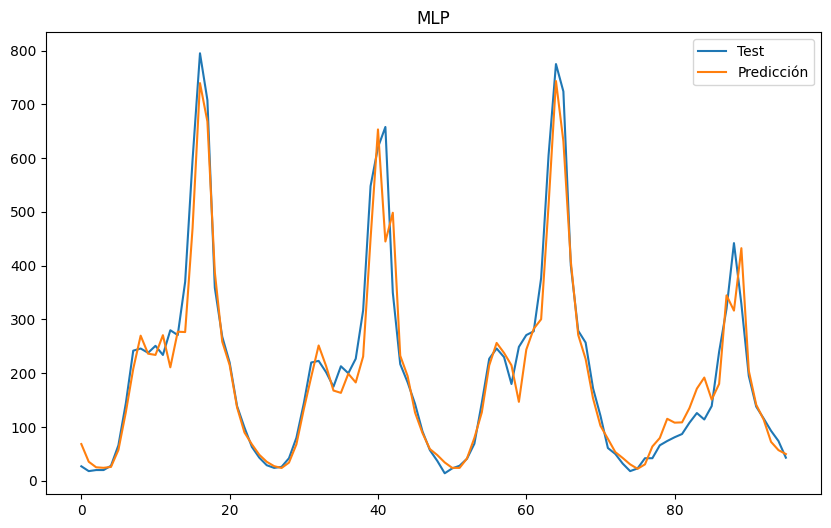

In [183]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mlp3 = Utils.plot_pred_test(nombre_modelo='MLP 3',
                                   title='MLP',
                                   pred=model_mlp3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones MLP**

In [184]:
errores_MLP = Utils.concat_errores([errores_mlp1, errores_mlp2, errores_mlp3])
errores_MLP

Modelo    R2    MAE  MAPE
0  MLP 2  0.94  31.29  0.20
1  MLP 3  0.93  29.81  0.20
2  MLP 1  0.90  39.30  0.22

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0  MLP 2  0.94  31.29   0.2


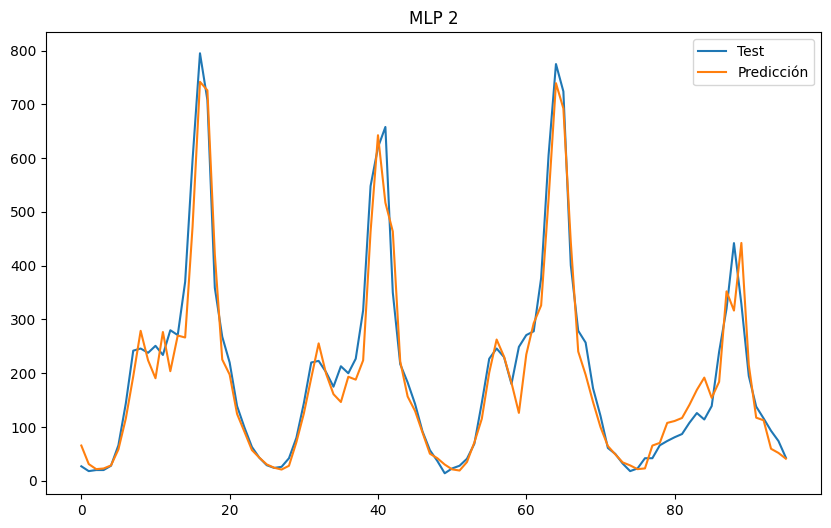

In [185]:
errores_mejor_MLP = Utils.plot_pred_test(nombre_modelo=errores_MLP['Modelo'][0],
                                         title=errores_MLP['Modelo'][0],
                                         pred=model_mlp2.predict(X_test),
                                         test=y_test)

#### 3. CNN - Convolutional Neural Network
##### 3.1. CNN 1
- Como se mencionó anteriormente, la serie tiene mucha estacionalidad muy marcada, por lo que una red CNN pequeña tendría que hacer el trabajo sin problema. Se seleccionó para empezar 2 capas convolucionales con 16 filtros de 2 y padding same, 5 capas ocultas con relu y 50 neuronas cada una.

El último estado de la métrica mae es: 33.744


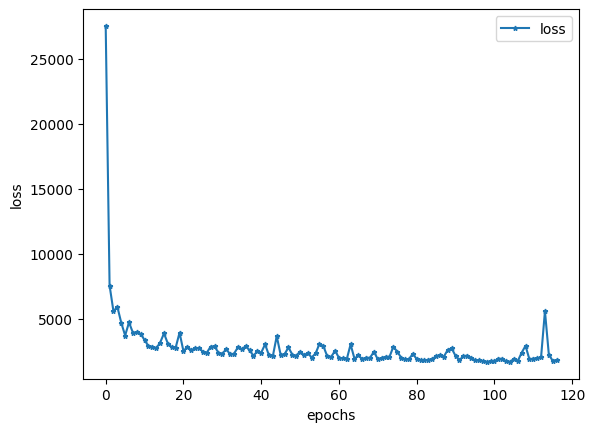

In [186]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn, h_cnn = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=2, num_filters=16, kernel_size=2, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0  CNN 1  0.95  29.73  0.22


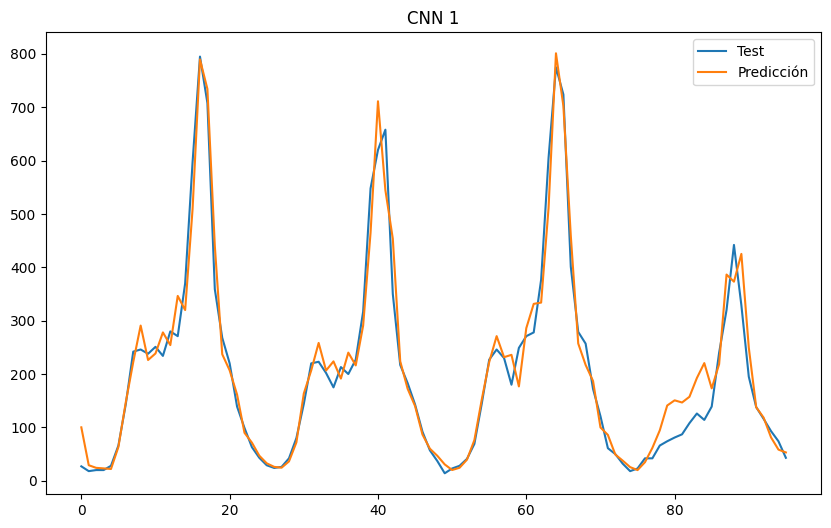

In [187]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn = Utils.plot_pred_test(nombre_modelo='CNN 1',
                                   title='CNN 1',
                                   pred=model_cnn.predict(X_test),
                                   test=y_test
                                   )

##### 3.2. CNN 2
- Agregando 2 capas convolucionales, quitando filtros y haciendo más grande el tamaño de los filtros. Buscamos que los filtros hagan un mejor trabajo.
- ASí mismo disminuimos el número de densasa para ver si funciona.

El último estado de la métrica mae es: 37.0117


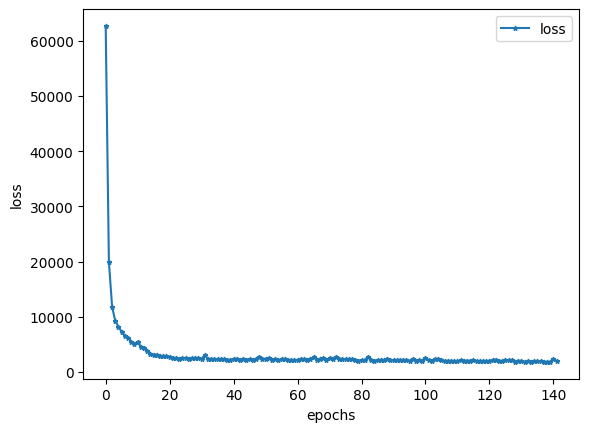

In [188]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn2, h_cnn2 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=4, num_filters=4, kernel_size=3, padding='same',
                                       activation='relu', num_layers_dense=2, num_neurons=20,
                                       optimizer='Adam', lr=0.003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0   CNN2  0.94  32.87  0.28


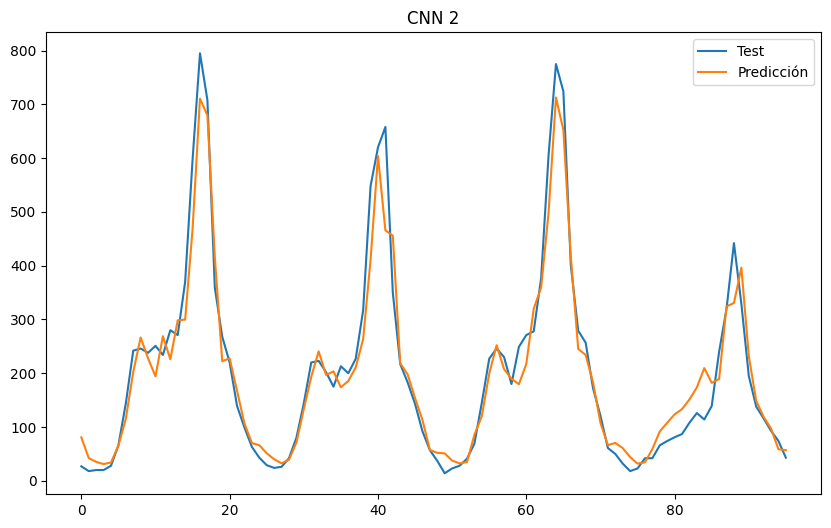

In [189]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn2 = Utils.plot_pred_test(nombre_modelo='CNN2',
                                   title='CNN 2',
                                   pred=model_cnn2.predict(X_test),
                                   test=y_test
                                   )

##### 3.3. CNN 3
- Parece ser que si funciona, aumentaremos un poco más la parte convolucioneal y también aumentaremos la parte de predicción.
- 10 capas convolucionales con 8 filtros y tamaño de 5.
- 5 capas ocultas y 50 neuronas
- Bajando el LR para bajar en la cola un poco más e intentar llegar un poco más abajo en la función de perdida.

El último estado de la métrica mae es: 31.3043


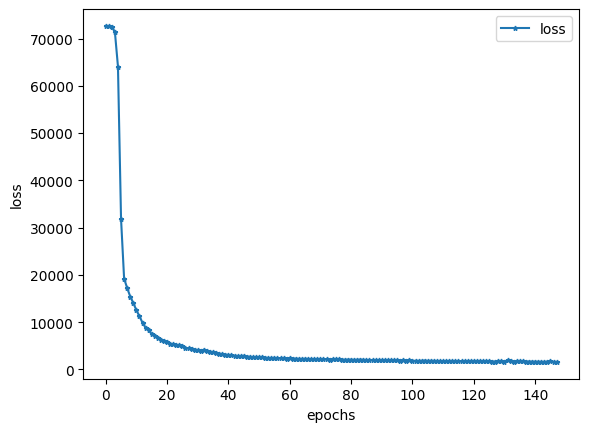

In [190]:
# Creando el modelo CNN con 2 capas CNN de 16 filtros y 5 capas Dense de 50 neuronas
model_cnn3, h_cnn3 = Utils.gen_CNN_model(X=X_train, y=y_train, val_split=0.1, n_steps=5,
                                       num_layers_cnn=10, num_filters=8, kernel_size=5, padding='same',
                                       activation='relu', num_layers_dense=5, num_neurons=50,
                                       optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                       patience=20, epochs=500,  verbose=0,
                                       plot_history=True)

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0  CNN 3  0.94  30.12  0.22


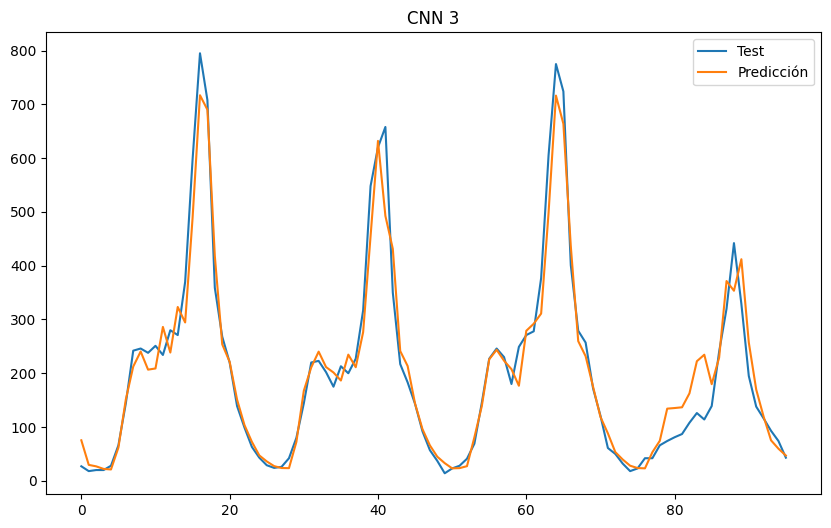

In [191]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn3 = Utils.plot_pred_test(nombre_modelo='CNN 3',
                                   title='CNN 3',
                                   pred=model_cnn3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones CNN**

In [192]:
errores_CNN = Utils.concat_errores([errores_cnn, errores_cnn2, errores_cnn3])
errores_CNN

Modelo    R2    MAE  MAPE
0  CNN 1  0.95  29.73  0.22
1   CNN2  0.94  32.87  0.28
2  CNN 3  0.94  30.12  0.22

3/3 [==============================] - 0s 3ms/step
  Modelo    R2    MAE  MAPE
0  CNN 1  0.95  29.73  0.22


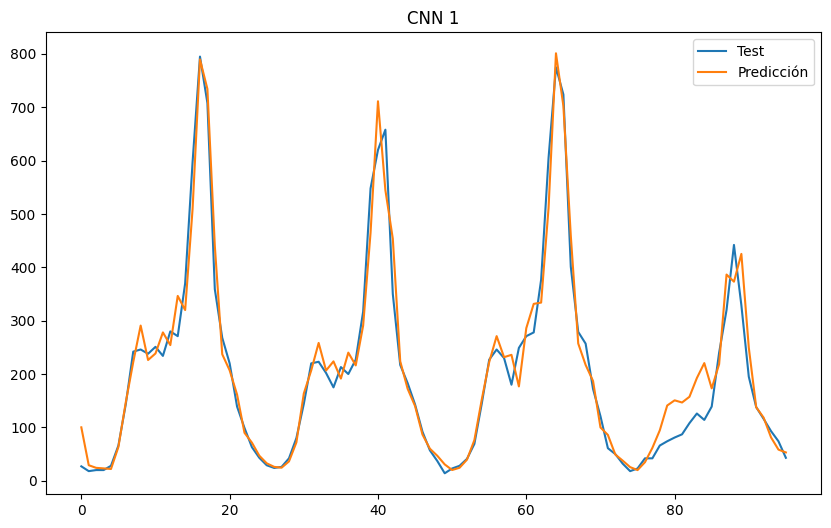

In [193]:
errores_mejor_CNN = Utils.plot_pred_test(nombre_modelo=errores_CNN['Modelo'][0],
                                         title=errores_CNN['Modelo'][0],
                                         pred=model_cnn.predict(X_test),
                                         test=y_test)

- Podemos ver que el aumento de la parte convolucional, sin embargo al aumentarla todavía más no logramos mejorar el rendimiento, por lo que seleccioné el 2 ya que es menos complejo.

#### 4. LSTM
- Para poder usar LSTM tenemos que convertir nuestros datos a tensor, por lo que rehacemos los split y Train y test.

In [194]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor
X_tens, y_tens = Utils.split_univariate_sequence(sequence=h405,
                                                 column='H405',
                                                 n_steps=5,
                                                 tensor=True,
                                                 n_features=1)

	- Forma de X: (955, 5, 1)
	- Forma de y: (955,)


In [195]:
# Dividiendo los datos en train y test
X_train_tens, X_test_tens, y_train_tens, y_test_tens = Utils.split_train_test(X=X_tens,
                                                                    y=y_tens,
                                                                    train_size=0.9
                                                                    )

- X:
	- X_train: (859, 5, 1)
	- X_test: (96, 5, 1)
- y:
	- y_train: (859,)
	- y_test: (96,)


##### 4.1 LSTM

El último estado de la métrica mae es: 31.7521


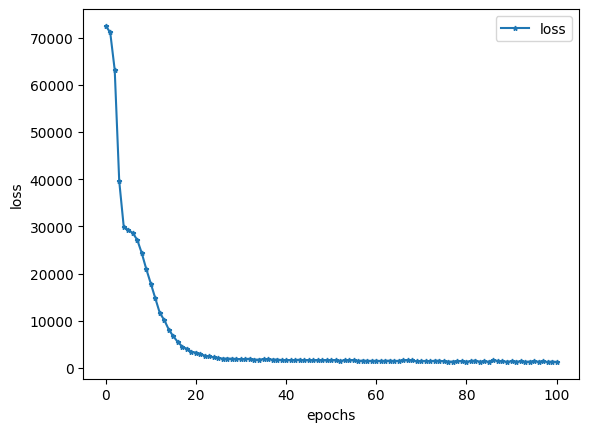

In [196]:
# Creando el modelo LSTM con 2 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm, h_lstm = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=2, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 1s 8ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 1  0.95  26.63  0.17


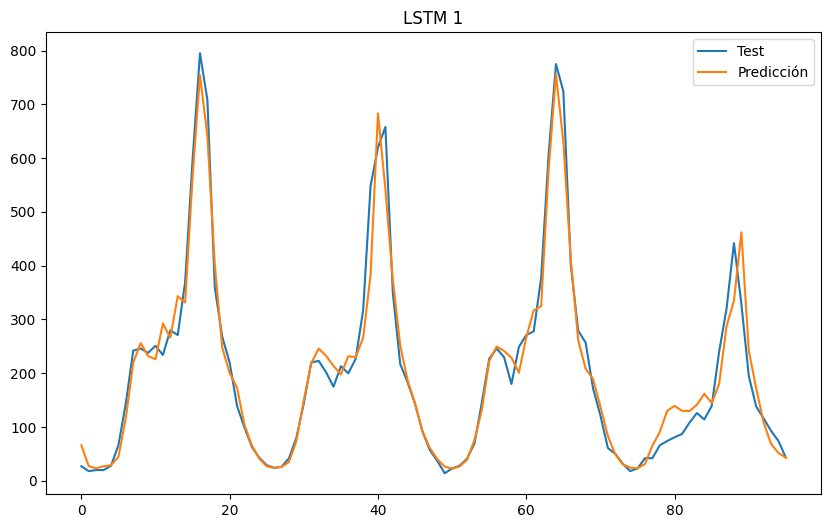

In [197]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm = Utils.plot_pred_test(nombre_modelo='LSTM 1',
                                   title='LSTM 1',
                                   pred=model_lstm.predict(X_test_tens),
                                   test=y_test
                                   )

##### 4.2 LSTM
- Aumentando capas de LSTM para ver si mejora
- 4 capas densas en vez de 2

El último estado de la métrica mae es: 34.2186


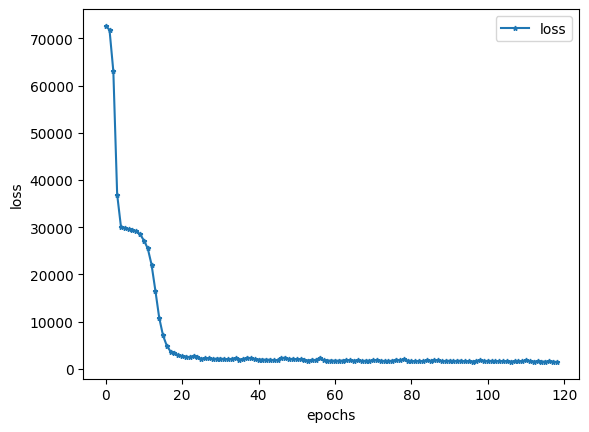

In [198]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm2, h_lstm2 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=4, activation_lstm='tanh', num_units_lstm=50, bidireccional=False,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 2s 9ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 2  0.94  29.77  0.18


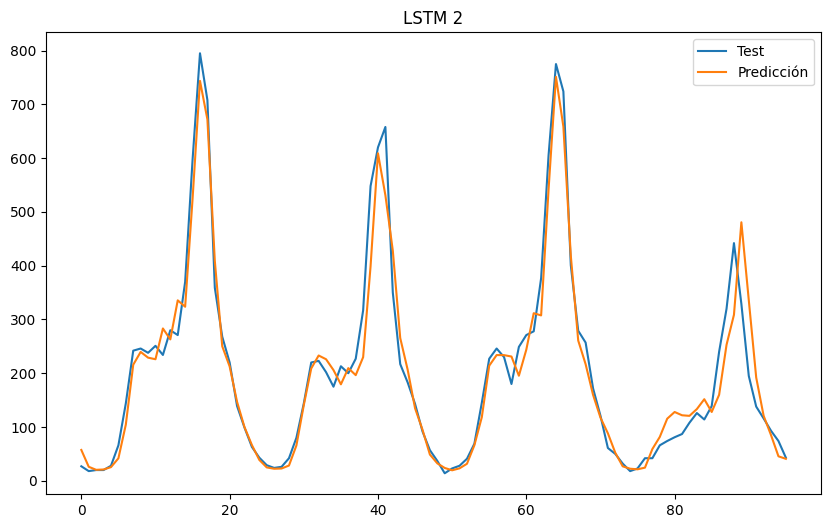

In [199]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm2 = Utils.plot_pred_test(nombre_modelo='LSTM 2',
                                   title='LSTM 2',
                                   pred=model_lstm2.predict(X_test),
                                   test=y_test
                                   )

##### 4.3 LSTM

El último estado de la métrica mae es: 27.534


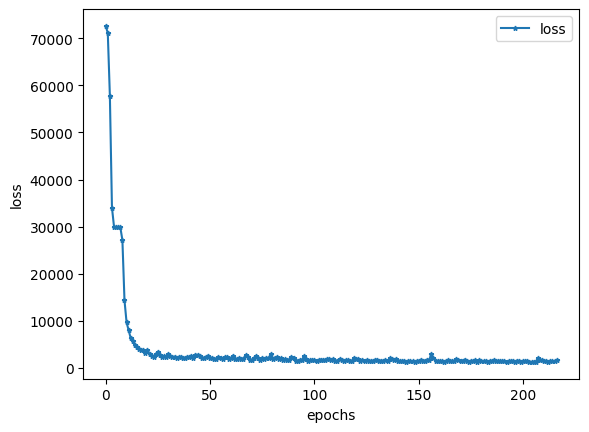

In [200]:
# Creando el modelo LSTM con 4 capas LSTM de 50 neuronas y 5 capas Dense de 50 neuronas
model_lstm3, h_lstm3 = Utils.gen_LSTM_model(X=X_train_tens, y=y_train_tens, val_split=0.1, n_steps=5, n_features=1,
                                          num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50, bidireccional=True,
                                          activation='relu', num_layers_dense=5, num_neurons=50,
                                          optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                          patience=20, epochs=500, verbose=0,
                                          plot_history=True)

3/3 [==============================] - 5s 29ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 3  0.92  31.35  0.17


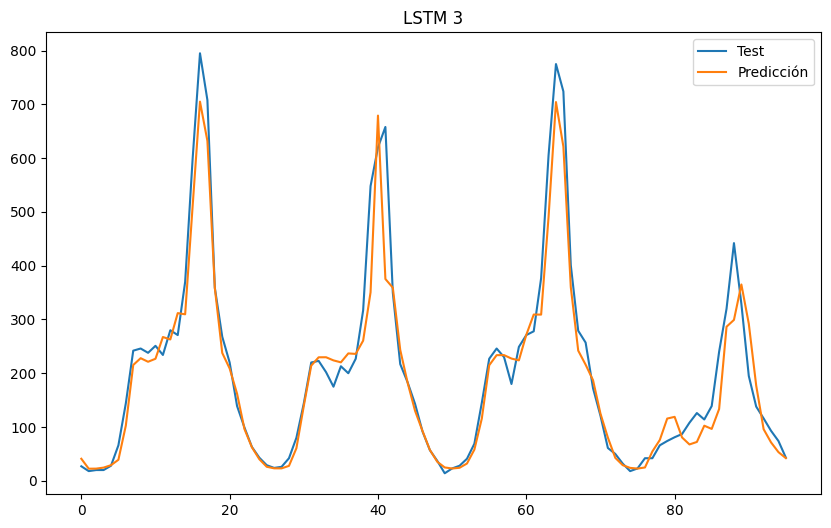

In [201]:
# Obteniendo los errores y ploteando predicciones vs test
errores_lstm3 = Utils.plot_pred_test(nombre_modelo='LSTM 3',
                                   title='LSTM 3',
                                   pred=model_lstm3.predict(X_test),
                                   test=y_test
                                   )

**Conclusiones**

In [202]:
errores_LSTM = Utils.concat_errores([errores_lstm, errores_lstm2, errores_lstm3])
errores_LSTM

Modelo    R2    MAE  MAPE
0  LSTM 1  0.95  26.63  0.17
1  LSTM 2  0.94  29.77  0.18
2  LSTM 3  0.92  31.35  0.17

3/3 [==============================] - 0s 7ms/step
   Modelo    R2    MAE  MAPE
0  LSTM 1  0.95  26.63  0.17


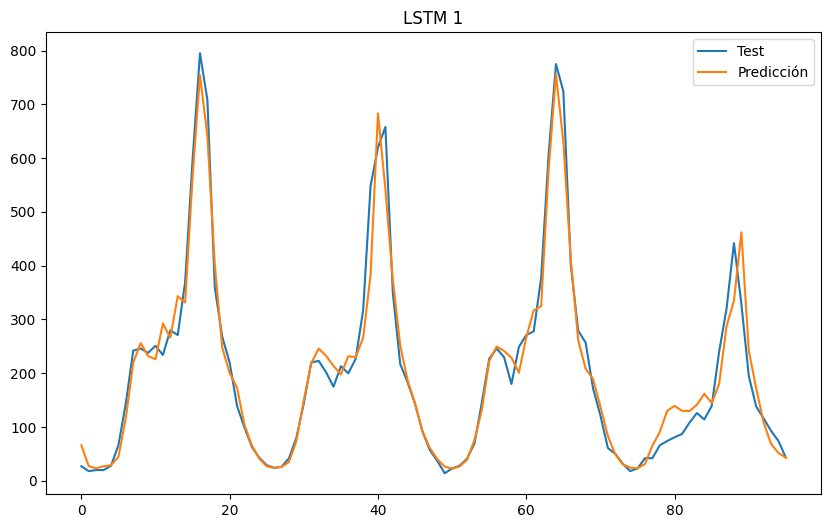

In [203]:
# Obteniendo los errores y ploteando predicciones vs test
mejor_lstm = Utils.plot_pred_test(nombre_modelo=errores_LSTM['Modelo'][0],
                                  title=errores_LSTM['Modelo'][0],
                                  pred=model_lstm.predict(X_test_tens),
                                  test=y_test)

- Tenemos un error casi nulo, sorprendemente mientras más aumentabamos las capas o la cantidad de unidades por cada (como en el caso 1 y 2 no bajo el error, parece ser que es un muy buen modelo)

#### 5. CNN - LSTM
##### 5.1. CNN - LSTM

In [217]:
# Separando los datos de entrenamiento y prueba y haciendolo tensor con 6 pasos
X_tens2, y_tens2 = Utils.split_univariate_sequence(sequence=h405,
                                                 column='H405',
                                                 n_steps=6,
                                                 tensor=True,
                                                 n_features=1)

# Dividiendo los datos en train y test
X_train_tens2, X_test_tens2, y_train_tens2, y_test_tens2 = Utils.split_train_test(X=X_tens2,
                                                                                  y=y_tens2,
                                                                                  train_size=0.9
                                                                                    )

# Cambiando el shape del X_train_tens y X_test_tens
n_seq = 2
n_steps = 3
n_features = 1

# Cambiando el shape del X_train_tens y X_test_tens
X_train_tens2 = X_train_tens2.reshape((X_train_tens2.shape[0], n_seq, n_steps, n_features))
X_test_tens2 = X_test_tens2.reshape((X_test_tens2.shape[0], n_seq, n_steps, n_features))

	- Forma de X: (954, 6, 1)
	- Forma de y: (954,)
- X:
	- X_train: (858, 6, 1)
	- X_test: (96, 6, 1)
- y:
	- y_train: (858,)
	- y_test: (96,)


El último estado de la métrica mae es: 28.2515


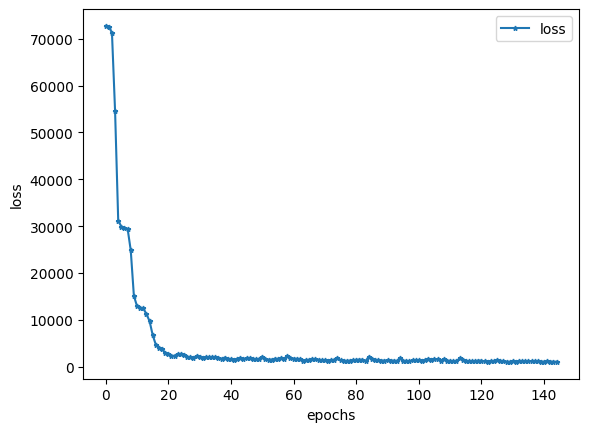

In [218]:
model_cnn_lstm1, h1_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=4, num_filters=16, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 8ms/step
         Modelo    R2    MAE  MAPE
0  CNN - LSTM 1  0.94  27.43  0.18


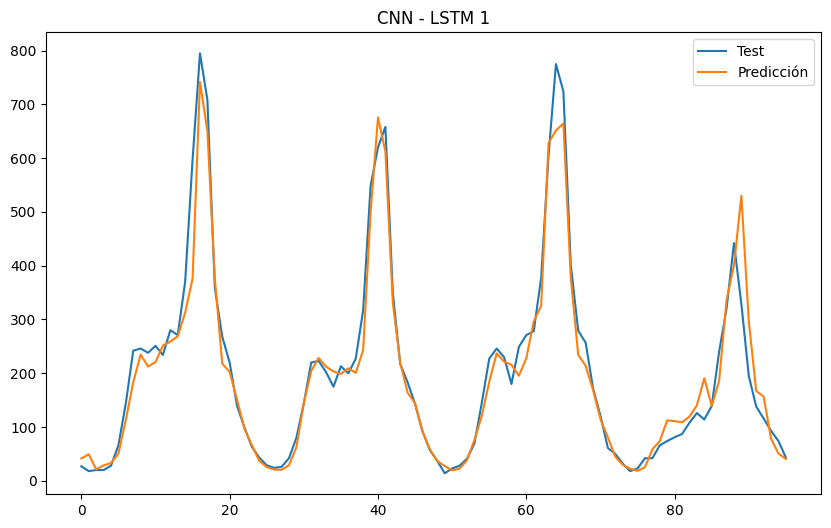

In [219]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 1',
                                          title='CNN - LSTM 1',
                                          pred=model_cnn_lstm1.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.2 CNN - LSTM 2

El último estado de la métrica mae es: 32.7633


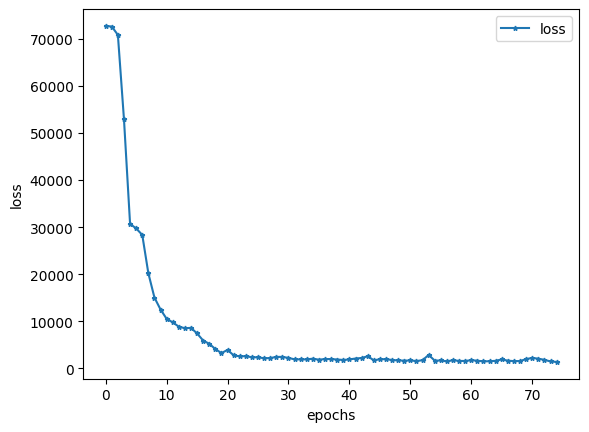

In [220]:
model_cnn_lstm2, h2_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=2, num_filters=32, kernel_size=3, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 9ms/step
         Modelo    R2    MAE  MAPE
0  CNN - LSTM 2  0.92  33.88  0.23


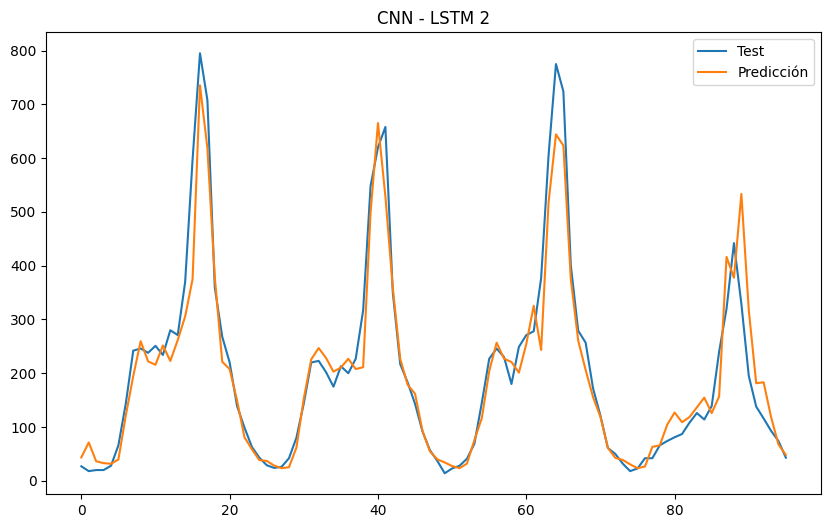

In [221]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 2',
                                          title='CNN - LSTM 2',
                                          pred=model_cnn_lstm2.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

##### 5.3 CNN - LSTM 3

El último estado de la métrica mae es: 207.7692


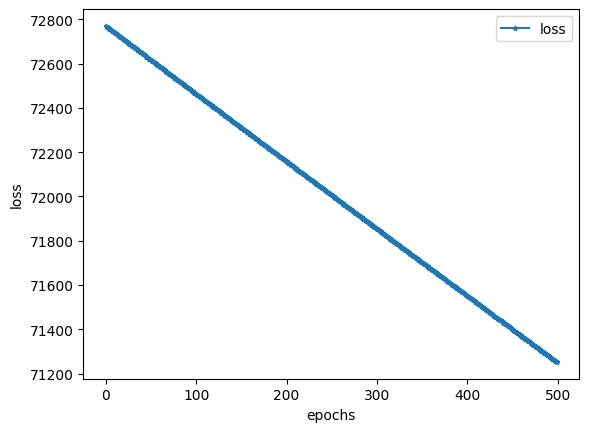

In [222]:
model_cnn_lstm3, h3_cnn_lstm = Utils.gen_CNN_LSTM_model(X=X_train_tens2, y=y_train_tens2, val_split=0.1, n_steps=5, n_features=1,
                                                  num_layers_cnn=8, num_filters=4, kernel_size=4, padding='same',
                                                  num_layers_lstm=5, activation_lstm='tanh', num_units_lstm=50,
                                                  activation='relu', num_layers_dense=5, num_neurons=50, 
                                                  optimizer='Adam', lr=0.0003, loss='mse', metrics=['mae'],
                                                  patience=20, epochs=500, verbose=0,
                                                  plot_history=True)

3/3 [==============================] - 3s 9ms/step
         Modelo    R2     MAE  MAPE
0  CNN - LSTM 3 -1.17  199.82  0.95


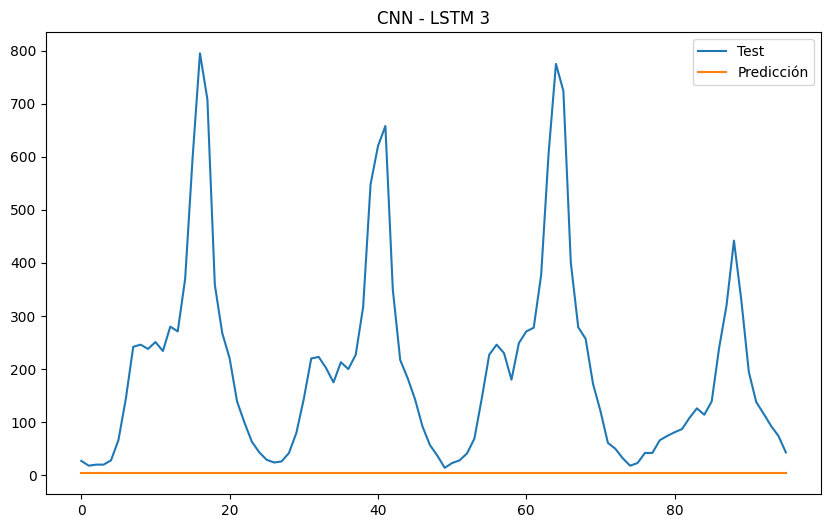

In [223]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn_lstm1 = Utils.plot_pred_test(nombre_modelo='CNN - LSTM 3',
                                          title='CNN - LSTM 3',
                                          pred=model_cnn_lstm3.predict(X_test_tens2),
                                          test=y_test_tens2
                                          )

**Conclusiones**

In [224]:
errores_cnn_lstm = Utils.concat_errores([errores_cnn_lstm1, errores_cnn_lstm2, errores_cnn_lstm3])
errores_cnn_lstm

Modelo    R2     MAE   MAPE
0  CNN - LSTM 3  0.98   56.01   0.48
1  CNN - LSTM 2 -0.23  777.95  18.83
2  CNN - LSTM 3 -1.17  199.82   0.95

3/3 [==============================] - 0s 10ms/step
         Modelo    R2    MAE  MAPE
0  CNN - LSTM 3  0.92  33.88  0.23


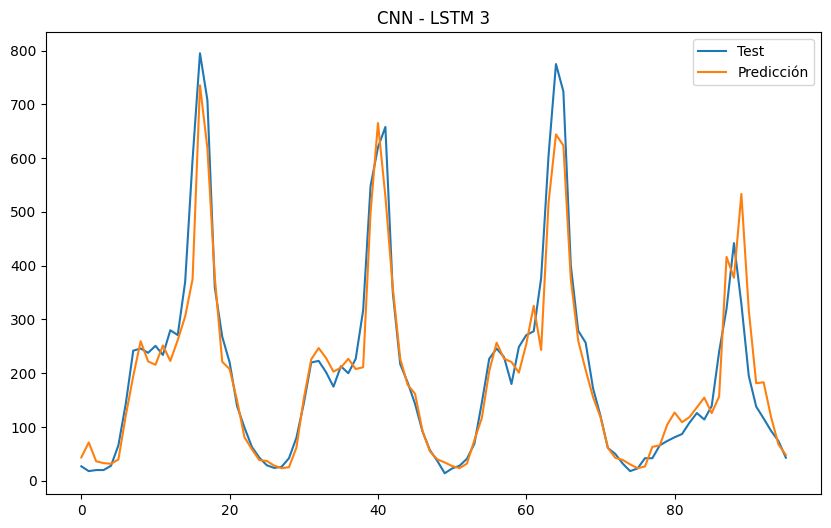

In [225]:
# Obteniendo los errores y ploteando predicciones vs test
errores_mejor_CNN_LSTM = Utils.plot_pred_test(nombre_modelo=errores_cnn_lstm['Modelo'][0],
                                  title=errores_cnn_lstm['Modelo'][0],
                                  pred=model_cnn_lstm2.predict(X_test_tens2),
                                  test=y_test)

**Sacando el mejor modelo**

In [226]:
mejores_modelos = Utils.concat_errores([errores_mejor_MLP, errores_mejor_CNN, errores_mejor_lstm, errores_mejor_CNN_LSTM]).sort_values(by='MAE')
mejores_modelos

Modelo    R2    MAE  MAPE
3        LSTM 2  0.03  16.86  0.38
0         CNN 1  0.95  29.73  0.22
1         MLP 2  0.94  31.29  0.20
2  CNN - LSTM 3  0.92  33.88  0.23

- El mejor modelo es el LSTM, por lo que es el que haremos la predicción

3/3 [==============================] - 0s 4ms/step
  Modelo    R2    MAE  MAPE
0  CNN 1  0.95  29.73  0.22


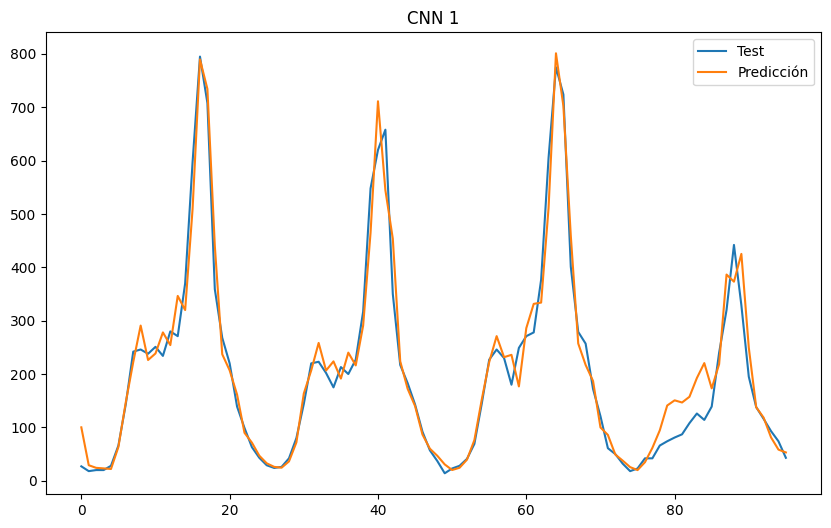

In [237]:
# Obteniendo los errores y ploteando predicciones vs test
errores_cnn = Utils.plot_pred_test(nombre_modelo='CNN 1',
                                   title='CNN 1',
                                   pred=model_cnn.predict(X_test),
                                   test=y_test
                                   )

- No se hizo ajuste de hiperparámetros ya que tenemos un r2 de 0.99, lo cual buscar mejorarlo es overfitearlo y desperdiciar poder de computo.